# Load Data

In [0]:
from pyspark.sql.functions import broadcast

### LOAD DATA ###
# Saved in data integrations notebook

BASE_PATH = "dbfs:/FileStore/tables/paris_project/silver"

print(f"Loading data from: {BASE_PATH}...\n")

# 1. Load Global Train
global_train_df = spark.read.parquet(f"{BASE_PATH}/global_train_v2.parquet")
global_size = global_train_df.count()

# 2. Load Local Train Pool
local_train_df = spark.read.parquet(f"{BASE_PATH}/local_train_pool_v2.parquet")
local_size = local_train_df.count()

# 3. Load Test Set
test_df = spark.read.parquet(f"{BASE_PATH}/test_set_v2.parquet")


### VERIFICATION ###
# Verify there is no leakage between the datasets

print(f"✅ Global Train Count: {global_size:,}")
print(f"✅ Local Train Count:  {local_size:,}")
print(f"🔒 Test Set Count:      {test_df.count():,} (LOCKED)\n")

local_leakage = local_train_df.join(broadcast(test_df), on="id", how="inner").count()
global_leakage = global_train_df.join(broadcast(test_df), on="id", how="inner").count()

if local_leakage > 0 or global_leakage > 0:
    err_msg = ""
    if local_leakage > 0:
        err_msg += f"CRITICAL: Data Leakage In Local Train Set: {local_leakage:,} test records found.\n"
    if global_leakage > 0:
        err_msg += f"CRITICAL: Data Leakage In Global Train Set: {global_leakage:,} test records found.\n"
    raise Exception(err_msg)
else:
    print("✅ No Data Leakage Found (Verified via Broadcast Join)")

Loading data from: dbfs:/FileStore/tables/paris_project/gold...

✅ Global Train Count: 1,328,542
✅ Local Train Count:  43,028
🔒 Test Set Count:      10,935 (LOCKED)

✅ No Data Leakage Found (Verified via Broadcast Join)


# Data Cleaning

## Global Data Cleaning

Display for easy attributed lookup

In [0]:
display(global_train_df.limit(5))

### Pricing

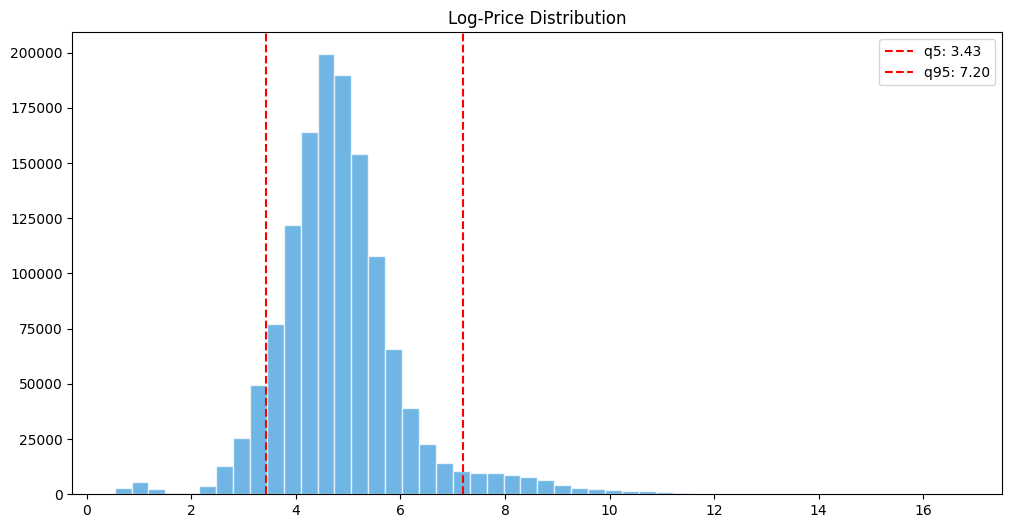

In [0]:
from pyspark.sql import functions as F
import matplotlib.pyplot as plt

# 1. Get quantiles (approximated)
q5, q95 = global_train_df.stat.approxQuantile("log_price", [0.05, 0.95], 0.01)

# 2. Plot log-price histogram
num_bins = 50
min_val, max_val = global_train_df.select(F.min("log_price"), F.max("log_price")).first()
bin_width = (max_val - min_val) / num_bins

hist_df = (global_train_df
           .select(((F.col("log_price") - min_val) / bin_width).cast("int").alias("bin"))
           .groupBy("bin")
           .count()
           .orderBy("bin")
           .toPandas())

plt.figure(figsize=(12, 6))
plt.bar(hist_df["bin"] * bin_width + min_val, hist_df["count"], width=bin_width, 
        color='#3498db', edgecolor='white', alpha=0.7)

plt.axvline(q5, color='red', linestyle='--', label=f'q5: {q5:.2f}')
plt.axvline(q95, color='red', linestyle='--', label=f'q95: {q95:.2f}')
plt.title('Log-Price Distribution')
plt.legend()
plt.show()

By the distribution we can see that the outliers are below 2 or above 7. So we will look only at log-prices in the range [2,7]. This decision will be applied also to the local train and test dataset to be consistent. 
Also the other price columns are not relevant anymore so we can drop them to work with a smaller dataset.

In [0]:
from pyspark.sql.functions import col
global_train_df = global_train_df.filter((col("log_price") >= 2) & (col("log_price") <= 7))

### Rating

#### Host \ Listing rating

Statistics for Ratings:
-RECORD 0-------------------------
 ratings_nulls            | 3     
 ratings_zeros            | 96927 
 ratings_min              | 0.0   
 ratings_max              | 5.0   
 ratings_out_of_range     | 0     
 host_rating_nulls        | 4406  
 host_rating_zeros        | 48231 
 host_rating_min          | 0.0   
 host_rating_max          | 5.0   
 host_rating_out_of_range | 0     



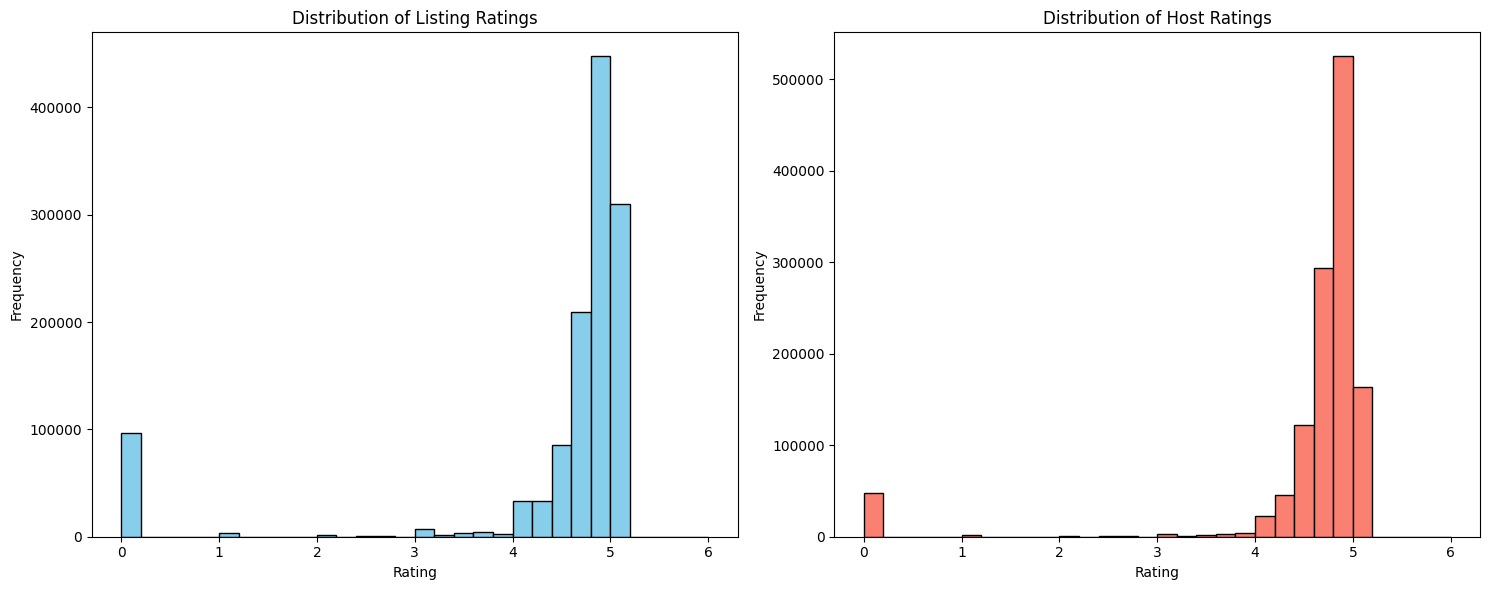

In [0]:
from pyspark.sql.functions import col, count, when, min, max
import matplotlib.pyplot as plt

# 1. Cast columns to Double for analysis
# non-numeric values will become nulls automatically upon casting
df_analysis = global_train_df.select(col("ratings").cast("float"), col("host_rating").cast("float"))

# 2. Calculate Statistics: Nulls, Zeros, Min, Max, and Out-of-Range counts
stats = df_analysis.select(
    # Listing Ratings Stats
    count(when(col("ratings").isNull(), True)).alias("ratings_nulls"),
    count(when(col("ratings") == 0, True)).alias("ratings_zeros"),
    min("ratings").alias("ratings_min"),
    max("ratings").alias("ratings_max"),
    count(when((col("ratings") < 0) | (col("ratings") > 5), True)).alias("ratings_out_of_range"),
    
    # Host Rating Stats
    count(when(col("host_rating").isNull(), True)).alias("host_rating_nulls"),
    count(when(col("host_rating") == 0, True)).alias("host_rating_zeros"),
    min("host_rating").alias("host_rating_min"),
    max("host_rating").alias("host_rating_max"),
    count(when((col("host_rating") < 0) | (col("host_rating") > 5), True)).alias("host_rating_out_of_range")
)

print("Statistics for Ratings:")
stats.show(vertical=True, truncate=False)

# 3. Plot Histograms
pdf = df_analysis.select("ratings", "host_rating").toPandas()

fig, ax = plt.subplots(1, 2, figsize=(15, 6))

# Listing Ratings Histogram
pdf["ratings"].plot(kind='hist', bins=30, range=(0, 6), ax=ax[0], color='skyblue', edgecolor='black')
ax[0].set_title('Distribution of Listing Ratings')
ax[0].set_xlabel('Rating')
ax[0].set_ylabel('Frequency')

# Host Ratings Histogram
pdf["host_rating"].plot(kind='hist', bins=30, range=(0, 6), ax=ax[1], color='salmon', edgecolor='black')
ax[1].set_title('Distribution of Host Ratings')
ax[1].set_xlabel('Rating')

plt.tight_layout()
plt.show()

All rating values are in range both for listings and hosts.
Nulls percentage is neglectible so records with null rating values are dropped.

In [0]:
from pyspark.sql.functions import col
from pyspark.sql.types import DoubleType

# 1. Cast ratings attributes to Double
cols_to_cast = ["ratings", "host_rating"]

for column in cols_to_cast:
    global_train_df = global_train_df.withColumn(column, col(column).cast("double"))

# 2. Drop records where ratings OR host_rating are Null
global_train_df = global_train_df.dropna(subset=["ratings", "host_rating"])

#### Listing rating by category

In [0]:
from pyspark.sql.types import ArrayType, StructType, StructField, StringType
from pyspark.sql.functions import from_json, expr, col, size, explode

# 1. Define the schema for the JSON string inside the column
json_schema = ArrayType(StructType([
    StructField("name", StringType(), True),
    StructField("value", StringType(), True)
]))

# 2. Parse the JSON string into an Array column
df_parsed = global_train_df.withColumn("parsed_ratings", from_json(col("category_rating"), json_schema))

# 3. Identify what categories exist
unique_categories = df_parsed.select(explode("parsed_ratings").alias("rating_obj")).select("rating_obj.name").distinct().toPandas()["name"].tolist()

print(f"Categories found: {unique_categories}")

# 4. Extract each category into its own column
for cat in unique_categories:
    df_parsed = df_parsed.withColumn(
        f"rating_{cat}", expr(f"filter(parsed_ratings, x -> x.name == '{cat}')[0].value").cast("double")
    )

Categories found: ['Lage', 'Exactitude', 'Accuracy', 'Sauberkeit', 'Kommunikation', 'Arrivée', 'Propreté', 'Rapport qualité-prix', 'Emplacement', 'Cleanliness', 'Location', 'Value', 'Check-in', 'Genauigkeit der Angaben', 'Preis-Leistungs-Verhältnis', 'Communication']


In [0]:
from pyspark.sql.functions import from_json, col, explode
from pyspark.sql.types import ArrayType, StructType, StructField, StringType


# 1. Define the schema for the category_rating column
rating_schema = ArrayType(StructType([
    StructField("name", StringType()),
    StructField("value", StringType())
]))

# 2. Parse the JSON and explode the array into rows
exploded_df = global_train_df.withColumn("ratings_parsed", from_json(col("category_rating"), rating_schema)) \
    .select("id", explode(col("ratings_parsed")).alias("rating_item")) \
    .select("id", col("rating_item.name").alias("cat_name"), col("rating_item.value").cast("float").alias("cat_value"))

# 3. Pivot the data to create individual columns for each rating category
df_with_subratings = exploded_df.groupBy("id").pivot("cat_name").avg("cat_value")

# 4. Rename columns to match your 'rating_' prefix requirement
unique_categories = [row['cat_name'] for row in exploded_df.select("cat_name").distinct().collect()]
for cat in unique_categories:
    df_with_subratings = df_with_subratings.withColumnRenamed(cat, f"rating_{cat}")

# --- NOW YOUR ORIGINAL CODE WILL WORK ---
sub_rating_cols = [f"rating_{cat}" for cat in unique_categories]

# Calculate statistics (Nulls, Zeros, Min, Max) to choose meaningful categories
sub_rating_cols = [f"rating_{cat}" for cat in unique_categories]

stats_exprs = []
for c in sub_rating_cols:
    stats_exprs.extend([
        count(when(col(c).isNull(), c)).alias(f"{c}_nulls"),
        count(when(col(c) == 0, c)).alias(f"{c}_zeros"),
        min(c).alias(f"{c}_min"),
        max(c).alias(f"{c}_max")
    ])

df_with_subratings.select(stats_exprs).show(vertical=True, truncate=False)

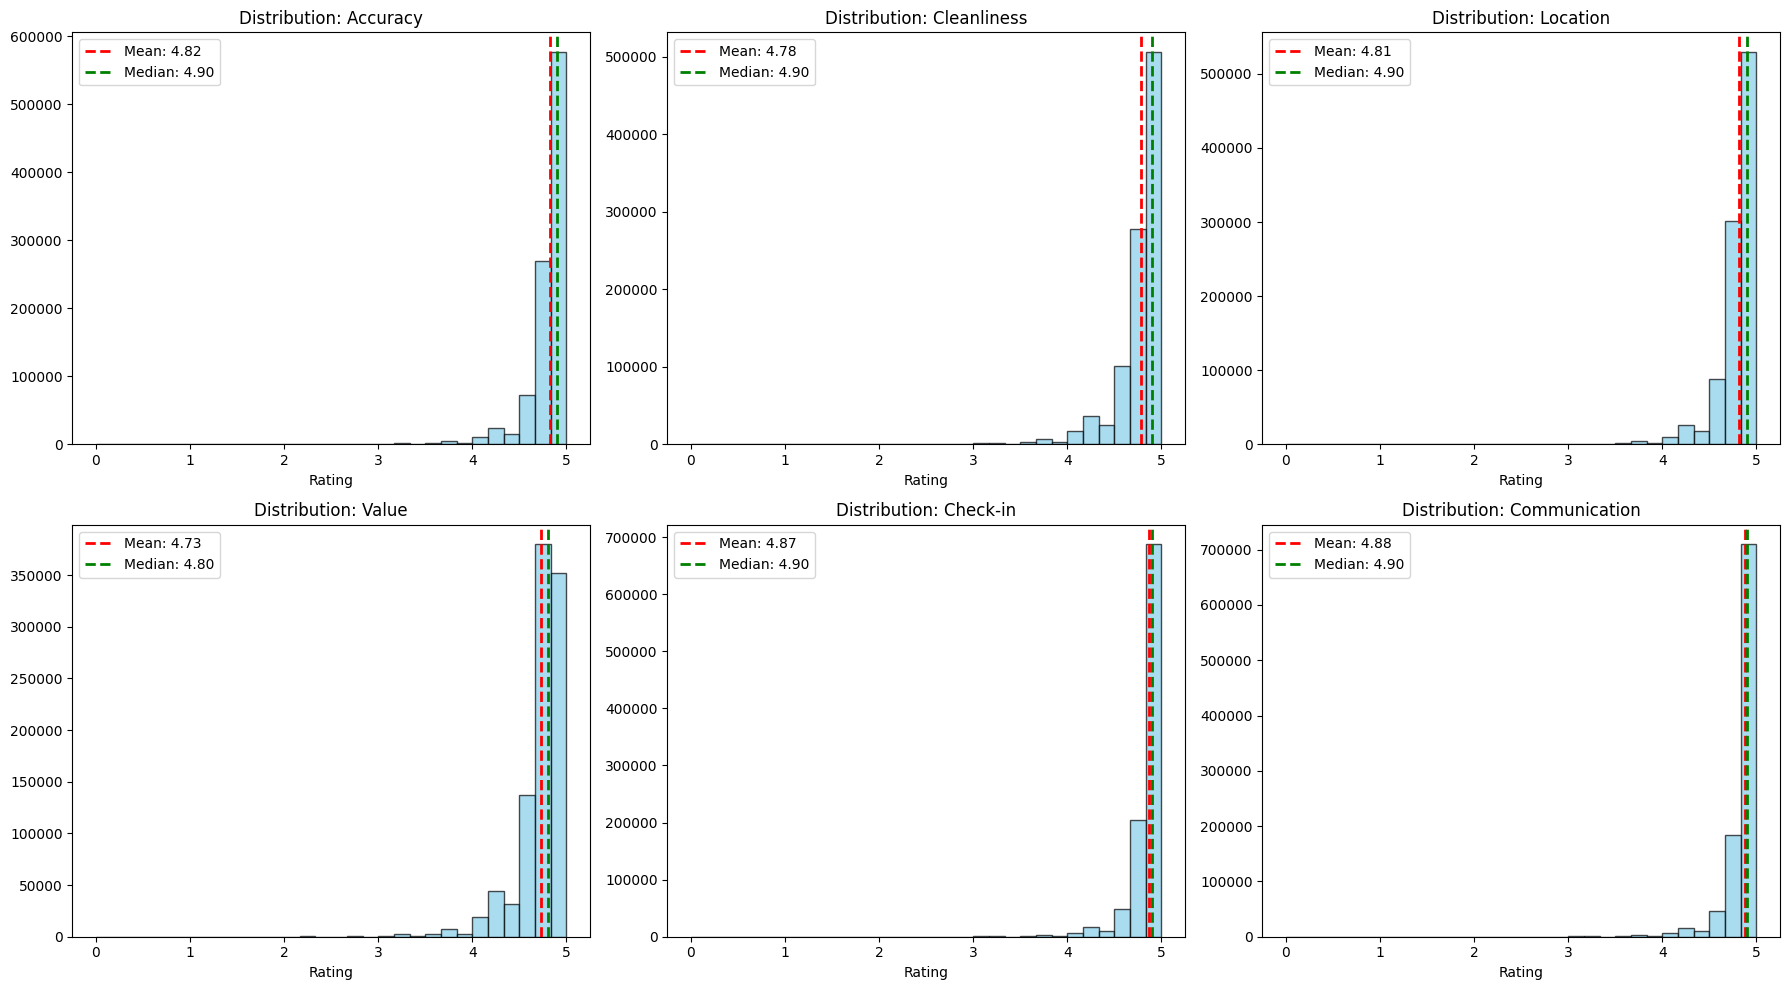

In [0]:
import matplotlib.pyplot as plt
from pyspark.sql.functions import col, from_json, expr, avg, percentile_approx
from pyspark.sql.types import ArrayType, StructType, StructField, StringType

# 1. Define the specific categories to analyze (chosen by the cell above)
target_categories = [
    "Accuracy", 
    "Cleanliness", 
    "Location", 
    "Value", 
    "Check-in", 
    "Communication"
]

# 2. Define schema and parse the JSON column
json_schema = ArrayType(StructType([
    StructField("name", StringType(), True),
    StructField("value", StringType(), True)
]))

df_viz = global_train_df.select("category_rating").withColumn("parsed", from_json(col("category_rating"), json_schema))

# 3. Extract columns and cast to Double
for cat in target_categories:
    df_viz = df_viz.withColumn(
        cat, 
        expr(f"filter(parsed, x -> x.name == '{cat}')[0].value").cast("double")
    )

df_viz = df_viz.select(target_categories)

# 4. Calculate Mean and Median for each category
stats = {}
for cat in target_categories:
    row = df_viz.select(
        avg(col(cat)).alias("mean"), 
        percentile_approx(col(cat), 0.5).alias("median")).first()
    stats[cat] = {'mean': row['mean'], 'median': row['median']}

# 5. Plot histogram per category
pdf_ratings = df_viz.toPandas()

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for i, cat in enumerate(target_categories):
    ax = axes[i]

    data = pdf_ratings[cat].dropna()
    ax.hist(data, bins=30, range=(0, 5), color='skyblue', edgecolor='black', alpha=0.7)

    mean_val = stats[cat]['mean']
    ax.axvline(mean_val, color='red', linestyle='dashed', linewidth=2, label=f'Mean: {mean_val:.2f}')

    median_val = stats[cat]['median']
    ax.axvline(median_val, color='green', linestyle='dashed', linewidth=2, label=f'Median: {median_val:.2f}')
    
    ax.set_title(f'Distribution: {cat}')
    ax.set_xlabel('Rating')
    ax.legend()

plt.tight_layout()
plt.show()

In [0]:
from pyspark.sql.functions import col, from_json, expr, coalesce, count, when
from pyspark.sql.types import ArrayType, StructType, StructField, StringType

# 1. Define the specific categories we want to keep
target_categories = [
    "Accuracy", 
    "Cleanliness", 
    "Location", 
    "Value", 
    "Check-in", 
    "Communication"
]

# 2. Define Schema for the JSON array
json_schema = ArrayType(StructType([
    StructField("name", StringType(), True),
    StructField("value", StringType(), True)
]))

# 3. Parse the JSON string into a temporary array column
global_train_df = global_train_df.withColumn("parsed_ratings", from_json(col("category_rating"), json_schema))

# 4. Add chosen categories to the dataset
for cat in target_categories:
    new_col_name = f"rating_{cat}"
    
    # Logic: 
    # 1. Extract the value for the specific category from the array
    # 2. Cast it to Double
    # 3. If that result is Null, use the value from the main "ratings" column instead
    global_train_df = global_train_df.withColumn(
        new_col_name, 
        coalesce(expr(f"filter(parsed_ratings, x -> x.name == '{cat}')[0].value").cast("double"), col("ratings"))
    )


Display the corrected plots after imputation

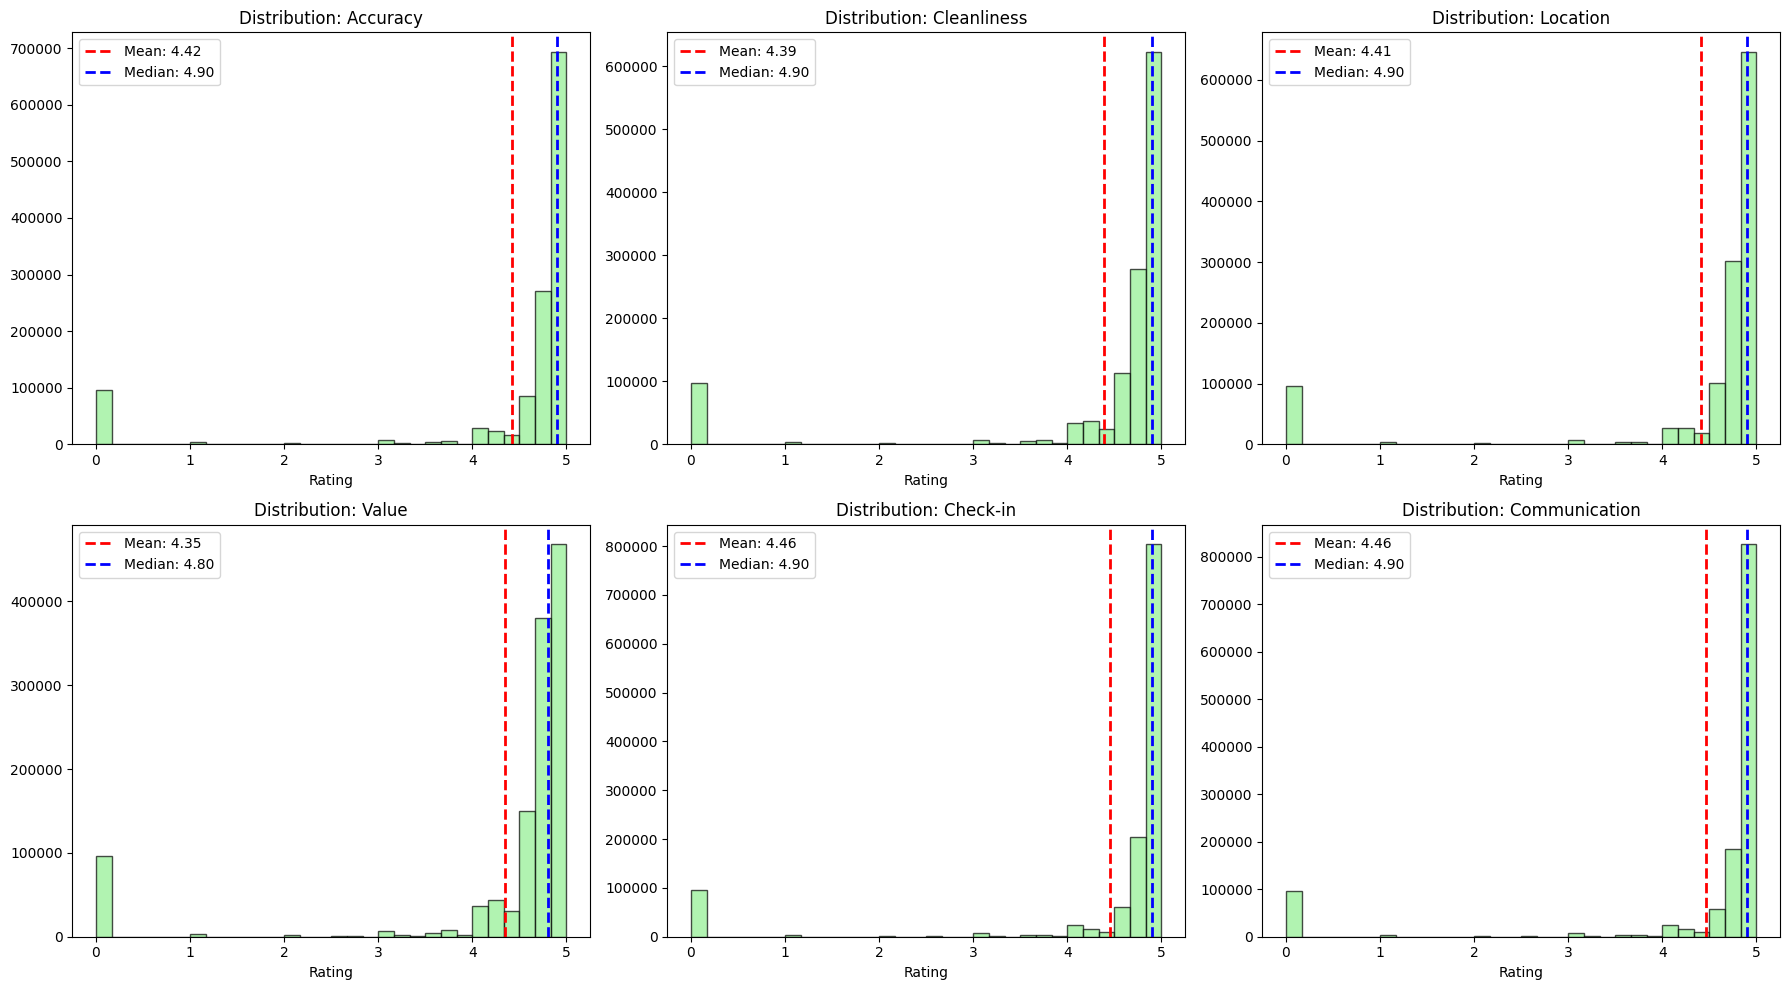

In [0]:
import matplotlib.pyplot as plt
from pyspark.sql.functions import col, avg, percentile_approx
# 1. Define the new imputed column names
target_cols = [
    "rating_Accuracy", 
    "rating_Cleanliness", 
    "rating_Location", 
    "rating_Value", 
    "rating_Check-in", 
    "rating_Communication"
]

# 2. Calculate Mean and Median for the new columns
stats = {}
for c in target_cols:
    row = global_train_df.select(
        avg(col(c)).alias("mean"), 
        percentile_approx(col(c), 0.5).alias("median")
    ).first()
    stats[c] = {'mean': row['mean'], 'median': row['median']}

# 3. Bring data to Pandas for Plotting
pdf_ratings = global_train_df.select(target_cols).toPandas()

# 4. Plotting
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for i, c in enumerate(target_cols):
    ax = axes[i]
    
    # Plot Histogram
    ax.hist(pdf_ratings[c], bins=30, range=(0, 5), color='lightgreen', edgecolor='black', alpha=0.7)
    
    # Add Mean line
    mean_val = stats[c]['mean']
    ax.axvline(mean_val, color='red', linestyle='dashed', linewidth=2, label=f'Mean: {mean_val:.2f}')
    
    # Add Median line
    median_val = stats[c]['median']
    ax.axvline(median_val, color='blue', linestyle='dashed', linewidth=2, label=f'Median: {median_val:.2f}')
    
    # Clean up labels (remove 'rating_' prefix for title)
    title = c.replace("rating_", "")
    ax.set_title(f'Distribution: {title}')
    ax.set_xlabel('Rating')
    ax.legend()

plt.tight_layout()
plt.show()

### Location

#### Country, Region, City

In [0]:
from pyspark.sql.functions import split, element_at, trim, col, size, when, lower

# Extract City, Region, and Country
# Logic: 
# - City is the 1st element
# - Country is the last element (-1)
# - Region is the second-to-last (-2)
df_loc_analysis = global_train_df.withColumn("split_loc", split(col("location"), ",")) \
    .withColumn("city_extracted", lower(trim(element_at(col("split_loc"), 1)))) \
    .withColumn("country_extracted", lower(trim(element_at(col("split_loc"), -1)))) \
    .withColumn("region_extracted", 
        when(size(col("split_loc")) >= 3, lower(trim(element_at(col("split_loc"), -2))))
        .otherwise("other") 
    )

df_loc_analysis.cache()

DataFrame[id: string, name: string, price: string, image: string, description: string, category: string, availability: string, discount: string, reviews: string, ratings: double, seller_info: string, breadcrumbs: string, location: string, lat: string, long: string, guests: string, pets_allowed: string, description_items: string, category_rating: string, house_rules: string, details: string, highlights: string, arrangement_details: string, amenities: string, images: string, available_dates: string, url: string, final_url: string, listing_title: string, listing_name: string, location_details: string, description_by_sections: string, description_html: string, location_details_html: string, is_supperhost: string, host_number_of_reviews: string, host_rating: double, hosts_year: string, host_response_rate: string, is_guest_favorite: string, travel_details: string, pricing_details: string, total_price: string, currency: string, cancellation_policy: string, property_number_of_reviews: string, 

In [0]:
# Get Counts and bring to Pandas for plotting
print("Aggregating Country counts...")
country_counts = df_loc_analysis.groupBy("country_extracted").count().orderBy(col("count").desc()).toPandas()

print("Aggregating Region counts...")
region_counts = df_loc_analysis.groupBy("region_extracted").count().orderBy(col("count").desc()).toPandas()

print("Aggregating City counts...")
city_counts = df_loc_analysis.groupBy("city_extracted").count().orderBy(col("count").desc()).toPandas()

print(f"Unique Countries: {len(country_counts)}")
print(f"Unique Regions:   {len(region_counts)}")
print(f"Unique Cities:    {len(city_counts)}")

Aggregating Country counts...
Aggregating Region counts...
Aggregating City counts...
Unique Countries: 433
Unique Regions:   10007
Unique Cities:    110692


In [0]:
import matplotlib.pyplot as plt
import pandas as pd

def analyze_zipf_and_coverage(pdf, name, k_values):
    """
    Plots Zipf distribution with vertical lines for k-values and prints coverage table.
    """
    # Data Prep
    pdf = pdf.copy() 
    pdf['rank'] = range(1, len(pdf) + 1)
    pdf['cumulative_sum'] = pdf['count'].cumsum()
    total_records = pdf['count'].sum()
    pdf['coverage_pct'] = (pdf['cumulative_sum'] / total_records) * 100
    
    # Log-Log Plot (Zipf)
    plt.figure(figsize=(12, 6))
    
    # Plot the data
    plt.loglog(pdf['rank'], pdf['count'], marker='.', linestyle='none', alpha=0.5, color='purple', label='Data')
    
    # Add Vertical Dashed Lines for each k
    colors = ['r', 'g', 'b', 'orange', 'black']
    for i, k in enumerate(k_values):
        color = colors[i % len(colors)]
        plt.axvline(x=k, color=color, linestyle='--', linewidth=1.5, label=f'Top {k}')
        
    plt.title(f"Zipf's Law: {name} Distribution (Log-Log)")
    plt.xlabel("Log(Rank)")
    plt.ylabel("Log(Frequency)")
    plt.legend()
    plt.grid(True, which="both", ls="--", alpha=0.3)
    plt.show()
    
    # Coverage Table
    print(f"--- Coverage Analysis for {name} ---")
    print(f"{'Top k':<10} | {'Records Covered':<15} | {'Percentage':<10}")
    print("-" * 45)
    
    for k in k_values:
        if k <= len(pdf):
            row = pdf.iloc[k-1]
            print(f"{k:<10} | {int(row['cumulative_sum']):<15} | {row['coverage_pct']:.2f}%")
        else:
            max_row = pdf.iloc[-1]
            print(f"{len(pdf):<10} | {int(max_row['cumulative_sum']):<15} | {max_row['coverage_pct']:.2f}%")
    print("\n")

Run Zipf analysis for location components

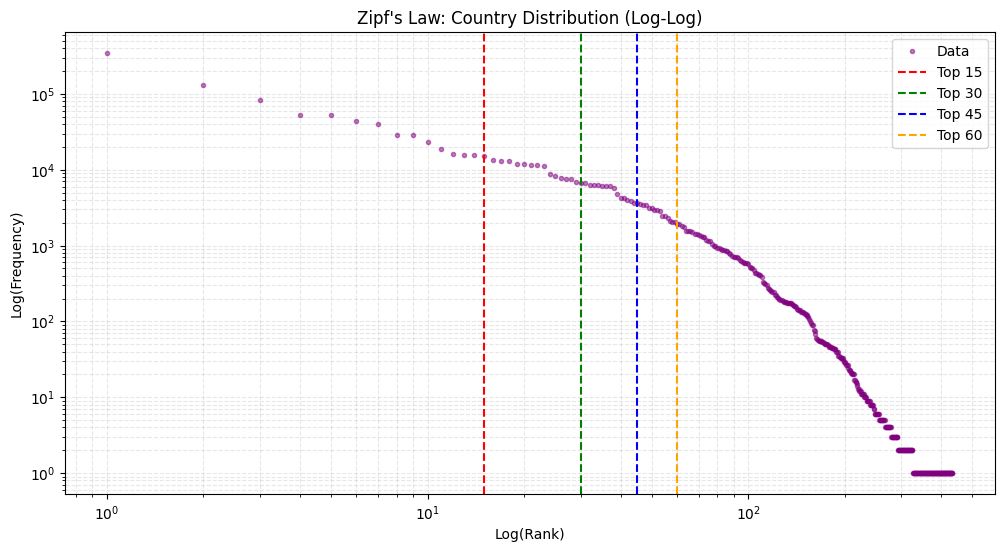

--- Coverage Analysis for Country ---
Top k      | Records Covered | Percentage
---------------------------------------------
15         | 909881          | 73.51%
30         | 1060689         | 85.70%
45         | 1138734         | 92.00%
60         | 1179600         | 95.31%




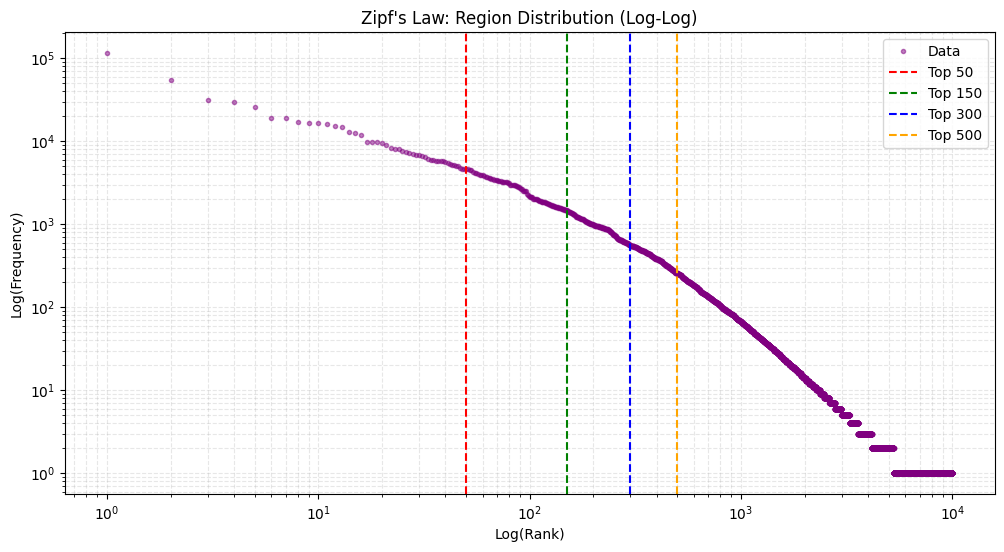

--- Coverage Analysis for Region ---
Top k      | Records Covered | Percentage
---------------------------------------------
50         | 655932          | 53.00%
150        | 907283          | 73.30%
300        | 1042556         | 84.23%
500        | 1120604         | 90.54%




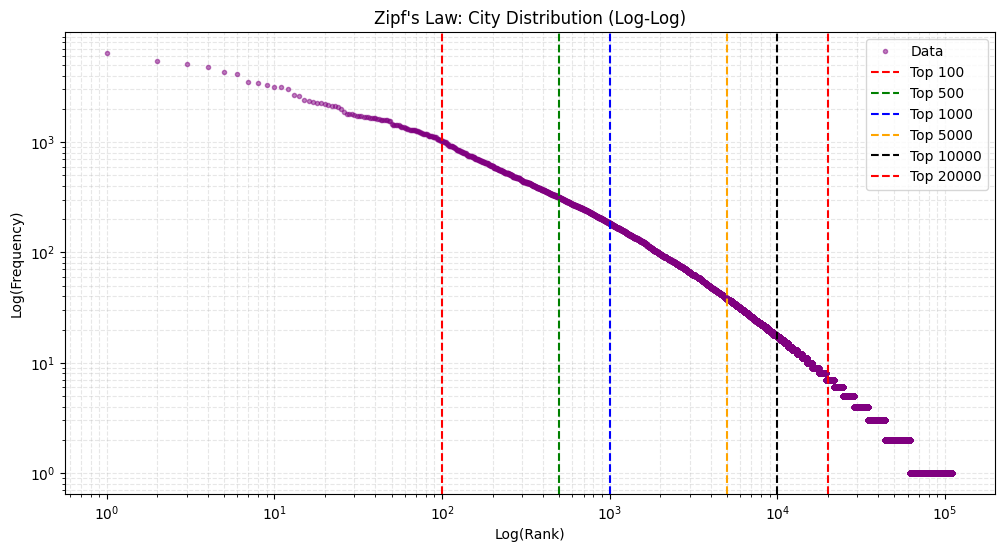

--- Coverage Analysis for City ---
Top k      | Records Covered | Percentage
---------------------------------------------
100        | 181770          | 14.69%
500        | 383576          | 30.99%
1000       | 502193          | 40.57%
5000       | 814035          | 65.77%
10000      | 940929          | 76.02%
20000      | 1051469         | 84.95%




In [0]:
# Country
analyze_zipf_and_coverage(country_counts, "Country", k_values=[15, 30, 45, 60])

# Region
analyze_zipf_and_coverage(region_counts, "Region", k_values=[50, 150, 300, 500])

# City
analyze_zipf_and_coverage(city_counts, "City", k_values=[100, 500, 1000, 5000, 10000, 20000])

Chosen Ks are: \
    1. Country: 30 \
    2. Region: 300 \
    3. City: 2000

In [0]:
def group_infrequent_levels(df, column_name, k):
    """
    Identifies the Top K most frequent levels in a column, 
    lowercases them, and maps the rest to 'other'.
    """
    print(f"Processing column: {column_name} (k={k})")
    
    # 1. Get Top K levels
    top_k_rows = df.groupBy(column_name) \
        .count() \
        .orderBy(col("count").desc()) \
        .limit(k) \
        .collect()
    
    # 2. Create lowercase list of top values
    top_k_list = [str(row[column_name]).lower() for row in top_k_rows if row[column_name] is not None]
    
    # 3. Apply transformation
    df = df.withColumn(
        column_name,
        when(lower(col(column_name)).isin(top_k_list), lower(col(column_name)))
        .otherwise("other")
    )
    return df

In [0]:
global_train_df = group_infrequent_levels(global_train_df, "country", 30)
global_train_df = group_infrequent_levels(global_train_df, "region", 300)
global_train_df = group_infrequent_levels(global_train_df, "city", 2000)

#### Latitude and Longitude

In [0]:
from pyspark.sql.functions import col

# Cast lat and long to double
global_train_df = global_train_df.withColumn("lat", col("lat").cast("double")).withColumn("long", col("long").cast("double"))

### Amenities

In [0]:
from pyspark.sql.types import ArrayType, StructType, StructField, StringType
from pyspark.sql.functions import from_json, explode, col

# 1. Define Schema for parsing
amenities_schema = ArrayType(StructType([
    StructField("group_name", StringType(), True),
    StructField("items", ArrayType(StructType([
        StructField("name", StringType(), True),
        StructField("value", StringType(), True)
    ])))
]))

# 2. Create a temporary view for analysis
amenity_counts = global_train_df.select(from_json(col("amenities"), amenities_schema).alias("parsed")) \
    .select(explode(col("parsed")).alias("group")) \
    .filter(col("group.group_name") != "Not included") \
    .select(explode(col("group.items")).alias("item")) \
    .select(col("item.value").alias("amenity_token")) \
    .filter(col("amenity_token").startswith("SYSTEM_")) \
    .filter(~col("amenity_token").startswith("SYSTEM_NO_")) \
    .groupBy("amenity_token") \
    .count() \
    .orderBy(col("count").desc()) \
    .toPandas()

print(f"Total Unique Valid Amenities: {len(amenity_counts)}")
print("Top 10 Amenities:")
print(amenity_counts.head(10))

Total Unique Valid Amenities: 136
Top 10 Amenities:
            amenity_token    count
0     SYSTEM_REFRIGERATOR  1534336
1  SYSTEM_MAPS_CAR_RENTAL  1468909
2          SYSTEM_HANGERS  1256361
3     SYSTEM_COFFEE_MAKER  1202478
4               SYSTEM_TV  1104303
5            SYSTEM_WI_FI  1069344
6        SYSTEM_HOT_WATER   986156
7     SYSTEM_ROOFTOP_DECK   941737
8          SYSTEM_SHAMPOO   923393
9             SYSTEM_SOAP   883327


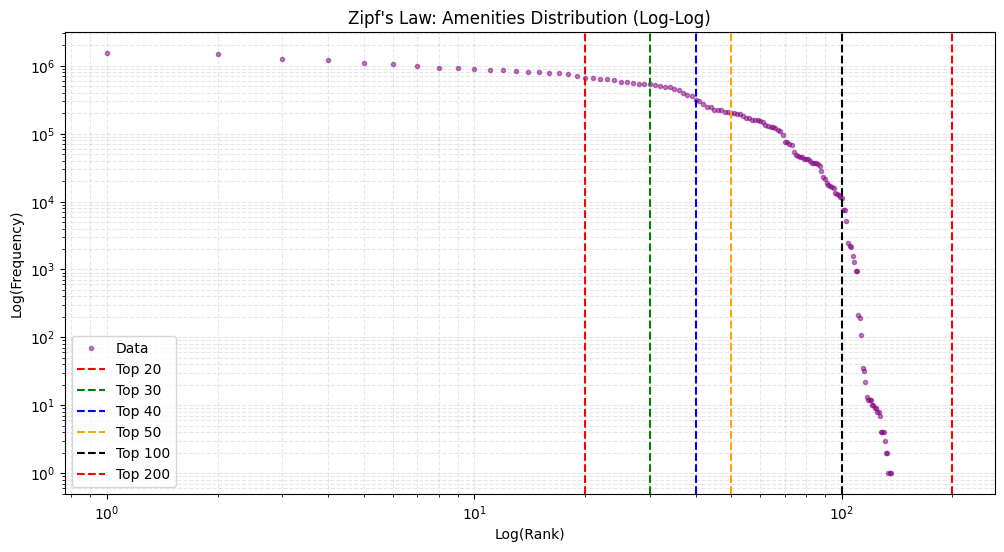

--- Coverage Analysis for Amenities ---
Top k      | Records Covered | Percentage
---------------------------------------------
20         | 19243241        | 53.78%
30         | 25107452        | 70.17%
40         | 29453860        | 82.31%
50         | 31815372        | 88.91%
100        | 35750269        | 99.91%
136        | 35782760        | 100.00%




In [0]:
analyze_zipf_and_coverage(amenity_counts, "Amenities", k_values=[20, 30, 40, 50, 100, 200])

Chosen K=50. Each listing can have this amenity or not.

In [0]:
from pyspark.sql.functions import from_json, col, expr, regexp_replace, size
from pyspark.sql.types import ArrayType, StructType, StructField, StringType

# 1. Prepare the Filter List (Top 50) without 'SYSTEM_'
top_50_clean = [x.replace("SYSTEM_", "") for x in amenity_counts.head(50)["amenity_token"].tolist()]
formatted_top_50 = ",".join([f"'{x}'" for x in top_50_clean])

# 2. Define Schema
amenities_schema = ArrayType(StructType([
    StructField("group_name", StringType(), True),
    StructField("items", ArrayType(StructType([
        StructField("name", StringType(), True),
        StructField("value", StringType(), True)
    ])))
]))

# 3. Parse JSON and Calculate RAW Count
# Change: Reference 'parsed_amenities' instead of 'parsed'
global_train_df = global_train_df.withColumn("parsed_amenities", from_json(col("amenities"), amenities_schema))

# Corrected 'parsed' -> 'parsed_amenities'
raw_count_expr = """size(flatten(transform(filter(parsed_amenities, g -> g.group_name != 'Not included'), g -> g.items)))"""
global_train_df = global_train_df.withColumn("amenities_count_raw", expr(raw_count_expr))

# 4. Extract, Clean, and Filter (Aligned List)
# Corrected 'parsed' -> 'parsed_amenities'
transformation_expr = f"""
            filter(transform(filter(flatten(transform(filter(parsed_amenities, g -> g.group_name != 'Not included'), g -> g.items)),
            i -> i.value like 'SYSTEM_%' AND i.value not like 'SYSTEM_NO_%'), x -> regexp_replace(x.value, 'SYSTEM_', '')), 
            y -> y in ({formatted_top_50}))
            """
global_train_df = global_train_df.withColumn("amenities_list", expr(transformation_expr))

# Verify
global_train_df.select("amenities_count_raw", "amenities_list").show(5, truncate=False)

### Sleeping arrangments

#### Maximal guests allowed

Filter Range: Keep 2 to 12 guests


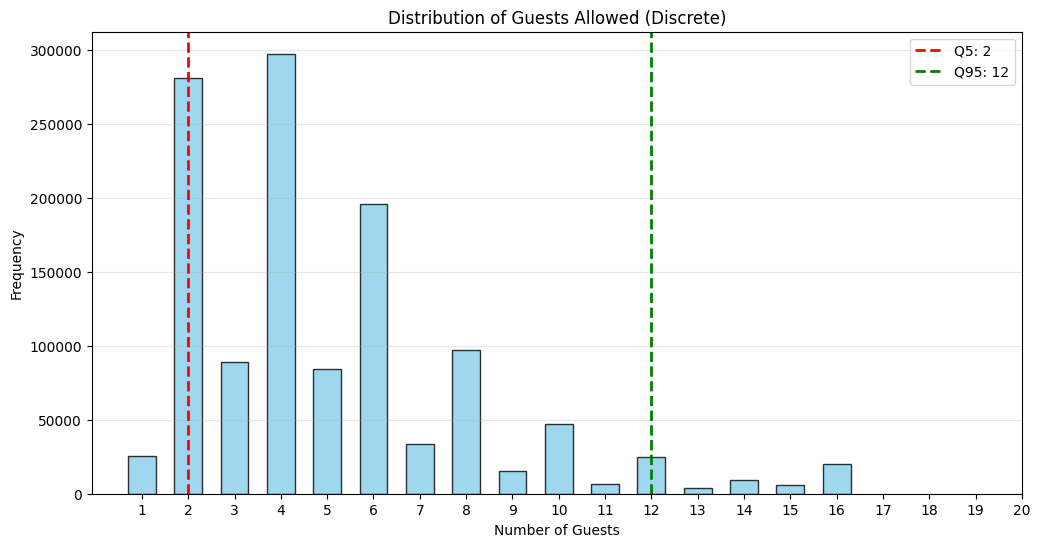

In [0]:
from pyspark.sql.functions import col, percentile_approx, count, when
import matplotlib.pyplot as plt
import numpy as np

# 1. Cast and Stats
global_train_df = global_train_df.withColumn("guests", col("guests").cast("int"))

guest_stats = global_train_df.select(
    percentile_approx("guests", 0.05).alias("q5"),
    percentile_approx("guests", 0.95).alias("q95")
).first()

q5 = guest_stats['q5']
q95 = guest_stats['q95']
print(f"Filter Range: Keep {q5} to {q95} guests")

# 2. Prepare Data for Bar Plot
guest_counts = global_train_df.groupBy("guests").count().orderBy("guests").toPandas()

# Filter out extreme outliers just for the PLOT
plot_data = guest_counts[guest_counts['guests'] <= 20] 

# 3. Bar Plot
plt.figure(figsize=(12, 6))

plt.bar(plot_data['guests'], plot_data['count'], color='skyblue', edgecolor='black', alpha=0.8, width=0.6)

plt.axvline(q5, color='red', linestyle='dashed', linewidth=2, label=f'Q5: {q5}')
plt.axvline(q95, color='green', linestyle='dashed', linewidth=2, label=f'Q95: {q95}')

plt.title('Distribution of Guests Allowed (Discrete)')
plt.xlabel('Number of Guests')
plt.ylabel('Frequency')
plt.xticks(np.arange(1, 21, 1)) # Force integer ticks
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.show()

We filter all listings with guests > 12. This will also be applied for local train and test for consistency.

In [0]:
from pyspark.sql.functions import col

# 1. Cast 'guests' to Integer
global_train_df = global_train_df.withColumn("guests", col("guests").cast("int"))

# 2. Filter: Keep only records where guests <= 12
global_train_df = global_train_df.filter(col("guests") <= 12)

#### Listing Type, Beds, Baths

In [0]:
from pyspark.sql.functions import from_json, col, lower, regexp_extract, element_at
from pyspark.sql.types import ArrayType, StringType

# 1. Parse 'description_items' as a JSON Array
json_schema = ArrayType(StringType())

global_train_df = global_train_df.withColumn("parsed_items", from_json(col("description_items"), json_schema))

# 2. Extract Listing Type (First Item) & Lowercase
global_train_df = global_train_df.withColumn("listing_type", lower(element_at(col("parsed_items"), 1)))

# 3. Extract Num Beds and Num Baths
global_train_df = global_train_df.withColumn("num_beds", regexp_extract(col("description_items"), r"(\d+)\s+bed", 1).cast("int"))
global_train_df = global_train_df.withColumn("num_baths", regexp_extract(col("description_items"), r"([\d\.]+)\s+bath", 1).cast("int"))

# Fill nulls with 0 (assuming missing means 0)
global_train_df = global_train_df.fillna(0, subset=["num_beds", "num_baths"])

# Drop the temp parsed column
global_train_df = global_train_df.drop("parsed_items")

In [0]:
from pyspark.sql.functions import col, percentile_approx

# 1. Calculate Percentiles for Beds and Baths
stats = global_train_df.select(
    percentile_approx("num_beds", 0.05).alias("beds_q5"),
    percentile_approx("num_beds", 0.95).alias("beds_q95"),
    percentile_approx("num_baths", 0.05).alias("baths_q5"),
    percentile_approx("num_baths", 0.95).alias("baths_q95")
).first()

beds_q5, beds_q95 = stats['beds_q5'], stats['beds_q95']
baths_q5, baths_q95 = stats['baths_q5'], stats['baths_q95']

print(f"Beds Range (Q5-Q95): {beds_q5} - {beds_q95}")
print(f"Baths Range (Q5-Q95): {baths_q5} - {baths_q95}")

# 2. Aggregate Data for Plotting (Bring only counts to Pandas)
beds_counts = global_train_df.groupBy("num_beds").count().orderBy("num_beds").toPandas()
baths_counts = global_train_df.groupBy("num_baths").count().orderBy("num_baths").toPandas()
type_counts = global_train_df.groupBy("listing_type").count().orderBy(col("count").desc()).toPandas()

Beds Range (Q5-Q95): 1 - 6
Baths Range (Q5-Q95): 0 - 3


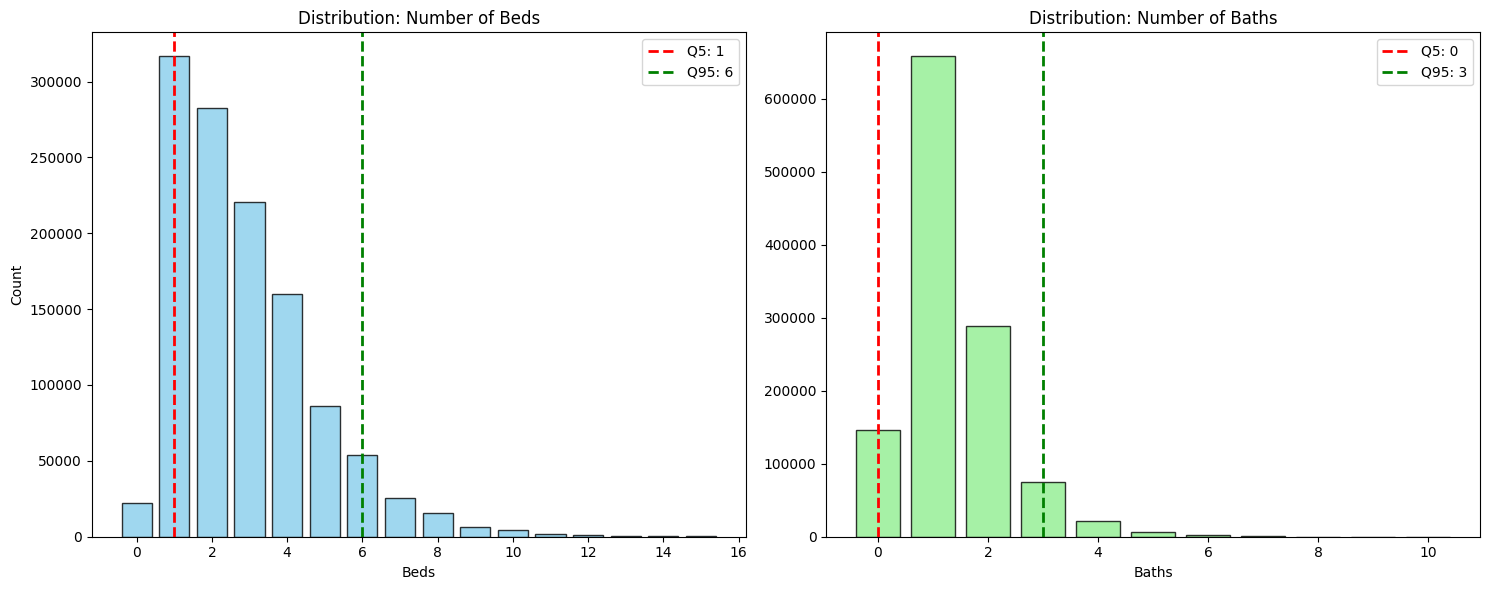

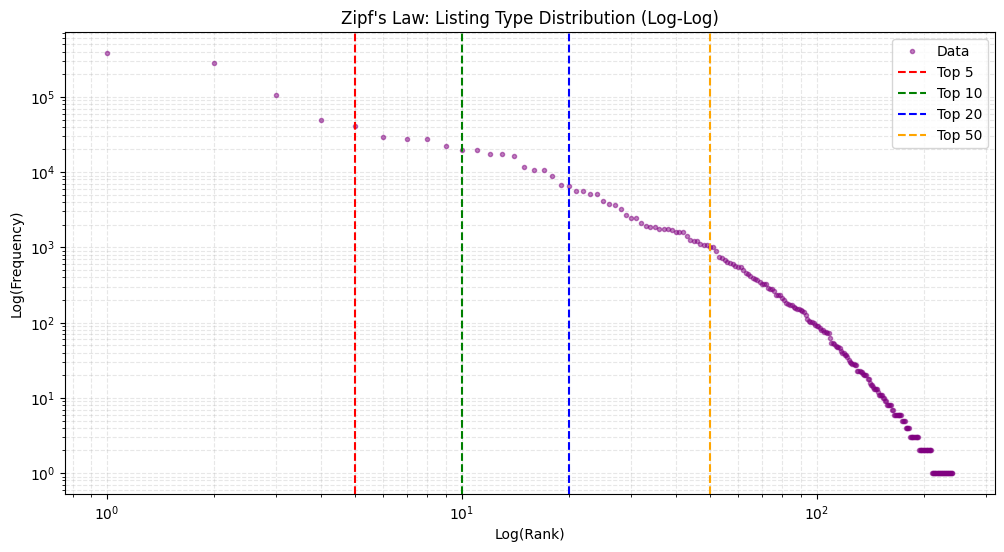

--- Coverage Analysis for Listing Type ---
Top k      | Records Covered | Percentage
---------------------------------------------
5          | 854080          | 71.24%
10         | 981638          | 81.88%
20         | 1107245         | 92.36%
50         | 1179991         | 98.43%




In [0]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# --- 1. PLOT BEDS AND BATHS (Distribution Analysis) ---
# We use a 1x2 layout for the simple distribution charts
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Plot A: Num Beds
plot_beds = beds_counts[beds_counts['num_beds'] <= 15]
axes[0].bar(plot_beds['num_beds'], plot_beds['count'], color='skyblue', edgecolor='black', alpha=0.8)
axes[0].axvline(beds_q5, color='red', linestyle='--', linewidth=2, label=f'Q5: {beds_q5}')
axes[0].axvline(beds_q95, color='green', linestyle='--', linewidth=2, label=f'Q95: {beds_q95}')
axes[0].set_title('Distribution: Number of Beds')
axes[0].set_xlabel('Beds')
axes[0].set_ylabel('Count')
axes[0].legend()

# Plot B: Num Baths
plot_baths = baths_counts[baths_counts['num_baths'] <= 10]
axes[1].bar(plot_baths['num_baths'], plot_baths['count'], color='lightgreen', edgecolor='black', alpha=0.8)
axes[1].axvline(baths_q5, color='red', linestyle='--', linewidth=2, label=f'Q5: {baths_q5}')
axes[1].axvline(baths_q95, color='green', linestyle='--', linewidth=2, label=f'Q95: {baths_q95}')
axes[1].set_title('Distribution: Number of Baths')
axes[1].set_xlabel('Baths')
axes[1].legend()

plt.tight_layout()
plt.show()

# --- 2. PLOT LISTING TYPE (ZIPF) ---
analyze_zipf_and_coverage(
    pdf=type_counts, 
    name="Listing Type", 
    k_values=[5, 10, 20, 50]
)

We filter num_beds <= 8, and num baths <= 4\
For listing type we choose the most common 10 by Zipf law.

In [0]:
from pyspark.sql.functions import col, when, desc

# 1. Identify Top 10 from your existing Zipf analysis (FAST)
# This uses the 'type_counts' Pandas DataFrame you created earlier
top_10_list = type_counts['listing_type'].head(10).tolist()
print(f"Zipf Top 10 Listing Types: {top_10_list}")

# 2. Overwrite the existing column in global_train_df
global_train_df = global_train_df.withColumn("listing_type", when(col("listing_type").isin(top_10_list), col("listing_type")).otherwise("other"))

# 3. Filter Beds and Baths
before_count = global_train_df.count()

global_train_df = global_train_df.filter((col("num_beds") <= 8) & (col("num_baths") <= 4))

Zipf Top 10 Listing Types: ['entire rental unit', 'entire home', 'entire condo', 'private room in home', 'entire cabin', 'entire villa', 'private room in rental unit', 'entire cottage', 'entire townhouse', 'private room in bed and breakfast']


### Avalibilty

#### Avalibale dates

In [0]:
from pyspark.sql.functions import col, size, split, regexp_replace, when

# 1. Clean the string and split into an array to get the count
global_train_df = global_train_df.withColumn(
    "availability_365", 
    when(col("available_dates") == "[]", 0) # Handle empty list case
    .otherwise(size(split(regexp_replace(col("available_dates"), r"[\[\]']", ""), ",\s*")))
)

#### Is listing avaliable

In [0]:
from pyspark.sql.functions import col

# 1. Show unique values
print("Unique Availability Values:")
global_train_df.select("availability").distinct().orderBy("availability").show(n=20, truncate=False)

# 2. Show distribution
print("\nAvailability Distribution:")
global_train_df.groupBy("availability") \
    .count() \
    .orderBy(col("count").desc()) \
    .show(n=20, truncate=False)

Unique Availability Values:
+------------+
|availability|
+------------+
|NULL        |
|false       |
|true        |
+------------+


Availability Distribution:
+------------+-------+
|availability|count  |
+------------+-------+
|true        |1146517|
|false       |29826  |
|NULL        |2      |
+------------+-------+



In [0]:
# 1. Filter to keep only active listings (availability == true)
# We assume 'false' listings are inactive/blocked and might have stale prices
global_train_df = global_train_df.filter(col("availability") == True)

# 2. Drop the column (since it is now 100% 'true', it has no predictive power)
global_train_df = global_train_df.drop("availability")

### Casting

In [0]:
global_train_df = global_train_df.withColumn("host_number_of_reviews", col("host_number_of_reviews").cast("int"))
global_train_df = global_train_df.withColumn("hosts_year", col("hosts_year").cast("int"))
global_train_df = global_train_df.withColumn("host_response_rate", col("host_response_rate").cast("int"))
global_train_df = global_train_df.withColumn("property_number_of_reviews", col("property_number_of_reviews").cast("int"))

In [0]:
from pyspark.sql.functions import col
# show the unique values (sorted)
print("Unique is_supperhost:")
global_train_df.select("is_supperhost").distinct().orderBy("is_supperhost").show(n=100, truncate=False)

Unique is_supperhost:
+-------------+
|is_supperhost|
+-------------+
|false        |
|true         |
+-------------+



In [0]:
global_train_df = global_train_df.withColumn("is_supperhost", col("is_supperhost").cast("boolean").cast("int"))

In [0]:
from pyspark.sql.functions import col

# 1. Show unique values
print("Unique Pets Allowed Values:")
global_train_df.select("pets_allowed").distinct().orderBy("pets_allowed").show(n=20, truncate=False)

# 2. Show distribution
print("\nPets Allowed Distribution:")
global_train_df.groupBy("pets_allowed").count().orderBy(col("count").desc()).show(n=20, truncate=False)

Unique Pets Allowed Values:
+------------+
|pets_allowed|
+------------+
|NULL        |
|false       |
|true        |
+------------+


Pets Allowed Distribution:
+------------+------+
|pets_allowed|count |
+------------+------+
|false       |681905|
|true        |340512|
|NULL        |124100|
+------------+------+



In [0]:
from pyspark.sql.functions import col, when

# 1. Convert to Binary Integer
# We treat 'true' as 1, everything else (false or NULL) as 0
global_train_df = global_train_df.withColumn("pets_allowed", when(col("pets_allowed") == "true", 1).otherwise(0))

In [0]:
global_train_df = global_train_df.fillna(0, subset=["property_number_of_reviews"])

### Drop unused attributes

In [0]:
display(global_train_df.limit(10))

In [0]:
global_train_df = global_train_df.drop("price", "total_price", "pricing_details", "discount", "currency", "category_rating", "parsed_ratings",
                                       "category_rating", "parsed_ratings", "location", "breadcrumbs", "parsed_amenities", "amenities", "description_items", "details", "highlights", "is_guest_favorite", "description_html", "location_details_html", "seller_info", "name", "image", "images", "url","listing_name", "final_url", "category", "arrangement_details", "travel_details", "postcode_map_url", "host_image", "host_details", "parsed_dates", "clean_array")

### Final Cleaning result

In [0]:
display(global_train_df.limit(10))

## Local Data Cleaning

In [0]:
display(local_train_df.limit(5))

### Pricing

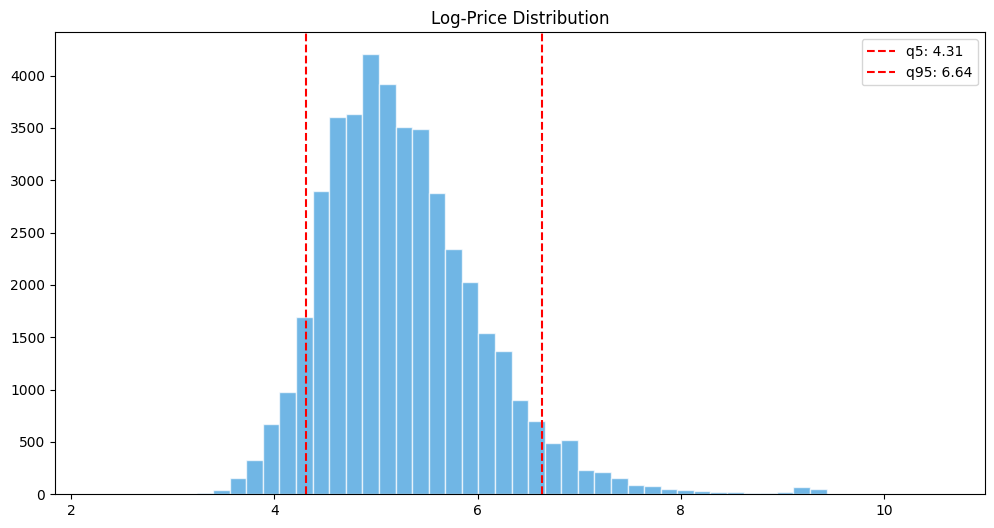

In [0]:
from pyspark.sql import functions as F
import matplotlib.pyplot as plt

# 1. Get quantiles (approximated)
q5, q95 = local_train_df.stat.approxQuantile("log_price", [0.05, 0.95], 0.01)

# 2. Plot log-price histogram
num_bins = 50
min_val, max_val = local_train_df.select(F.min("log_price"), F.max("log_price")).first()
bin_width = (max_val - min_val) / num_bins

hist_df = (local_train_df
           .select(((F.col("log_price") - min_val) / bin_width).cast("int").alias("bin"))
           .groupBy("bin")
           .count()
           .orderBy("bin")
           .toPandas())

plt.figure(figsize=(12, 6))
plt.bar(hist_df["bin"] * bin_width + min_val, hist_df["count"], width=bin_width, 
        color='#3498db', edgecolor='white', alpha=0.7)

plt.axvline(q5, color='red', linestyle='--', label=f'q5: {q5:.2f}')
plt.axvline(q95, color='red', linestyle='--', label=f'q95: {q95:.2f}')
plt.title('Log-Price Distribution')
plt.legend()
plt.show()

Log-pricing range should match the global dataset

In [0]:
local_train_df = local_train_df.filter((col("log_price") >= 2) & (col("log_price") <= 7))

### Host Related

#### Years on Airbnb

In [0]:
from pyspark.sql.functions import col, year, to_date, lit

# Overwrite the 'host_since' column with the calculated years
local_train_df = local_train_df.withColumn("host_since", (lit(2026) - year(to_date(col("host_since"), "yyyy-MM-dd"))).cast("int"))

# Fill nulls with 0
local_train_df = local_train_df.fillna(0, subset=["host_since"])
local_train_df.select("host_since").show(5)

+----------+
|host_since|
+----------+
|        18|
|        16|
|        16|
|        16|
|        15|
+----------+
only showing top 5 rows



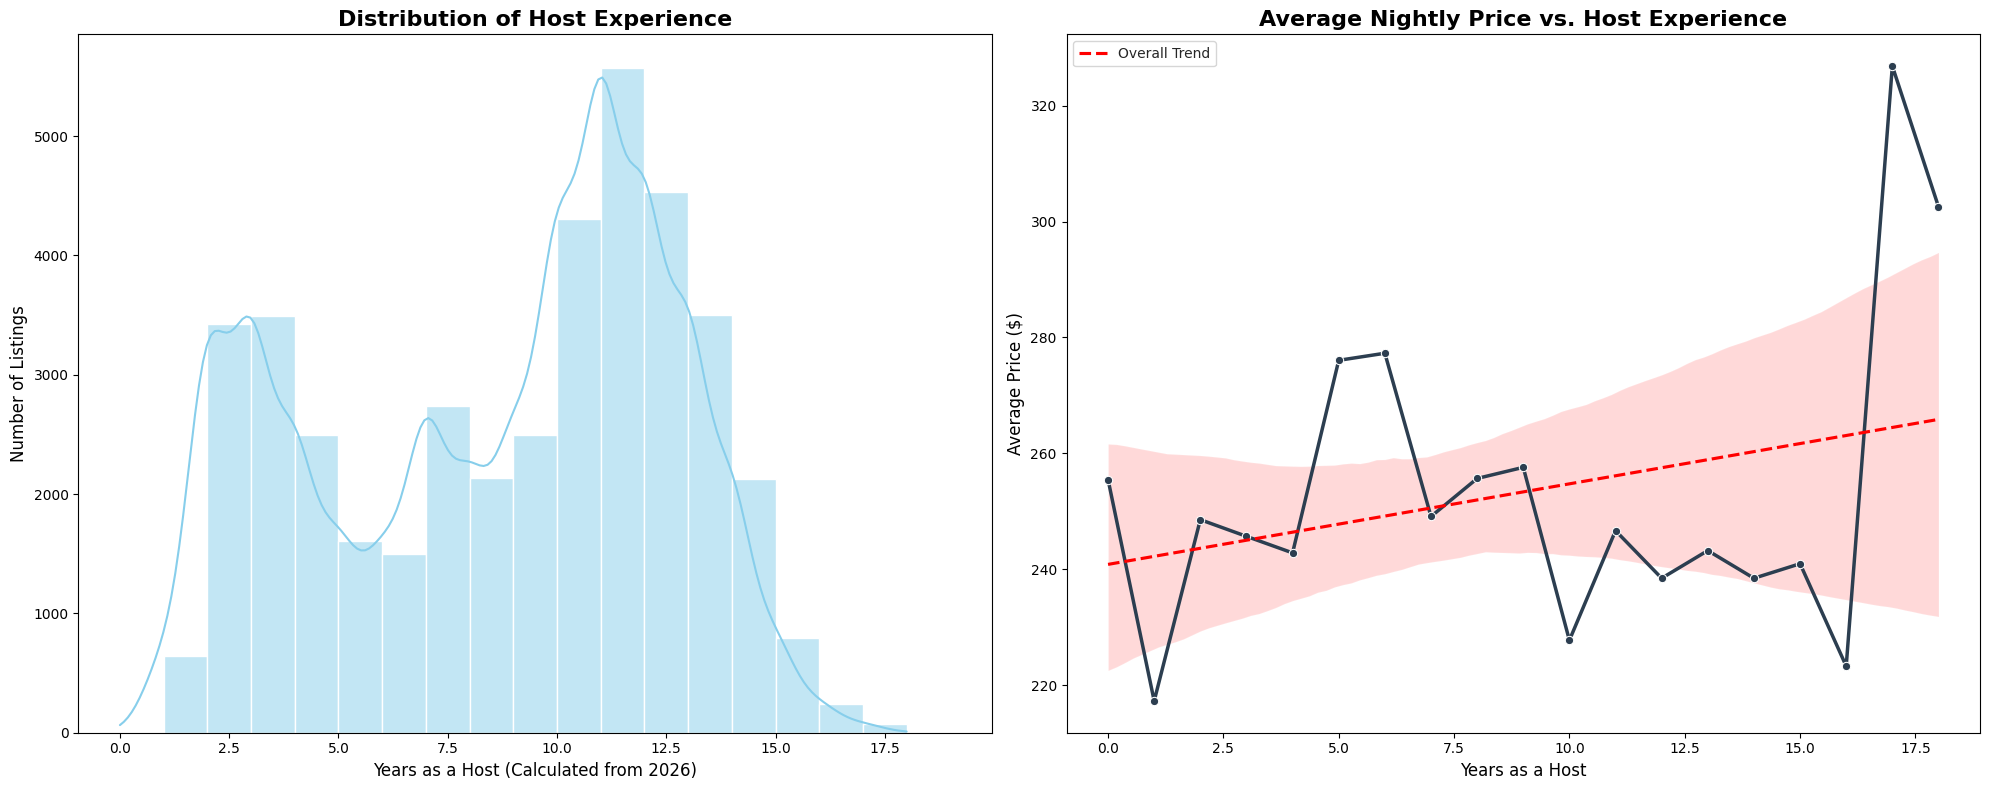

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql.functions import col, avg, exp

# --- 1. PREPARE DATA ---
# Note: We use exp(log_price) to show real dollars
pdf_host_analysis = local_train_df.select(col("host_since"), exp(col("log_price")).alias("real_price")).toPandas()

# Calculate average price per year for the trend line
price_trend = pdf_host_analysis.groupby("host_since")["real_price"].mean().reset_index()

# --- 2. VISUALIZATION ---
fig, axes = plt.subplots(1, 2, figsize=(20, 8))
sns.set_style("whitegrid")

# Plot A: Histogram of Host Since (Distribution)
sns.histplot(pdf_host_analysis["host_since"], bins=range(0, int(pdf_host_analysis["host_since"].max()) + 2), color="skyblue", kde=True, ax=axes[0])
axes[0].set_title("Distribution of Host Experience", fontsize=16, fontweight='bold')
axes[0].set_xlabel("Years as a Host (Calculated from 2026)", fontsize=12)
axes[0].set_ylabel("Number of Listings", fontsize=12)

# Plot B: Average Price vs. Year
sns.lineplot(data=price_trend, x="host_since", y="real_price", marker="o", linewidth=2.5, color="#2c3e50", ax=axes[1])
# Add a regression trend line to see the overall direction
sns.regplot(data=price_trend, x="host_since", y="real_price", scatter=False, color="red", line_kws={"linestyle":"--"}, ax=axes[1],label="Overall Trend")

axes[1].set_title("Average Nightly Price vs. Host Experience", fontsize=16, fontweight='bold')
axes[1].set_xlabel("Years as a Host", fontsize=12)
axes[1].set_ylabel("Average Price ($)", fontsize=12)
axes[1].legend()

plt.tight_layout()
plt.show()

#### Response time

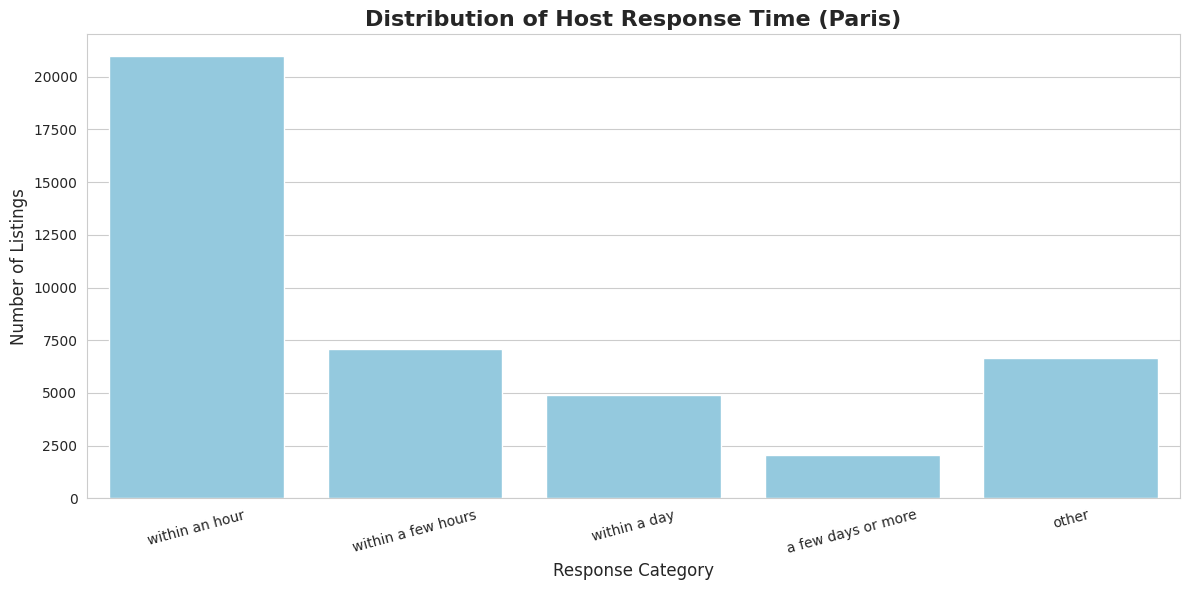

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns

# Convert to Pandas and replace "N/A" string with "other"
pdf_response = local_train_df.select("host_response_time").toPandas()
pdf_response["host_response_time"] = pdf_response["host_response_time"].replace("N/A", "other")
pdf_response["host_response_time"] = pdf_response["host_response_time"].fillna("other")

plt.figure(figsize=(12, 6))
sns.set_style("whitegrid")

# Updated order to include "Missing"
order = ["within an hour", "within a few hours", "within a day", "a few days or more", "other"]

sns.countplot(data=pdf_response, x="host_response_time", order=order, color="skyblue")

plt.title("Distribution of Host Response Time (Paris)", fontsize=16, fontweight='bold')
plt.xlabel("Response Category", fontsize=12)
plt.ylabel("Number of Listings", fontsize=12)
plt.xticks(rotation=15)

plt.tight_layout()
plt.show()

### Property Related

#### Property type

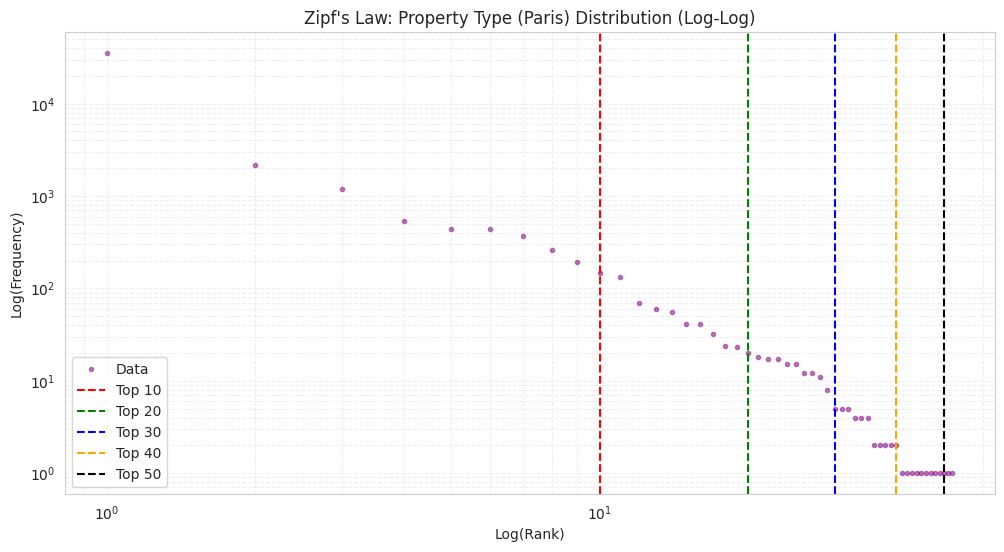

--- Coverage Analysis for Property Type (Paris) ---
Top k      | Records Covered | Percentage
---------------------------------------------
10         | 41024           | 98.39%
20         | 41523           | 99.58%
30         | 41653           | 99.89%
40         | 41685           | 99.97%
50         | 41695           | 100.00%




In [0]:
from pyspark.sql.functions import col

# 1. Aggregate counts in Spark and convert to Pandas
prop_type_counts = local_train_df.groupBy("property_type") \
    .count() \
    .orderBy(col("count").desc()) \
    .toPandas()

# 2. Use your existing function
# This will generate the Zipf plot and the Coverage Table automatically
analyze_zipf_and_coverage(
    pdf=prop_type_counts, 
    name="Property Type (Paris)", 
    k_values=[10, 20, 30, 40, 50]
)

Chosen k=10.

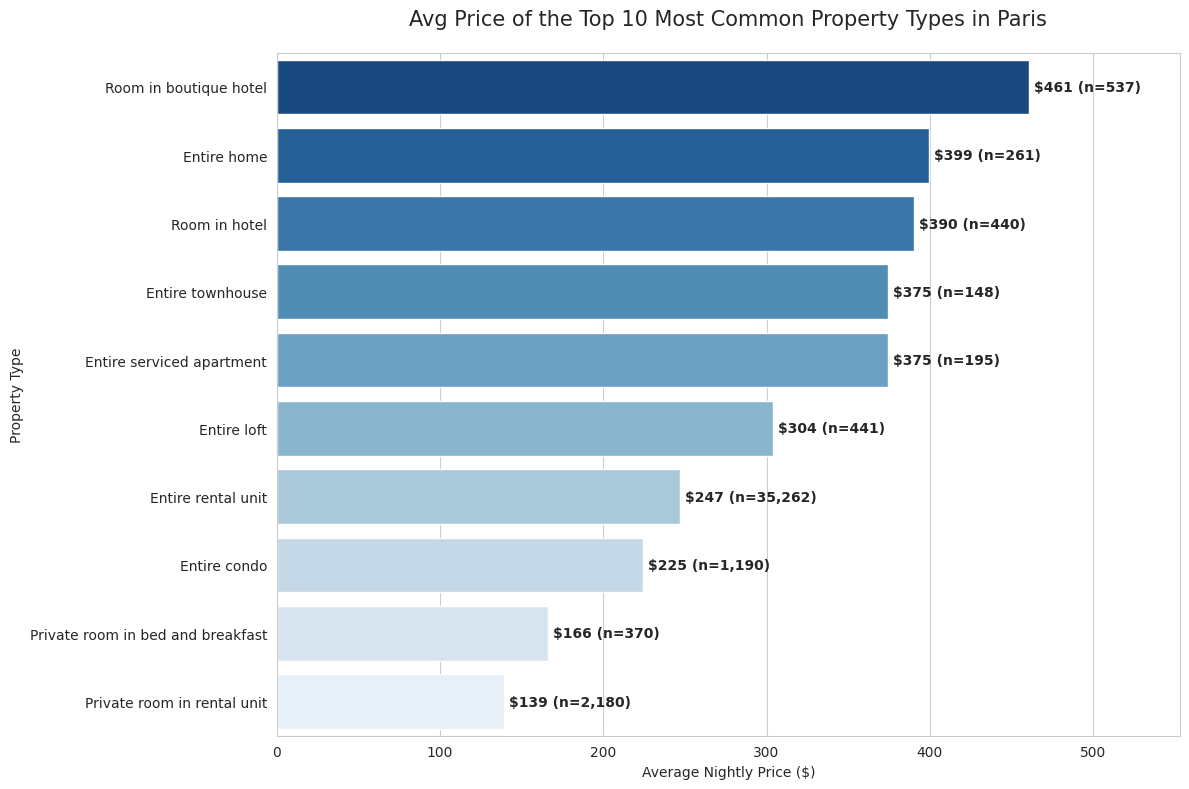

In [0]:
from pyspark.sql.functions import col, avg, exp, count, desc
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Single-pass Aggregation: Calculate volume and price together
pdf_top_10 = local_train_df.groupBy("property_type") \
    .agg(
        avg(exp(col("log_price"))).alias("avg_price"),
        count("*").alias("volume")
    ) \
    .orderBy(desc("volume")) \
    .limit(10) \
    .toPandas()

# 2. Sort by price in Pandas (for a cleaner bar chart)
pdf_top_10 = pdf_top_10.sort_values("avg_price", ascending=False)

# 3. Visualization
plt.figure(figsize=(12, 8))
sns.set_style("whitegrid")

# Create plot
barplot = sns.barplot(data=pdf_top_10, x="avg_price", y="property_type", palette="Blues_r")

# Add Labels: Price and Volume
# We iterate directly through the rows to ensure labels match the sorted bars
for i, row in enumerate(pdf_top_10.itertuples()):
    plt.text(
        row.avg_price + 3, # Offset
        i,                 # Y-position (0, 1, 2...)
        f"${row.avg_price:,.0f} (n={row.volume:,})", 
        va="center", 
        fontweight='bold'
    )

plt.title("Avg Price of the Top 10 Most Common Property Types in Paris", fontsize=15, pad=20)
plt.xlabel("Average Nightly Price ($)")
plt.ylabel("Property Type")
plt.xlim(0, pdf_top_10['avg_price'].max() * 1.2) # Add space for labels
plt.tight_layout()
plt.show()

In [0]:
from pyspark.sql.functions import col, when, lower

# 1. Grab the Top 10 names from your previous analysis and lowercase them
top_10_list = [str(t).lower() for t in type_counts['listing_type'].head(10).tolist()]

# 2. Update local_train_df: 
#    - Lowercase the original 'property_type'
#    - Check if it's in the top 10
#    - Overwrite it (or create 'listing_type' and drop 'property_type')
local_train_df = local_train_df.withColumn(
    "listing_type",
    when(lower(col("property_type")).isin(top_10_list), lower(col("property_type")))
    .otherwise("other")
).drop("property_type")

# 3. Quick Check
print(f"Top 10 Categories being kept: {top_10_list}")
local_train_df.groupBy("listing_type").count().orderBy("count", ascending=False).show()

Top 10 Categories being kept: ['entire rental unit', 'entire home', 'entire condo', 'private room in home', 'entire cabin', 'entire villa', 'private room in rental unit', 'entire cottage', 'entire townhouse', 'private room in bed and breakfast']
+--------------------+-----+
|        listing_type|count|
+--------------------+-----+
|  entire rental unit|35262|
|               other| 2212|
|private room in r...| 2180|
|        entire condo| 1190|
|private room in b...|  370|
|         entire home|  261|
|    entire townhouse|  148|
|private room in home|   70|
|        entire villa|    4|
+--------------------+-----+



#### Avalability

In [0]:
from pyspark.sql.functions import col, count, when

# 1. Calculate the percentage of 't' (true) in has_availability
stats = local_train_df.select(
    count(when(col("has_availability") == "t", True)).alias("available_t"),
    count("*").alias("total")
).collect()[0]

avail_t_count = stats["available_t"]
total_count = stats["total"]
avail_percentage = (avail_t_count / total_count) * 100

print(f"--- has_availability Analysis ---")
print(f"Total Listings:          {total_count:,}")
print(f"Available Listings (t):  {avail_t_count:,}")
print(f"Percentage Available:    {avail_percentage:.2f}%")

# 2. Apply the < 5% logic
if avail_percentage >= 95:
    print("⚠️ Availability is extremely low (< 5%). Filtering to keep only 't' records.")
    local_train_df = local_train_df.filter(col("has_availability") == "t")
else:
    print("✅ Availability is above 5%. No filtering required based on your criteria.")

local_train_df = local_train_df.drop("has_availability") # No longer needed because all records has the same value

--- has_availability Analysis ---
Total Listings:          41,697
Available Listings (t):  40,656
Percentage Available:    97.50%
⚠️ Availability is extremely low (< 5%). Filtering to keep only 't' records.


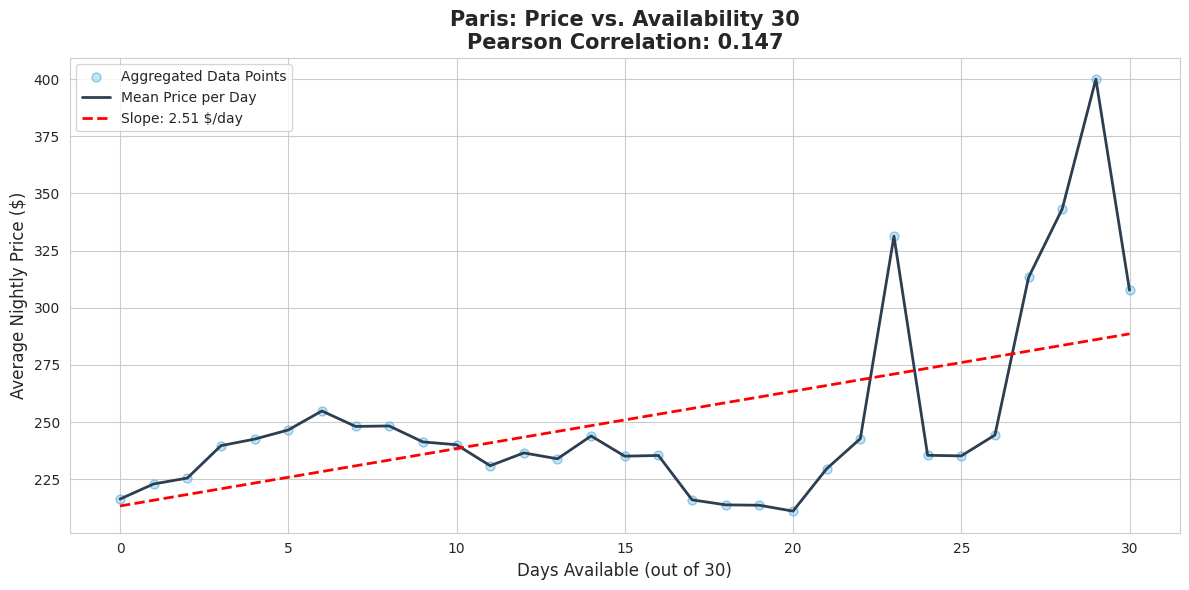

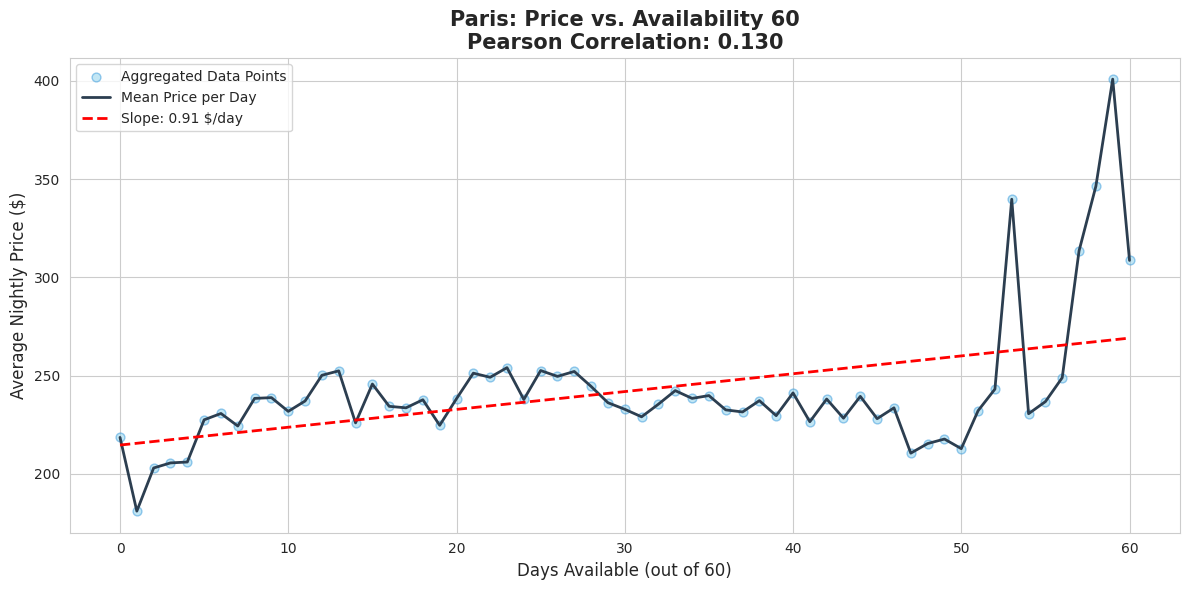

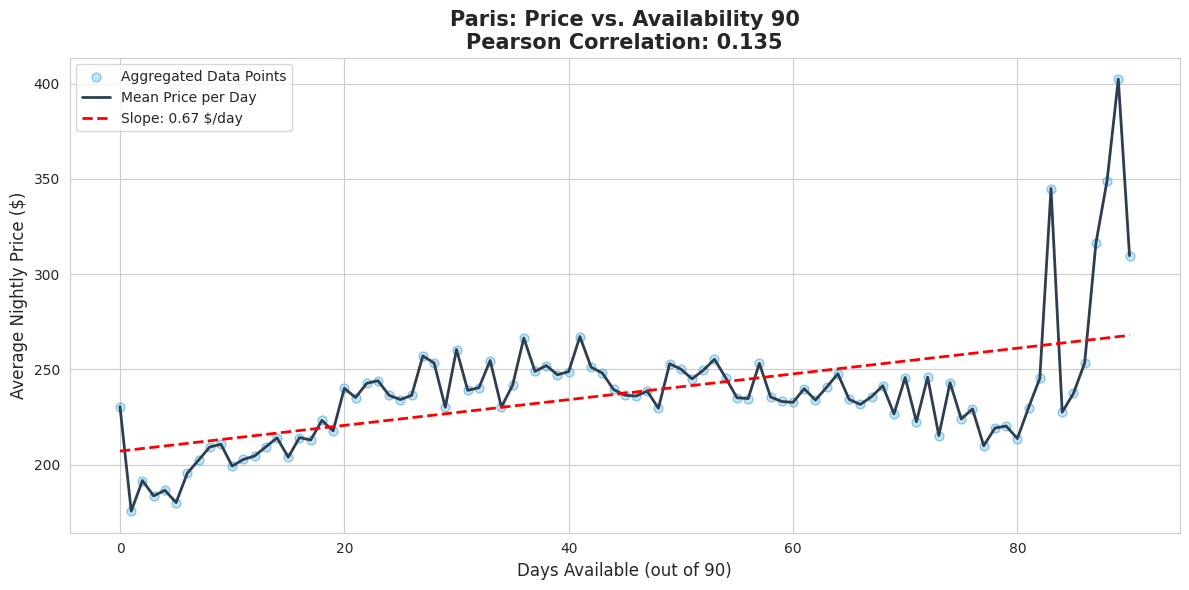

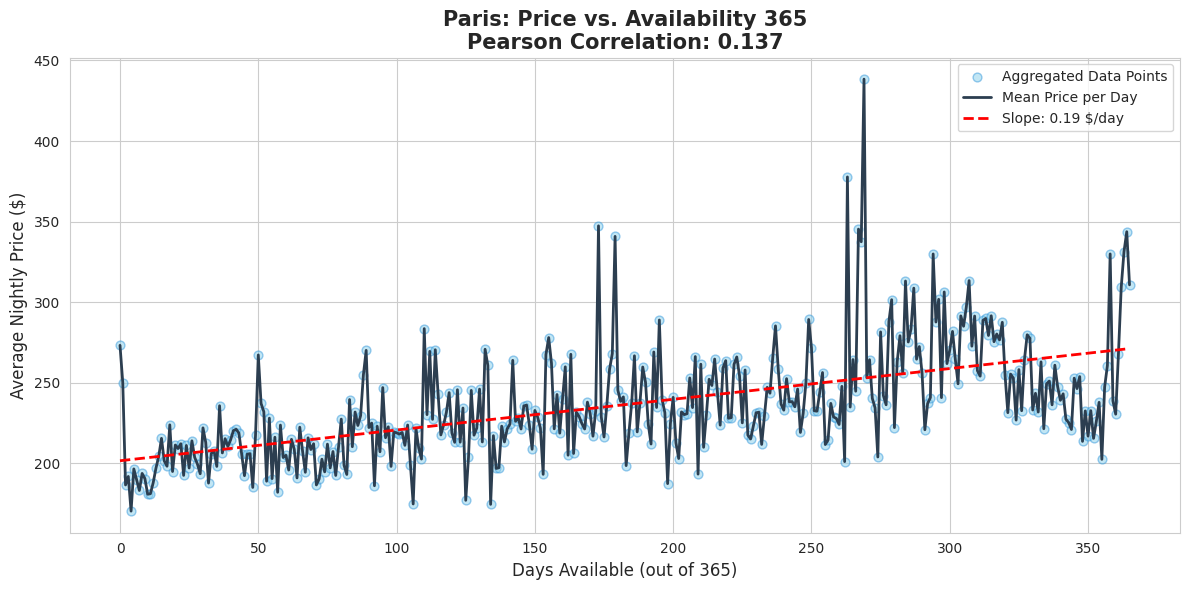

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from pyspark.sql.functions import col, avg, count, exp

# --- 1. SET THE COLUMNS ---
avail_cols = ["availability_30", "availability_60", "availability_90", "availability_365"]

# Prepare a base dataframe with the real price
df_with_price = local_train_df.withColumn("price_real", exp(col("log_price")).cast("float"))

for target_col in avail_cols:
    # --- 2. STATISTICAL CORRELATION ---
    # Calculate correlation for the specific window
    correlation = df_with_price.stat.corr(target_col, "price_real")
    
    # --- 3. AGGREGATE FOR TREND ---
    # We group by the availability (e.g. 0 to 30) to see the price behavior
    trend_data = df_with_price.groupBy(target_col).agg(
        avg("price_real").alias("avg_price"),
        count("*").alias("row_count")
    ).filter(col("row_count") > 5).orderBy(target_col).toPandas()

    # --- 4. PLOTTING ---
    plt.figure(figsize=(12, 6))
    sns.set_style("whitegrid")

    # Plot A: Aggregated Scatter (Skyblue as requested)
    plt.scatter(
        trend_data[target_col], 
        trend_data["avg_price"], 
        alpha=0.5, 
        s=40, 
        color="skyblue", 
        edgecolor="#3498db",
        label="Aggregated Data Points"
    )

    # Plot B: The Average Trend Line
    sns.lineplot(
        data=trend_data, 
        x=target_col, 
        y="avg_price", 
        linewidth=2, 
        color="#2c3e50",
        label="Mean Price per Day"
    )

    # Plot C: Linear Regression
    if not trend_data.empty:
        z = np.polyfit(trend_data[target_col], trend_data["avg_price"], 1)
        p = np.poly1d(z)
        plt.plot(trend_data[target_col], p(trend_data[target_col]), "r--", linewidth=2, 
                 label=f"Slope: {z[0]:.2f} $/day")

    # Labels and Formatting
    plt.title(f"Paris: Price vs. {target_col.replace('_', ' ').capitalize()}\nPearson Correlation: {correlation:.3f}", 
              fontsize=15, fontweight='bold')
    plt.xlabel(f"Days Available (out of {target_col.split('_')[1]})", fontsize=12)
    plt.ylabel("Average Nightly Price ($)", fontsize=12)
    plt.legend()
    
    plt.tight_layout()
    plt.show()

#### Reviews

--- Review Statistics (Local Paris Dataset) ---
Attribute                 | Nulls      | Zeros     
--------------------------------------------------
number_of_reviews         | 0          | 7563      
number_of_reviews_ltm     | 0          | 11796     
number_of_reviews_l30d    | 0          | 23485     


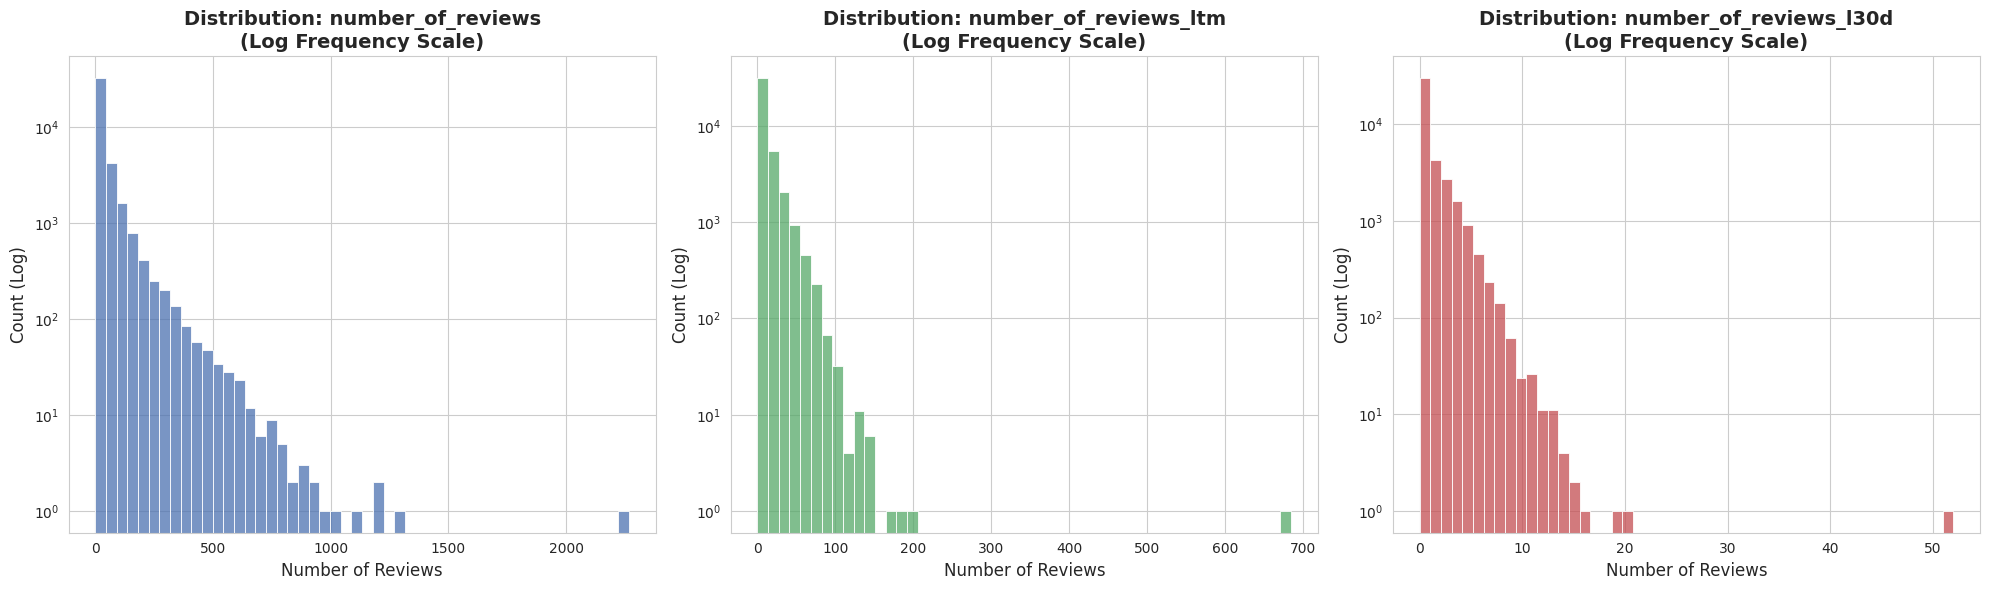

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql.functions import col, count, when, isnull

# List of columns to analyze
review_cols = ["number_of_reviews", "number_of_reviews_ltm", "number_of_reviews_l30d"]

# --- 1. COUNT NULLS AND ZEROS IN SPARK ---
# We do this aggregation in Spark before bringing data to Pandas
stats_df = local_train_df.select([
    count(when(isnull(c), c)).alias(f"{c}_nulls") for c in review_cols
] + [
    count(when(col(c) == 0, c)).alias(f"{c}_zeros") for c in review_cols
])

stats = stats_df.collect()[0]

print("--- Review Statistics (Local Paris Dataset) ---")
print(f"{'Attribute':<25} | {'Nulls':<10} | {'Zeros':<10}")
print("-" * 50)
for c in review_cols:
    n_nulls = stats[f"{c}_nulls"]
    n_zeros = stats[f"{c}_zeros"]
    print(f"{c:<25} | {n_nulls:<10} | {n_zeros:<10}")

# --- 2. PREPARE DATA FOR PLOTTING ---
# Convert to Pandas for visualization
pdf_reviews = local_train_df.select(review_cols).toPandas()

# --- 3. PLOT DISTRIBUTIONS (3 HISTOGRAMS SIDE-BY-SIDE) ---
fig, axes = plt.subplots(1, 3, figsize=(20, 6))
sns.set_style("whitegrid")

colors = ["#4C72B0", "#55A868", "#C44E52"]

for i, col_name in enumerate(review_cols):
    sns.histplot(pdf_reviews[col_name], bins=50, ax=axes[i], color=colors[i], kde=False)
    
    # Using log scale for the Y-axis because the number of 0s and low counts 
    # often dwarfs the rest of the distribution, making it hard to see.
    axes[i].set_yscale('log')
    
    axes[i].set_title(f"Distribution: {col_name}\n(Log Frequency Scale)", fontsize=14, fontweight='bold')
    axes[i].set_xlabel("Number of Reviews", fontsize=12)
    axes[i].set_ylabel("Count (Log)", fontsize=12)

plt.tight_layout()
plt.show()

In [0]:
local_train_df = local_train_df.filter(col("number_of_reviews") <= 1500)
local_train_df = local_train_df.filter(col("number_of_reviews_ltm") <= 200)
local_train_df = local_train_df.filter(col("number_of_reviews_l30d") <= 25)

### Location

#### Paris Neighborhoods

In [0]:
from pyspark.sql.functions import col, count, desc, sum as spark_sum, row_number
from pyspark.sql.window import Window

# --- 1. SET THE CLEANSED COLUMN ---
neigh_col = "neighbourhood_cleansed"

# --- 2. AGGREGATE ---
df_neigh_counts = (
    local_train_df
    .filter(col(neigh_col).isNotNull())
    .groupBy(neigh_col)
    .agg(count("*").alias("listing_count"))
    .orderBy(desc("listing_count"))
)

# --- 3. CALCULATE ZIPF RANK & COVERAGE ---
window_spec = Window.orderBy(desc("listing_count"))
total_paris_records = global_train_df.count()

df_zipf_neigh = (
    df_neigh_counts
    .withColumn("rank", row_number().over(window_spec))
    .withColumn("running_total", spark_sum("listing_count").over(Window.partitionBy().orderBy("rank")))
    .withColumn("cumulative_percentage", (col("running_total") / total_paris_records) * 100)
)

# Collect to Pandas for Plotting
pdf_zipf = df_zipf_neigh.toPandas()
print(f"Total Official Districts in Paris: {len(pdf_zipf)}")

Total Official Districts in Paris: 20


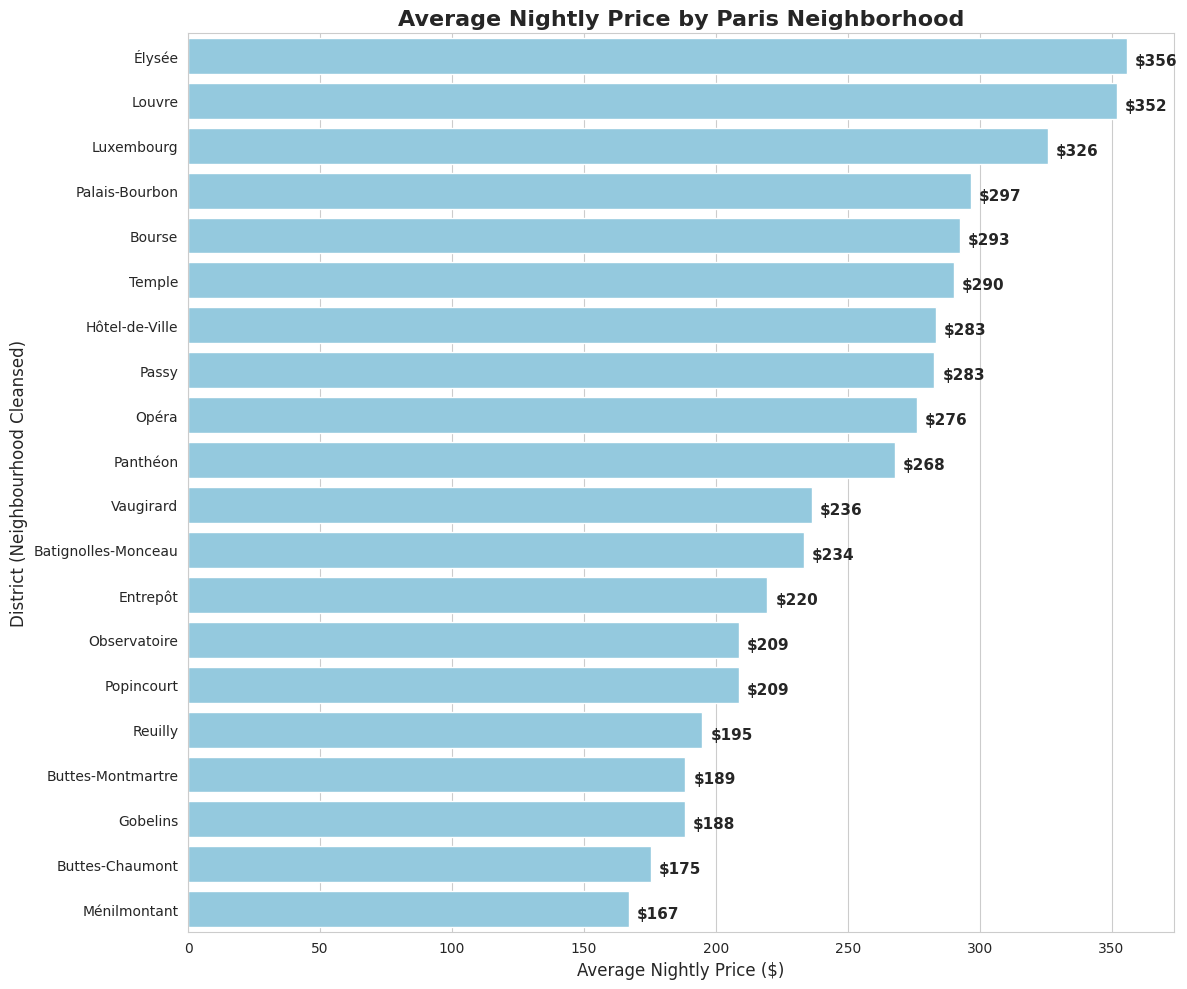

In [0]:
from pyspark.sql.functions import col, avg, exp
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Aggregate Average Price per District
# We convert log_price back to the real nightly rate using exp()
district_price_df = local_train_df.groupBy("neighbourhood_cleansed").agg(avg(exp(col("log_price"))).alias("avg_price")).orderBy(col("avg_price").desc())

# 2. Plot
pdf_district_price = district_price_df.toPandas()

plt.figure(figsize=(12, 10))
sns.set_style("whitegrid")

barplot = sns.barplot(data=pdf_district_price, x="avg_price", y="neighbourhood_cleansed", color="skyblue")

for i, p in enumerate(barplot.patches):
    width = p.get_width()
    plt.text(
        width + 3, 
        p.get_y() + p.get_height()/2 + 0.1, 
        f"${width:,.0f}", 
        ha="left", 
        va="center",
        fontsize=11, 
        fontweight='bold'
    )

plt.title("Average Nightly Price by Paris Neighborhood", fontsize=16, fontweight='bold')
plt.xlabel("Average Nightly Price ($)", fontsize=12)
plt.ylabel("District (Neighbourhood Cleansed)", fontsize=12)

plt.tight_layout()
plt.show()

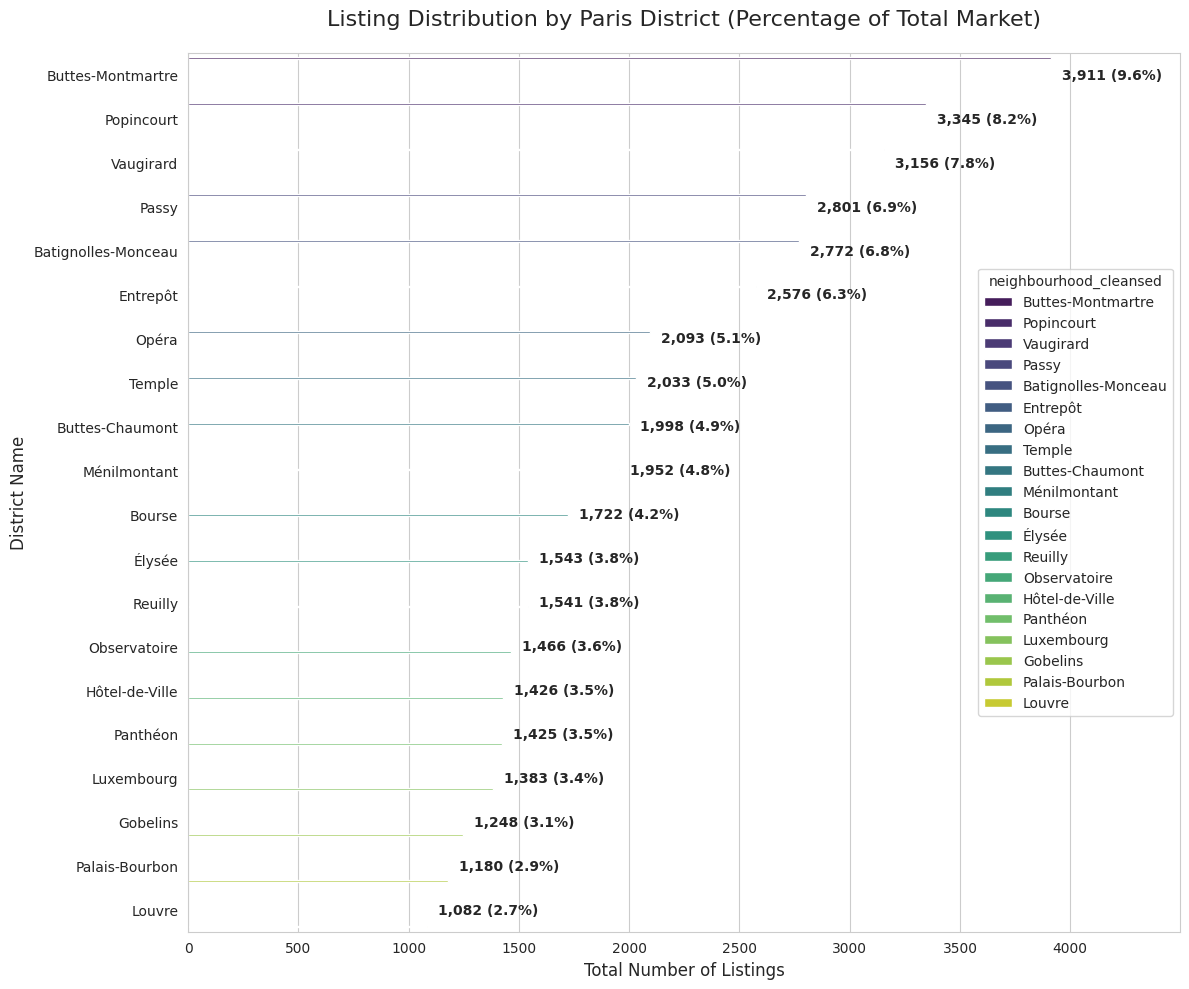

In [0]:
from pyspark.sql.functions import col, count, desc

# --- 1. AGGREGATE PARIS DATA (Keep as is) ---
neigh_col = "neighbourhood_cleansed"
df_neigh_counts = (
    local_train_df
    .filter(col(neigh_col).isNotNull())
    .groupBy(neigh_col)
    .agg(count("*").alias("listing_count"))
    .orderBy(desc("listing_count"))
)

# --- 2. CALCULATE GLOBAL PERCENTAGE ---
# Calculate the total denominator (Total Paris listings)
total_paris_listings = local_train_df.count()

# Calculate individual percentage for each neighborhood
df_plot_data = (
    df_neigh_counts
    .withColumn("global_percentage", (col("listing_count") / total_paris_listings) * 100)
)

# Convert to Pandas for plotting
pdf_plot = df_plot_data.toPandas()

# --- 3. VISUALIZATION ---
plt.figure(figsize=(12, 10))
sns.set_style("whitegrid")

# Create Horizontal Bar Plot
# Note: Added 'hue' to avoid future warnings and 'palette' for better visuals
barplot = sns.barplot(
    data=pdf_plot, 
    x="listing_count", 
    y="neighbourhood_cleansed", 
    hue="neighbourhood_cleansed",
    palette="viridis"
)

# Add data labels: exact count and the individual (global) percentage
for i, row in enumerate(pdf_plot.itertuples()):
    plt.text(
        row.listing_count + 50, # Offset for readability
        i, 
        f"{int(row.listing_count):,} ({row.global_percentage:.1f}%)", 
        va='center', 
        fontsize=10, 
        fontweight='bold'
    )

plt.title("Listing Distribution by Paris District (Percentage of Total Market)", fontsize=16, pad=20)
plt.xlabel("Total Number of Listings", fontsize=12)
plt.ylabel("District Name", fontsize=12)

# Adjust x-limit to prevent labels from being cut off
plt.xlim(0, pdf_plot['listing_count'].max() * 1.15)

plt.tight_layout()
plt.show()

#### Longitude and Latutude

In [0]:
import plotly.express as px
import numpy as np
from pyspark.sql.functions import col, exp

# --- 1. DATA PREPARATION ---
# Ensure we are using local_train_df and filtering null coordinates
df_paris_map = local_train_df.select(
    col("latitude").cast("float"), 
    col("longitude").cast("float"), 
    col("log_price"),
    "neighbourhood_cleansed" 
).filter(col("latitude").isNotNull() & col("longitude").isNotNull())

# Convert to Pandas (Sampling 50% to keep the map responsive)
pdf_paris = df_paris_map.sample(False, 0.5, seed=42).toPandas()

# Calculate Real Price for hover tooltips in Pandas
pdf_paris["price_usd"] = np.exp(pdf_paris["log_price"])

# --- 2. CREATE THE MAP ---
fig = px.scatter_mapbox(
    pdf_paris,
    lat="latitude",
    lon="longitude",
    color="log_price",           # Color based on Log Price for better contrast
    size="price_usd",            # Bubble size relative to price
    size_max=10,
    color_continuous_scale="Jet", # Red = Expensive, Blue = Budget
    hover_name="neighbourhood_cleansed", # Updated to match your column
    hover_data={
        "price_usd": ":$.2f",    # Show real price with $ sign
        "log_price": False,      # Hide the internal log value
        "latitude": False,
        "longitude": False
    },
    zoom=11,                     # Zoom level appropriate for Paris
    center={"lat": 48.8566, "lon": 2.3522}, 
    mapbox_style="carto-positron", 
    title="Paris Price Heatmap by Coordinates"
)

fig.update_layout(
    margin={"r":0,"t":50,"l":0,"b":0},
    coloraxis_colorbar=dict(
        title="Price Tier",
        # Use np.log since the 'color' column is log_price
        tickvals=[np.log(50), np.log(150), np.log(400), np.log(1000)],
        ticktext=["$50", "$150", "$400", "$1k+"]
    )
)

fig.show()

### Sleeping arrangment

#### Maximal guests allowed

In [0]:
from pyspark.sql.functions import col

# Ensure the column is an integer
local_train_df = local_train_df.withColumn("accommodates", col("accommodates").cast("int"))

# Calculate the 5th and 95th percentiles
# 0.01 is the relative error (precision)
quantiles = local_train_df.approxQuantile("accommodates", [0.05, 0.95], 0.01)

q5 = quantiles[0]
q95 = quantiles[1]

print(f"--- Quantile Analysis for Accommodates ---")
print(f"5th Percentile (Q5):  {q5}")
print(f"95th Percentile (Q95): {q95}")
print(f"Typical Paris listing accommodates between {int(q5)} and {int(q95)} guests.")

--- Quantile Analysis for Accommodates ---
5th Percentile (Q5):  2.0
95th Percentile (Q95): 6.0
Typical Paris listing accommodates between 2 and 6 guests.


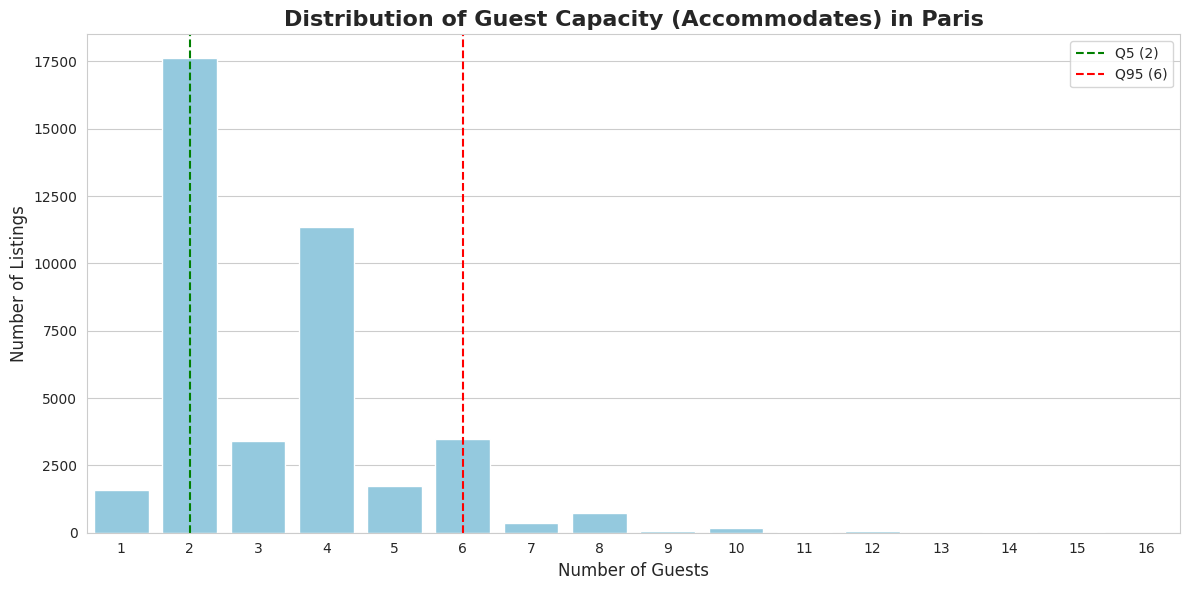

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns

# Convert to Pandas for plotting
pdf_acc = local_train_df.select("accommodates").toPandas()

plt.figure(figsize=(12, 6))
sns.set_style("whitegrid")

# Create a countplot
sns.countplot(data=pdf_acc, x="accommodates", color="skyblue")

# Add Vertical Lines for Quantiles
plt.axvline(x=q5 - 1, color='green', linestyle='--', label=f'Q5 ({int(q5)})')
plt.axvline(x=q95 - 1, color='red', linestyle='--', label=f'Q95 ({int(q95)})')

plt.title("Distribution of Guest Capacity (Accommodates) in Paris", fontsize=16, fontweight='bold')
plt.xlabel("Number of Guests", fontsize=12)
plt.ylabel("Number of Listings", fontsize=12)
plt.legend()

plt.tight_layout()
plt.show()

In [0]:
from pyspark.sql.functions import col
local_train_df = local_train_df.filter(col("accommodates") <= 12) # To match the global data

#### Beds, Baths, Bedrooms

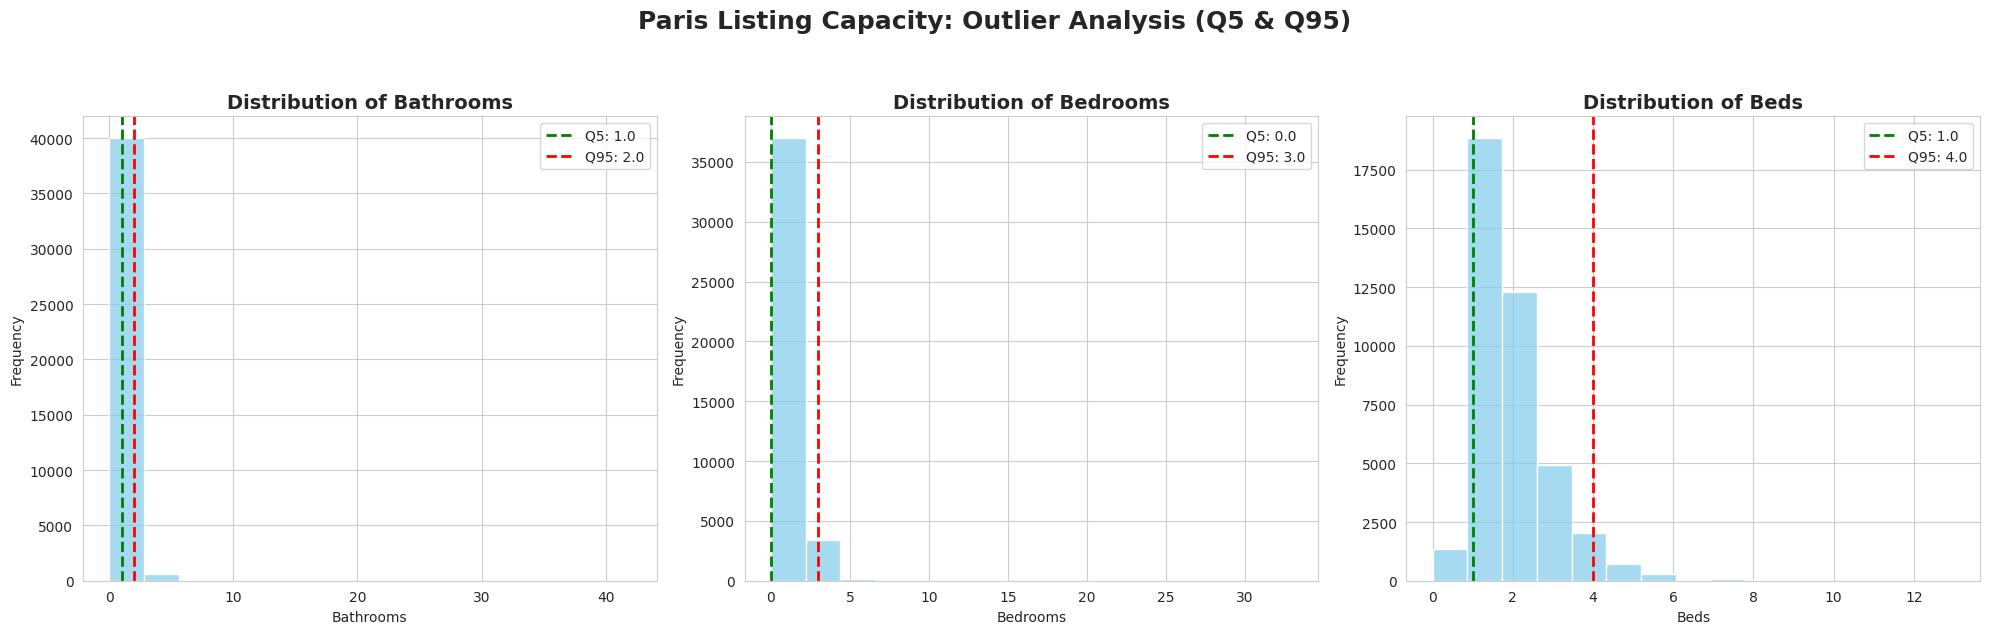

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql.functions import col

# --- 1. PREPARE DATA ---
# Ensure columns are numeric and select them
features = ["bathrooms", "bedrooms", "beds"]
pdf_features = local_train_df.select([col(c).cast("float") for c in features]).toPandas()

# --- 2. SETUP PLOT ---
fig, axes = plt.subplots(1, 3, figsize=(20, 6))
sns.set_style("whitegrid")

for i, feature in enumerate(features):
    # Calculate Quantiles
    q5 = pdf_features[feature].quantile(0.05)
    q95 = pdf_features[feature].quantile(0.95)
    
    # Plot Histogram
    sns.histplot(pdf_features[feature], bins=15, color="skyblue", kde=False, ax=axes[i])
    
    # Add Q5 and Q95 lines
    axes[i].axvline(q5, color='green', linestyle='--', linewidth=2, label=f'Q5: {q5:.1f}')
    axes[i].axvline(q95, color='red', linestyle='--', linewidth=2, label=f'Q95: {q95:.1f}')
    
    # Formatting
    axes[i].set_title(f"Distribution of {feature.capitalize()}", fontsize=14, fontweight='bold')
    axes[i].set_xlabel(feature.capitalize())
    axes[i].set_ylabel("Frequency")
    axes[i].legend()

plt.suptitle("Paris Listing Capacity: Outlier Analysis (Q5 & Q95)", fontsize=18, fontweight='bold', y=1.05)
plt.tight_layout()
plt.show()

In [0]:
from pyspark.sql.functions import col

local_train_df = local_train_df.filter(col("bathrooms") <= 4) # To match global data
local_train_df = local_train_df.filter(col("bedrooms") <= 5)
local_train_df = local_train_df.filter(col("beds") <= 8) # To match global data

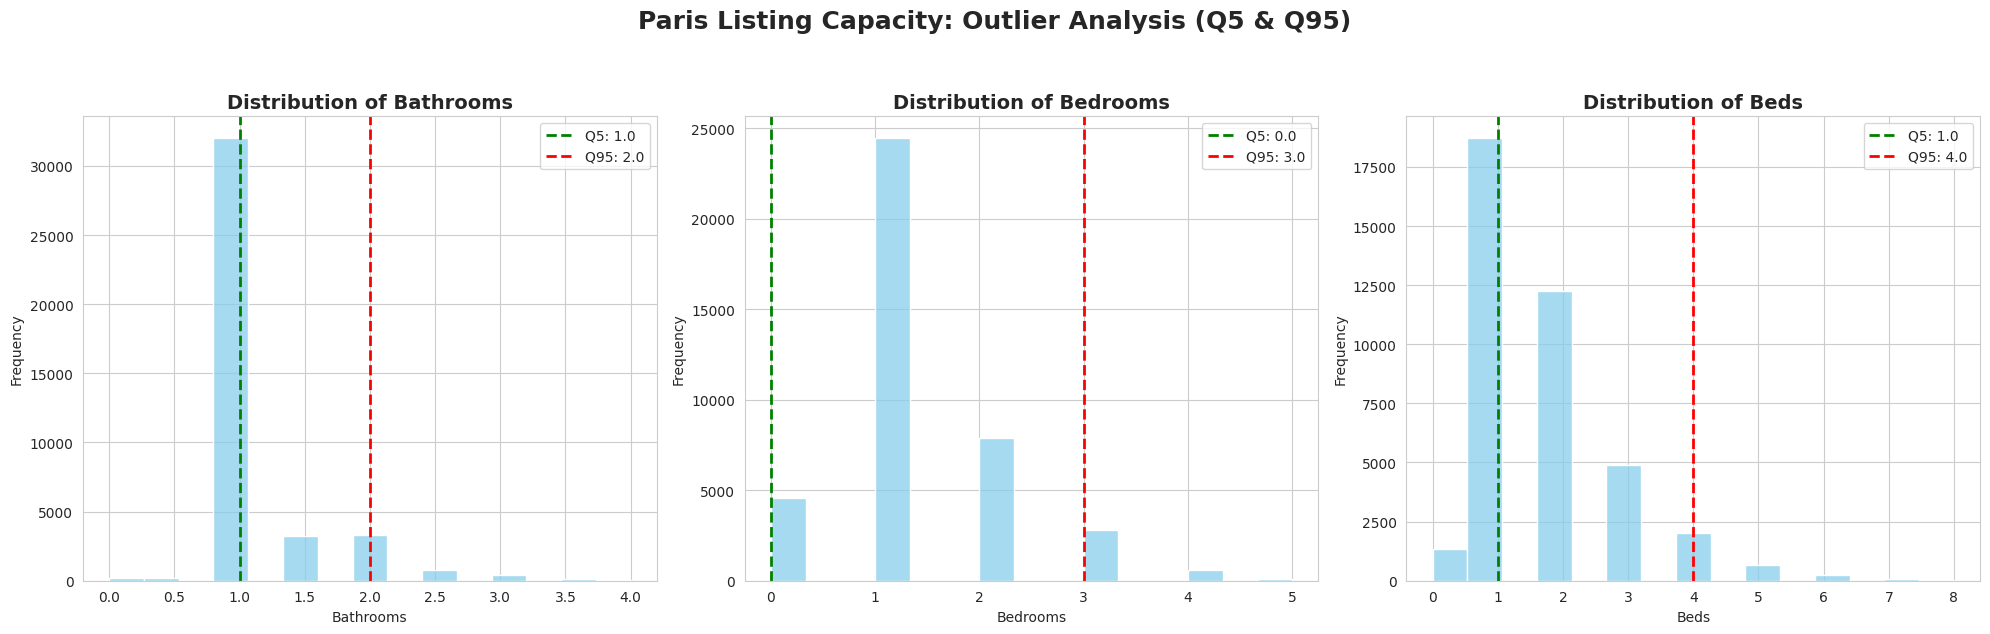

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql.functions import col

# --- 1. PREPARE DATA ---
# Ensure columns are numeric and select them
features = ["bathrooms", "bedrooms", "beds"]
pdf_features = local_train_df.select([col(c).cast("float") for c in features]).toPandas()

# --- 2. SETUP PLOT ---
fig, axes = plt.subplots(1, 3, figsize=(20, 6))
sns.set_style("whitegrid")

for i, feature in enumerate(features):
    # Calculate Quantiles
    q5 = pdf_features[feature].quantile(0.05)
    q95 = pdf_features[feature].quantile(0.95)
    
    # Plot Histogram
    sns.histplot(pdf_features[feature], bins=15, color="skyblue", kde=False, ax=axes[i])
    
    # Add Q5 and Q95 lines
    axes[i].axvline(q5, color='green', linestyle='--', linewidth=2, label=f'Q5: {q5:.1f}')
    axes[i].axvline(q95, color='red', linestyle='--', linewidth=2, label=f'Q95: {q95:.1f}')
    
    # Formatting
    axes[i].set_title(f"Distribution of {feature.capitalize()}", fontsize=14, fontweight='bold')
    axes[i].set_xlabel(feature.capitalize())
    axes[i].set_ylabel("Frequency")
    axes[i].legend()

plt.suptitle("Paris Listing Capacity: Outlier Analysis (Q5 & Q95)", fontsize=18, fontweight='bold', y=1.05)
plt.tight_layout()
plt.show()

### Amenities

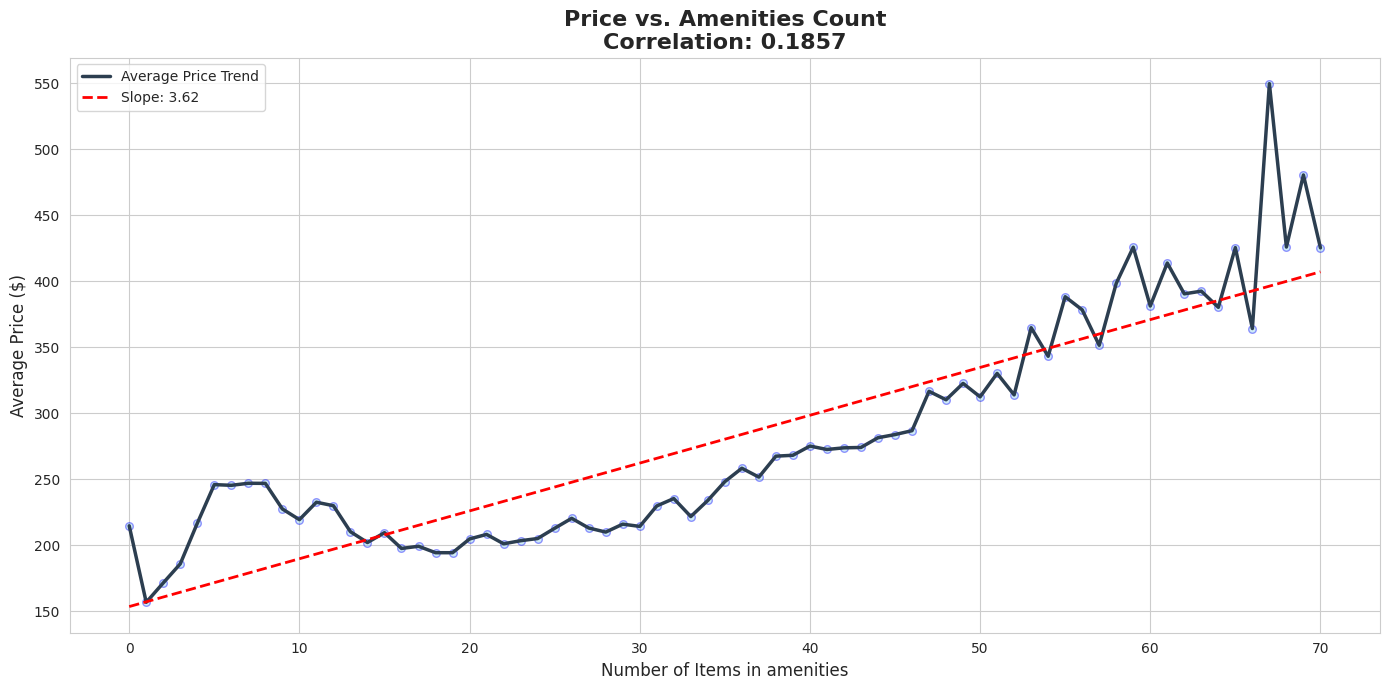

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from pyspark.sql.functions import col, size, split, regexp_replace, length, avg, count, when, exp

def plot_array_feature_trend(df, column_name):
    # --- 1. DATA PREPARATION ---
    # Convert array-string to numeric count
    df_numeric = df.withColumn(
        "clean_list", 
        regexp_replace(col(column_name), r"\[|\]|'| ", "") 
    ).withColumn(
        "item_count",
        when(length(col("clean_list")) == 0, 0)
        .otherwise(size(split(col("clean_list"), ",")))
    ).withColumn(
        "price_clean", exp(col("log_price")).cast("float")
    )

    # Calculate Statistical Correlation
    correlation = df_numeric.stat.corr("item_count", "price_clean")
    
    # Aggregate for Plotting
    # Filter count > 10 to remove noise from rare high-count outliers
    trend_data = df_numeric.groupBy("item_count").agg(
        avg("price_clean").alias("avg_price"),
        count("*").alias("row_count")
    ).filter(col("row_count") > 10).orderBy("item_count").toPandas()

    if trend_data.empty:
        print(f"Not enough data to plot trend for {column_name}")
        return

    # --- 2. PLOTTING ---
    plt.figure(figsize=(14, 7))
    sns.set_style("whitegrid")

    # Plot A: The Trend Line
    sns.lineplot(
        data=trend_data, 
        x="item_count", 
        y="avg_price", 
        linewidth=2.5, 
        color="#2c3e50",
        label="Average Price Trend"
    )

    # Plot B: The Aggregated Scatter Points
    plt.scatter(
        trend_data["item_count"], 
        trend_data["avg_price"], 
        alpha=0.4, 
        s=30, 
        color="skyblue",
        edgecolor="blue"
    )

    # Add a Regression Line
    z = np.polyfit(trend_data["item_count"], trend_data["avg_price"], 1)
    p = np.poly1d(z)
    plt.plot(trend_data["item_count"], p(trend_data["item_count"]), "r--", linewidth=2, label=f"Slope: {z[0]:.2f}")

    plt.title(f"Price vs. {column_name.replace('_', ' ').capitalize()} Count\nCorrelation: {correlation:.4f}", fontsize=16, fontweight='bold')
    plt.xlabel(f"Number of Items in {column_name}", fontsize=12)
    plt.ylabel("Average Price ($)", fontsize=12)
    plt.legend()
    plt.tight_layout()
    plt.show()

# --- 3. RUN FOR MULTIPLE COLUMNS ---
columns_to_analyze = ["available_dates", "amenities", "highlights"]

for target in columns_to_analyze:
    if target in local_train_df.columns:
        plot_array_feature_trend(local_train_df, target)

In [0]:
from pyspark.sql.functions import col, size, split, regexp_replace, length, when

# 1. Clean the string by removing brackets and quotes
# 2. Split by comma to create an array
# 3. Use size() to count the elements
local_train_df = local_train_df.withColumn(
    "amenities_count_raw",
    when(col("amenities").isNull() | (length(col("amenities")) <= 2), 0) # Handle nulls or empty brackets []
    .otherwise(
        size(split(regexp_replace(col("amenities"), r"\[|\]|'|\"", ""), ","))
    )
).withColumn("amenities_count", col("amenities_count_raw").cast("int"))

# 4. Verify the results
print("Sample of the new amenities_count feature:")
local_train_df.select("amenities", "amenities_count").show(5, truncate=50)

# Check the max and average count in Paris
local_train_df.selectExpr("avg(amenities_count) as avg_amenities", "max(amenities_count) as max_amenities").show()

Sample of the new amenities_count feature:
+--------------------------------------------------+---------------+
|                                         amenities|amenities_count|
+--------------------------------------------------+---------------+
|["Kitchen", "Wifi", "Washer", "Heating", "Smoki...|              6|
|["SONOS Bluetooth sound system", "Long term sta...|             81|
|["Kitchen", "Hot water", "Hangers", "Iron", "Wa...|             12|
|["Shampoo", "Long term stays allowed", "Portabl...|             43|
|["Long term stays allowed", "Dryer \u2013\u00a0...|             21|
+--------------------------------------------------+---------------+
only showing top 5 rows

+----------------+-------------+
|   avg_amenities|max_amenities|
+----------------+-------------+
|28.8930900255374|          111|
+----------------+-------------+



In [0]:
from pyspark.sql.functions import col, split, regexp_replace, explode, count, desc, array_intersect, array, lit, size

# --- 1. EXTRACT INDIVIDUAL AMENITIES ---
# Clean the string and turn into a real Spark Array
df_exploded = local_train_df.withColumn(
    "amenity_array", 
    split(regexp_replace(col("amenities"), r"\[|\]|'|\"", ""), ",\s*")
)

# Find the Top 50 most frequent individual amenities
top_50_amenities_rows = df_exploded.select(explode(col("amenity_array")).alias("single_amenity")) \
    .filter(col("single_amenity") != "") \
    .groupBy("single_amenity") \
    .agg(count("*").alias("cnt")) \
    .orderBy(desc("cnt")) \
    .limit(50) \
    .collect()

top_50_list = [row['single_amenity'] for row in top_50_amenities_rows]
print(f"Top 5 identified: {top_50_list[:5]}")

Top 5 identified: ['Kitchen', 'Wifi', 'Hot water', 'Smoke alarm', 'Hair dryer']


In [0]:
# Create a Spark column of the Top 50 list to use in intersection
top_50_col = array([lit(x) for x in top_50_list])

# --- 2. APPLY THE FILTER ---
local_train_df = df_exploded.withColumn(
    "amenities", # Overwrite the old string column with the filtered array
    array_intersect(col("amenity_array"), top_50_col))

# 3. VERIFICATION
print("Success: Amenities filtered to Top 50 most common.")
local_train_df.select("amenities", "amenities_count").show(5, truncate=80)

Success: Amenities filtered to Top 50 most common.
+--------------------------------------------------------------------------------+---------------+
|                                                                       amenities|amenities_count|
+--------------------------------------------------------------------------------+---------------+
|                                                [Kitchen, Wifi, Washer, Heating]|              6|
|[Long term stays allowed, Microwave, Room-darkening shades, Freezer, Heating,...|             81|
|[Kitchen, Hot water, Hangers, Iron, Washer, Heating, Smoke alarm, Wifi, Host ...|             12|
|[Shampoo, Long term stays allowed, Portable fans, Washer, Oven, Microwave, Di...|             43|
|[Long term stays allowed, Microwave, Hair dryer, Refrigerator, Room-darkening...|             21|
+--------------------------------------------------------------------------------+---------------+
only showing top 5 rows



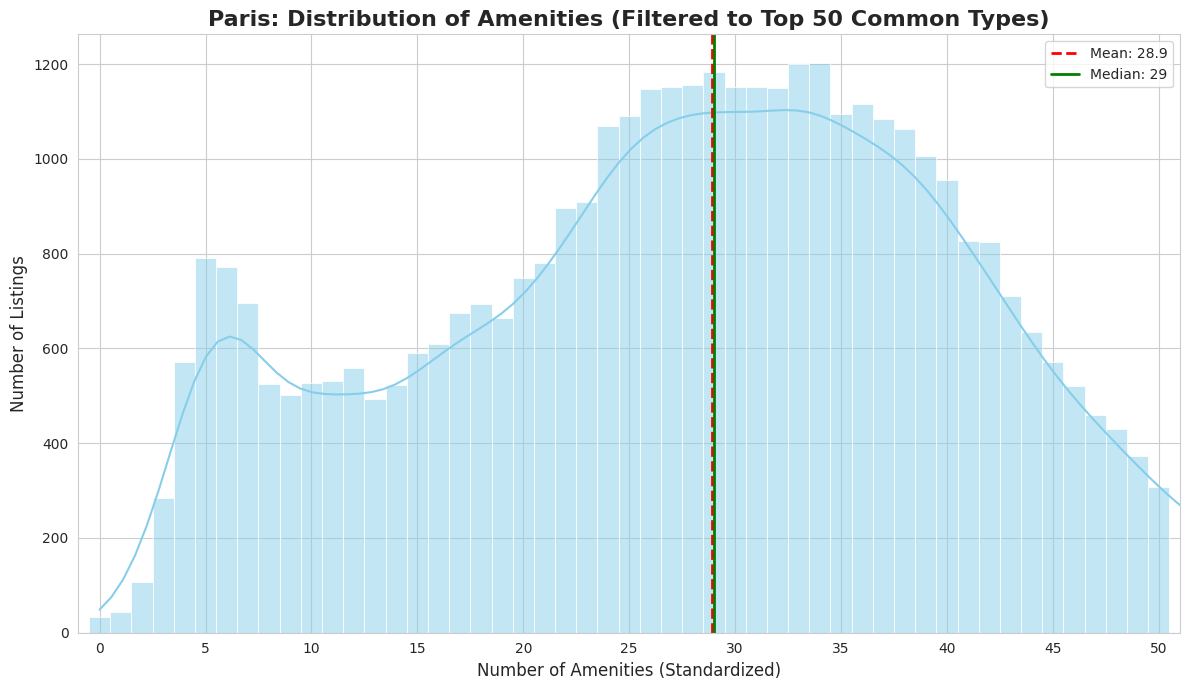

Average amenities per listing: 28.89
Most common number (Median):  29


In [0]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 1. Convert the filtered counts to Pandas
# We only need the amenities_count column for this plot
pdf_amenity_dist = local_train_df.select("amenities_count_raw").toPandas()

# 2. Create the Histogram
plt.figure(figsize=(12, 7))
sns.set_style("whitegrid")

# We use discrete bins from 0 to 50
sns.histplot(
    pdf_amenity_dist["amenities_count_raw"], 
    bins=np.arange(0, 52) - 0.5, 
    color="skyblue", 
    edgecolor="white",
    kde=True # Kernel Density Estimate to show the shape of the curve
)

# 3. Add Statistical Markers
mean_val = pdf_amenity_dist["amenities_count_raw"].mean()
median_val = pdf_amenity_dist["amenities_count_raw"].median()

plt.axvline(mean_val, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_val:.1f}')
plt.axvline(median_val, color='green', linestyle='-', linewidth=2, label=f'Median: {median_val:.0f}')

# 4. Formatting
plt.title("Paris: Distribution of Amenities (Filtered to Top 50 Common Types)", fontsize=16, fontweight='bold')
plt.xlabel("Number of Amenities (Standardized)", fontsize=12)
plt.ylabel("Number of Listings", fontsize=12)
plt.xticks(range(0, 51, 5))
plt.xlim(-1, 51)
plt.legend()

plt.tight_layout()
plt.show()

# 5. Quick Stats Output
print(f"Average amenities per listing: {mean_val:.2f}")
print(f"Most common number (Median):  {median_val:.0f}")

### Casting

In [0]:
from pyspark.sql.functions import when, col
local_train_df = local_train_df.withColumn("host_is_superhost", when(col("host_is_superhost") == 't', 1).otherwise(0))

### Drop unused attributes

In [0]:
local_train_df = local_train_df.drop("listing_url", "scrape_id", "source", "picture_url", "host_id", "host_url", "host_name", "host_about", "host_thumbnail_url", "host_picture_url", "neighbourhood_group_cleansed", "calendar_updated",  "license", "price_usd", "raw_price_str", "host_has_profile_pic", "neighbourhood", "host_neighbourhood", "host_location", "room_type", "bathrooms_text", "host_total_listings_count", "last_scraped", "calendar_last_scraped", "availability_30", "availability_60", "availability_90")

### Final Cleaning Result

In [0]:
display(local_train_df.limit(10))

## Test Data Cleaning

In [0]:
display(test_df.limit(5))

### Matching structure to global and local datasets

In [0]:
test_df = test_df.withColumn("host_since", (lit(2026) - year(to_date(col("host_since"), "yyyy-MM-dd"))).cast("int"))
test_df = test_df.fillna(0, subset=["host_since"])

In [0]:
from pyspark.sql.functions import when, col
test_df = test_df.withColumn("host_is_superhost", when(col("host_is_superhost") == 't', 1).otherwise(0))

In [0]:
test_df = test_df.withColumn(
    "amenities_count_raw",
    when(col("amenities").isNull() | (length(col("amenities")) <= 2), 0) # Handle nulls or empty brackets []
    .otherwise(
        size(split(regexp_replace(col("amenities"), r"\[|\]|'|\"", ""), ","))
    )).withColumn("amenities_count", col("amenities_count_raw").cast("int"))

In [0]:
from pyspark.sql.functions import when, col, lower, regexp_replace

# 1. Reuse the defined gold_keys
gold_keys = [
    'entirecondo', 
    'entirehome', 
    'entirerentalunit', 
    'entiretownhouse', 
    'privateroominbedandbreakfast', 
    'privateroominrentalunit'
]

# 2. Process TEST Data
# We normalize the 'property_type' column and map it to gold_keys or "other"
test_df = test_df.withColumn(
    "listing_type_final",
    when(
        lower(regexp_replace(col("property_type"), "[ _]", "")).isin(gold_keys),
        lower(regexp_replace(col("property_type"), "[ _]", ""))
    ).otherwise("other")
)

# 3. Cleanup: Drop the raw 'property_type' and rename the standardized column
test_df = test_df.drop("property_type").withColumnRenamed("listing_type_final", "listing_type")

In [0]:
from pyspark.sql.functions import col, lower, regexp_replace, split, array_contains, lit

shared_list = ['Baking sheet', 'Bathtub', 'Coffee maker', 'Dining table', 'Dishwasher', 'First aid kit', 'Hair dryer', 'Hangers', 'Hot water', 'Iron', 'Microwave', 'Oven', 'Refrigerator', 'Shampoo', 'Stove', 'TV', 'Toaster', 'Washer', 'Wifi']
local_only = ['Bed linens', 'Body soap', 'Books and reading material', 'Carbon monoxide alarm', 'Central heating', 'Cleaning products', 'Clothing storage', 'Coffee', 'Cooking basics', 'Dedicated workspace', 'Dishes and silverware', 'Drying rack for clothing', 'Elevator', 'Essentials', 'Extra pillows and blankets', 'Freezer', 'Heating', 'Host greets you', 'Hot water kettle', 'Kitchen', 'Laundromat nearby', 'Lockbox', 'Long term stays allowed', 'Luggage dropoff allowed', 'Portable fans', 'Private entrance', 'Room-darkening shades', 'Self check-in', 'Shower gel', 'Smoke alarm', 'Wine glasses']

# Pre-normalized targets for matching
shared_targets = [s.lower().replace(" ", "") for s in shared_list]
local_targets = [l.lower().replace(" ", "") for l in local_only]

# --- PROCESS TEST DATA (Individual Binary Columns Logic) ---

# 1. Pre-process the amenities string into a clean array for exact matching
# This handles the '["Wifi", "Hot_water"]' format by stripping brackets, quotes, spaces, and underscores
test_df = test_df.withColumn("clean_amenities", split(regexp_replace(lower(col("amenities")), r'[\[\]"\' _]', ""), ","))

# 2. Create separate binary columns for Shared Amenities
for amenity in shared_targets:
    column_name = f"has_{amenity}"
    test_df = test_df.withColumn(column_name, array_contains(col("clean_amenities"), lit(amenity)).cast("int"))

# 3. Create separate binary columns for Local Specific Amenities
for amenity in local_targets:
    column_name = f"has_{amenity}"
    test_df = test_df.withColumn(column_name, array_contains(col("clean_amenities"), lit(amenity)).cast("int"))

# 4. Clean up intermediate processing column
test_df = test_df.drop("clean_amenities")

# --- VERIFY ---
print(f"Test Data Transformation Complete - {len(shared_targets + local_targets)} columns created.")
# Selecting a few example columns to verify the result
example_cols = ["amenities"] + [f"has_{shared_targets[0]}", f"has_{local_targets[0]}"]
test_df.select(*example_cols).show(3, truncate=80)

Test Data Transformation Complete - 50 columns created.
+--------------------------------------------------------------------------------+---------------+-------------+
|                                                                       amenities|has_bakingsheet|has_bedlinens|
+--------------------------------------------------------------------------------+---------------+-------------+
|["Shampoo", "Long term stays allowed", "Portable fans", "Washer", "Oven", "Cl...|              1|            1|
|["Shampoo", "Lockbox", "Bluetooth sound system", "Microwave", "Clothing stora...|              1|            1|
|["Shampoo", "Long term stays allowed", "Portable fans", "Washer", "Oven", "Mi...|              1|            1|
+--------------------------------------------------------------------------------+---------------+-------------+
only showing top 3 rows



### Drop unused attributes

In [0]:
test_df = test_df.drop("listing_url", "scrape_id", "source", "picture_url", "host_id", "host_url", "host_name", "host_about", "host_thumbnail_url", "host_picture_url", "neighbourhood_group_cleansed", "calendar_updated",  "license", "price_usd", "raw_price_str", "host_has_profile_pic", "neighbourhood", "host_neighbourhood", "host_location", "room_type", "bathrooms_text", "host_total_listings_count", "last_scraped", "calendar_last_scraped", "availability_30", "availability_60", "availability_90")

### Final Cleaning Result

In [0]:
display(test_df.limit(10))

# Feature Selection

## Global Data Feature Selection

### Original data is worldwide

In [0]:
import plotly.express as px
import numpy as np
from pyspark.sql.functions import col, count, avg

# 1. EXTRACT & AGGREGATE
# We select 'country' and 'ratings' based on your confirmed schema
country_stats_df = (
    global_train_df
    .filter(col("country").isNotNull())  # Ensure we don't map null countries
    .groupBy("country")
    .agg(
        avg("ratings").alias("avg_rating"),
        count("*").alias("listing_count")
    )
    # STATISTICAL STABILITY: Filter out countries with < 50 listings
    .filter(col("listing_count") > 50)
    .withColumnRenamed("country", "Country") # Rename for Plotly aesthetics
)

# 2. COLLECT TO PANDAS
pdf_country = country_stats_df.toPandas()

# 3. VISUALIZATION (Log Scale & Colorbar)
# Get num of listings in log-scale (adding 1 to avoid log(0) error just in case)
pdf_country["log_count"] = np.log10(pdf_country["listing_count"] + 1)

# Plot map
fig = px.choropleth(
    pdf_country,
    locations="Country",            # Using the column from our Pandas DF
    locationmode='country names',
    color="log_count",              # Color is based on the LOG value for better contrast
    hover_name="Country",
    hover_data={
        "listing_count": ":,",      # Show the REAL count (e.g. 1,200)
        "avg_rating": ":.2f",       # Show the rating with 2 decimals
        "log_count": False          # Hide the internal log value
    },
    color_continuous_scale=['#D4939D', '#002855'], 
    title="Global Listing Volume (Log Scale)"
)

# Add the Readable Color Bar
fig.update_layout(
    geo=dict(
        showframe=False,
        showcoastlines=True,
        projection_type='natural earth'
    ),
    width=1000,
    height=800,
    # Transforms log numbers (0, 1, 2...) back into readable text (1, 10, 100...)
    coloraxis_colorbar=dict(
        title="Listings",
        tickvals=[0, 1, 2, 3, 4, 5, 6],
        ticktext=["1", "10", "100", "1k", "10k", "100k", "1M"]
    )
)

fig.show()

This plot shows the top 30 countries, because we filtered the others in cleaning phase.

### Host related

#### Rating

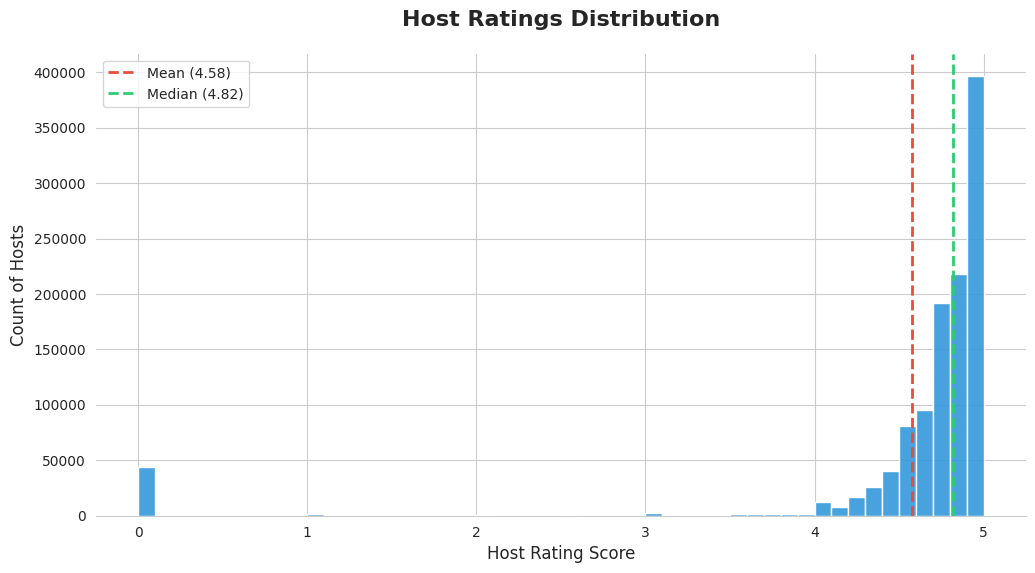

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql.functions import col, avg

# --- 1. PREPARE DATA ---
# Use 'host_rating' from your schema. 
# It is already DoubleType, so we just filter nulls.
df_clean = global_train_df.select(col("host_rating")).filter(col("host_rating").isNotNull())

# Calculate Mean and Median (PySpark side)
mean_val = df_clean.select(avg("host_rating")).first()[0]
median_val = df_clean.approxQuantile("host_rating", [0.5], 0.01)[0]

# Convert to Pandas for plotting
pdf = df_clean.toPandas()

# --- 2. PLOT SETUP ---
sns.set_style("whitegrid")
plt.figure(figsize=(12, 6))

# Create the histogram
sns.histplot(
    data=pdf, 
    x="host_rating", 
    bins=50, 
    color="#3498db", 
    edgecolor="white", 
    alpha=0.9
)

# --- 3. ADD MEAN & MEDIAN LINES ---
plt.axvline(mean_val, color='#e74c3c', linestyle='--', linewidth=2, label=f'Mean ({mean_val:.2f})')
plt.axvline(median_val, color='#2ecc71', linestyle='--', linewidth=2, label=f'Median ({median_val:.2f})')

# --- 4. FORMATTING ---
plt.title("Host Ratings Distribution", fontsize=16, fontweight='bold', pad=20)
plt.xlabel("Host Rating Score", fontsize=12)
plt.ylabel("Count of Hosts", fontsize=12)

sns.despine(left=True)
plt.legend(frameon=True, loc='upper left')

plt.show()

Correlation (Raw Price): 0.0251
Correlation (Log Price): 0.0450


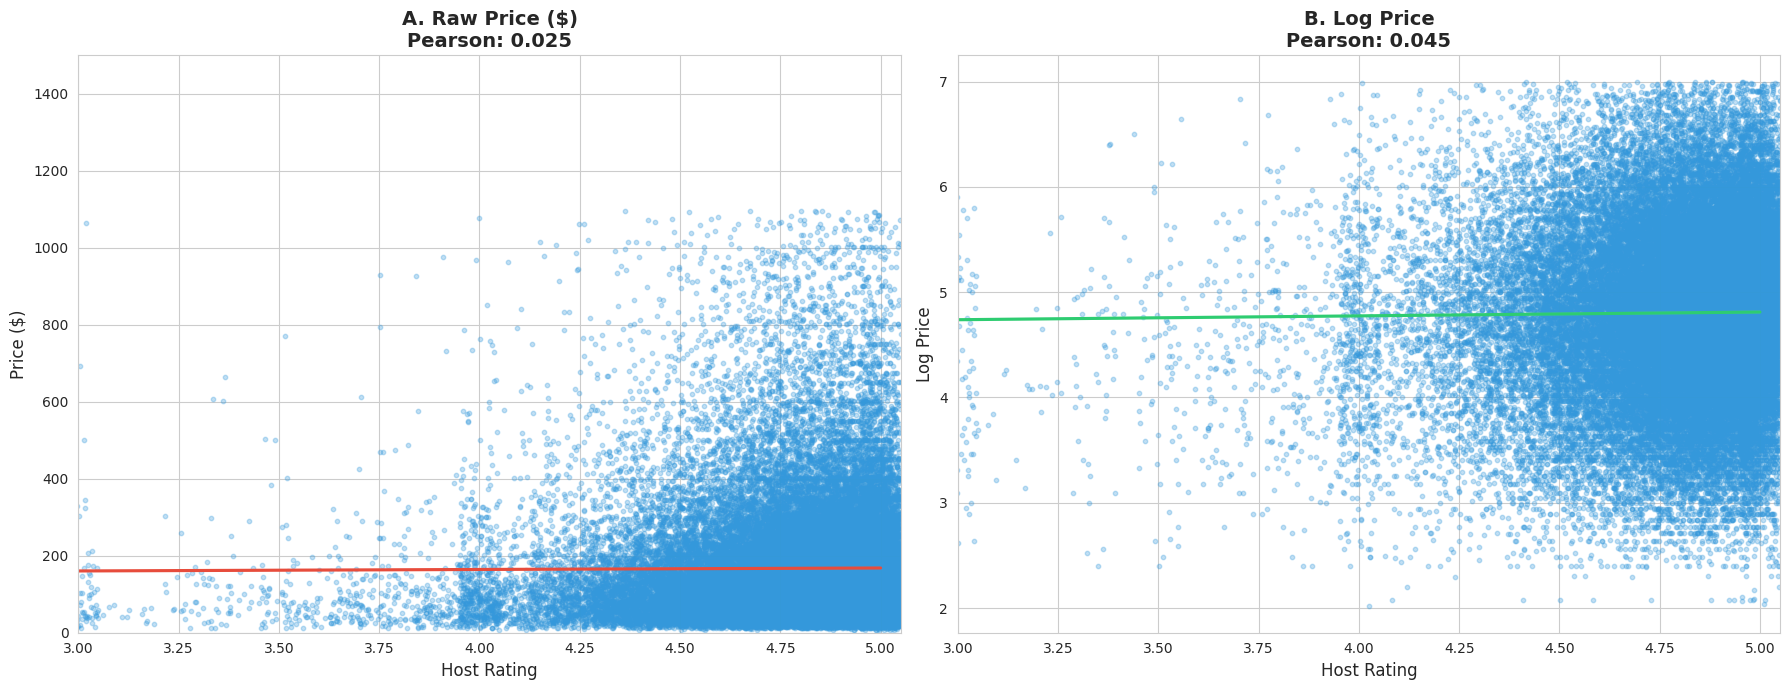

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql.functions import col, exp

# --- 1. DATA PREPARATION ---
df_compare = global_train_df.select(
    col("host_rating"), 
    col("log_price")
).withColumn(
    "real_price", 
    exp(col("log_price"))
).filter(
    col("host_rating").isNotNull() & 
    col("log_price").isNotNull()
)

# --- 2. CALCULATE CORRELATIONS ---
# We calculate two different correlations to see which relationship is "cleaner"
corr_raw = df_compare.stat.corr("host_rating", "real_price")
corr_log = df_compare.stat.corr("host_rating", "log_price")

print(f"Correlation (Raw Price): {corr_raw:.4f}")
print(f"Correlation (Log Price): {corr_log:.4f}")

# --- 3. SAMPLING ---
pdf_sample = df_compare.sample(withReplacement=False, fraction=0.05, seed=42).toPandas()

# --- 4. PLOTTING ---
fig, axes = plt.subplots(1, 2, figsize=(18, 7))
sns.set_style("whitegrid")

# --- PLOT A: RAW PRICE ---
sns.regplot(
    data=pdf_sample, 
    x="host_rating", 
    y="real_price", 
    ax=axes[0],
    scatter_kws={'alpha': 0.3, 's': 10}, 
    line_kws={'color': '#e74c3c'},
    color="#3498db",
    x_jitter=0.05
)
axes[0].set_title(f"A. Raw Price ($)\nPearson: {corr_raw:.3f}", fontsize=14, fontweight='bold')
axes[0].set_ylabel("Price ($)", fontsize=12)
axes[0].set_xlabel("Host Rating", fontsize=12)
axes[0].set_ylim(0, 1500) 
axes[0].set_xlim(3.0, 5.05)

# --- PLOT B: LOG PRICE ---
sns.regplot(
    data=pdf_sample, 
    x="host_rating", 
    y="log_price", 
    ax=axes[1],
    scatter_kws={'alpha': 0.3, 's': 10}, 
    line_kws={'color': '#2ecc71'}, 
    color="#3498db",
    x_jitter=0.05
)
axes[1].set_title(f"B. Log Price\nPearson: {corr_log:.3f}", fontsize=14, fontweight='bold')
axes[1].set_ylabel("Log Price", fontsize=12)
axes[1].set_xlabel("Host Rating", fontsize=12)
axes[1].set_xlim(3.0, 5.05)

plt.tight_layout()
plt.show()

#### Superhost

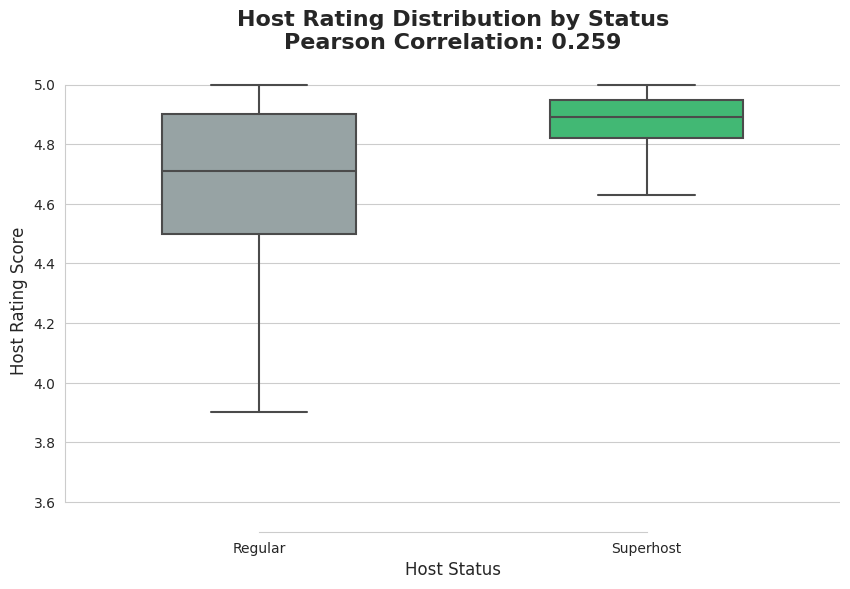

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql.functions import col

# --- 1. DATA PREPARATION ---
# We use 'global_train_df' instead of 'global_df'
# 'host_rating' and 'is_superhost' are already numeric (Double/Int), so we just select them.
df_corr_clean = global_train_df.select(
    col("host_rating"),
    col("is_supperhost")
).filter(col("host_rating").isNotNull())

# Calculate Correlation directly on the numeric columns
correlation_val = df_corr_clean.stat.corr("host_rating", "is_supperhost")

# --- 2. SAMPLING ---
# We sample 10% for the plot to keep it fast
df_sampled = df_corr_clean.sample(withReplacement=False, fraction=0.1, seed=42)
pdf = df_sampled.toPandas()

# Map 1/0 back to text labels for the plot
pdf["Status"] = pdf["is_supperhost"].map({1: "Superhost", 0: "Regular"})

# --- 3. PLOTTING ---
plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")

# Create the Box Plot with explicit ORDER
ax = sns.boxplot(
    data=pdf,
    x="Status",
    y="host_rating",
    order=["Regular", "Superhost"],          
    palette={"Superhost": "#2ecc71", "Regular": "#95a5a6"}, 
    width=0.5, 
    showfliers=False
)

# Titles and Formatting
plt.title(f"Host Rating Distribution by Status\nPearson Correlation: {correlation_val:.3f}", fontsize=16, fontweight='bold', pad=15)
plt.xlabel("Host Status", fontsize=12)
plt.ylabel("Host Rating Score", fontsize=12)
plt.ylim(3.5, 5.05) 

sns.despine(trim=True)
plt.show()

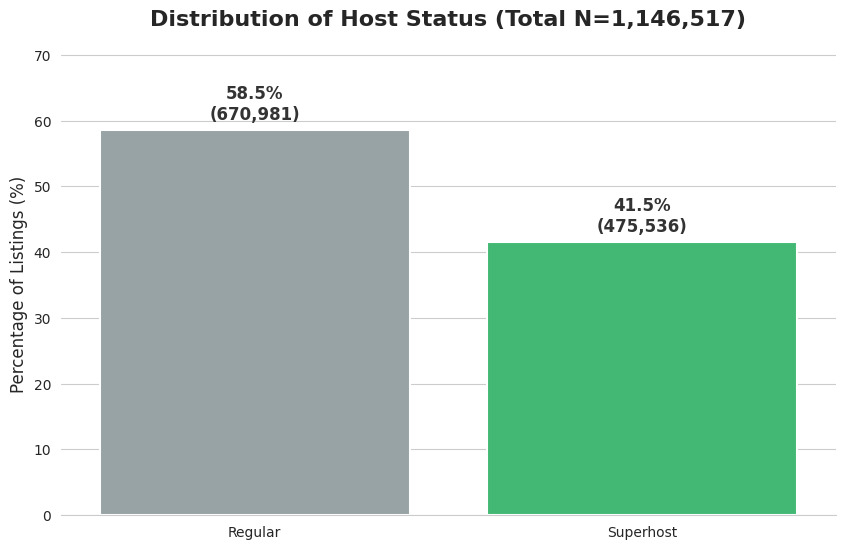

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql.functions import col, when

# --- 1. PREPARE DATA (PySpark) ---
# We use global_train_df and Integer logic (1 vs 0)
df_dist_prep = global_train_df.withColumn("host_status", 
    when(col("is_supperhost") == 1, "Superhost")
    .when(col("is_supperhost") == 0, "Regular")
    .otherwise("Unknown") # Handles nulls if any remain
)

# Aggregate counts
df_counts = df_dist_prep.groupBy("host_status").count().toPandas()

# --- 2. CALCULATE PERCENTAGE (Pandas) ---
total = df_counts["count"].sum()
df_counts["percentage"] = (df_counts["count"] / total) * 100

# Sort: Regular first (or largest first) to make the chart look neat
df_counts = df_counts.sort_values("count", ascending=False)

# --- 3. PLOT (Matplotlib) ---
plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")

# Create Bar Plot
# CRITICAL: We pass 'order' so the bars strictly follow our DataFrame's order
ax = sns.barplot(
    data=df_counts,
    x="host_status",
    y="percentage",
    order=df_counts["host_status"], 
    palette={"Superhost": "#2ecc71", "Regular": "#95a5a6", "Unknown": "#e74c3c"},
    edgecolor="white",
    linewidth=1.5
)

# --- 4. FIX LABELS (Robust Method) ---
# Since we forced the 'order' above, we can just zip the DataFrame rows directly
labels = [f'{row.percentage:.1f}%\n({int(row.count):,})' for row in df_counts.itertuples()]

# Apply labels to the first container (the bars)
ax.bar_label(
    ax.containers[0], 
    labels=labels, 
    padding=5, 
    fontsize=12, 
    fontweight='bold', 
    color='#333333'
)

# --- 5. FINAL STYLING ---
plt.title(f"Distribution of Host Status (Total N={total:,})", fontsize=16, fontweight='bold', pad=20)
plt.ylabel("Percentage of Listings (%)", fontsize=12)
plt.xlabel("") 
plt.ylim(0, df_counts["percentage"].max() * 1.2) 
sns.despine(left=True)

plt.show()

Correlation (Superhost vs. Real Price): 0.0046
Correlation (Superhost vs. Log Price):  0.0298


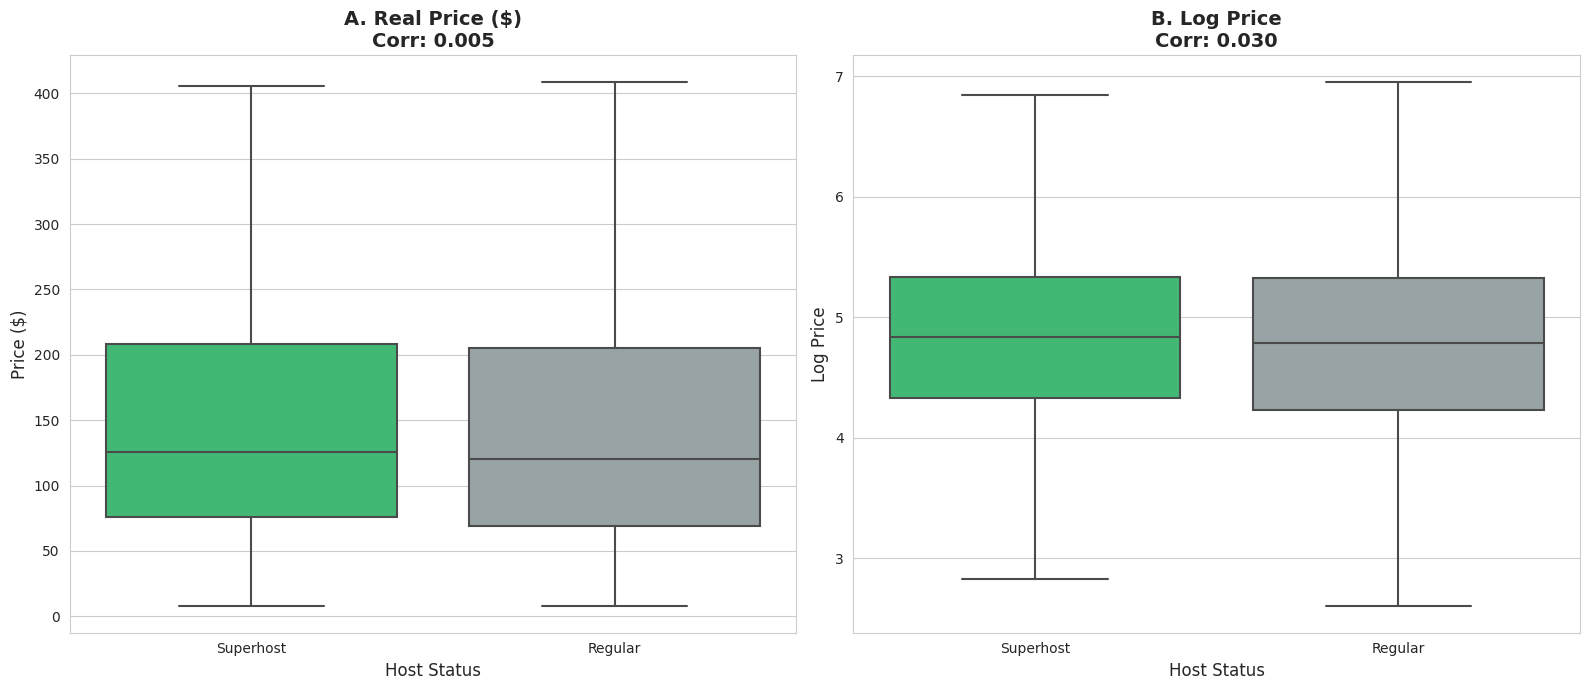

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql.functions import col, exp

# --- 1. DATA PREPARATION ---
# We calculate Real Price (exp) to compare with Log Price
df_superhost_corr = global_train_df.select(
    col("is_supperhost"), 
    col("log_price")
).withColumn(
    "real_price", 
    exp(col("log_price"))
).filter(
    col("is_supperhost").isNotNull() & 
    col("log_price").isNotNull()
)

# --- 2. CALCULATE CORRELATION ---
# Pearson correlation works for binary (0/1) variables too (Point-Biserial)
corr_real = df_superhost_corr.stat.corr("is_supperhost", "real_price")
corr_log = df_superhost_corr.stat.corr("is_supperhost", "log_price")

print(f"Correlation (Superhost vs. Real Price): {corr_real:.4f}")
print(f"Correlation (Superhost vs. Log Price):  {corr_log:.4f}")

# --- 3. SAMPLING FOR PLOT ---
pdf_sample = df_superhost_corr.sample(withReplacement=False, fraction=0.05, seed=42).toPandas()
# Map 0/1 to labels for better charts
pdf_sample["Status"] = pdf_sample["is_supperhost"].map({1: "Superhost", 0: "Regular"})

# --- 4. VISUALIZATION (Side-by-Side Boxplots) ---
fig, axes = plt.subplots(1, 2, figsize=(16, 7))
sns.set_style("whitegrid")

# PLOT A: REAL PRICE (Expect Outliers)
sns.boxplot(
    data=pdf_sample, 
    x="Status", 
    y="real_price", 
    ax=axes[0],
    palette={"Superhost": "#2ecc71", "Regular": "#95a5a6"},
    showfliers=False # Hiding extreme outliers to keep the box readable
)
axes[0].set_title(f"A. Real Price ($)\nCorr: {corr_real:.3f}", fontsize=14, fontweight='bold')
axes[0].set_ylabel("Price ($)", fontsize=12)
axes[0].set_xlabel("Host Status", fontsize=12)

# PLOT B: LOG PRICE (Expect Stability)
sns.boxplot(
    data=pdf_sample, 
    x="Status", 
    y="log_price", 
    ax=axes[1],
    palette={"Superhost": "#2ecc71", "Regular": "#95a5a6"},
    showfliers=False
)
axes[1].set_title(f"B. Log Price\nCorr: {corr_log:.3f}", fontsize=14, fontweight='bold')
axes[1].set_ylabel("Log Price", fontsize=12)
axes[1].set_xlabel("Host Status", fontsize=12)

plt.tight_layout()
plt.show()

#### Response rate

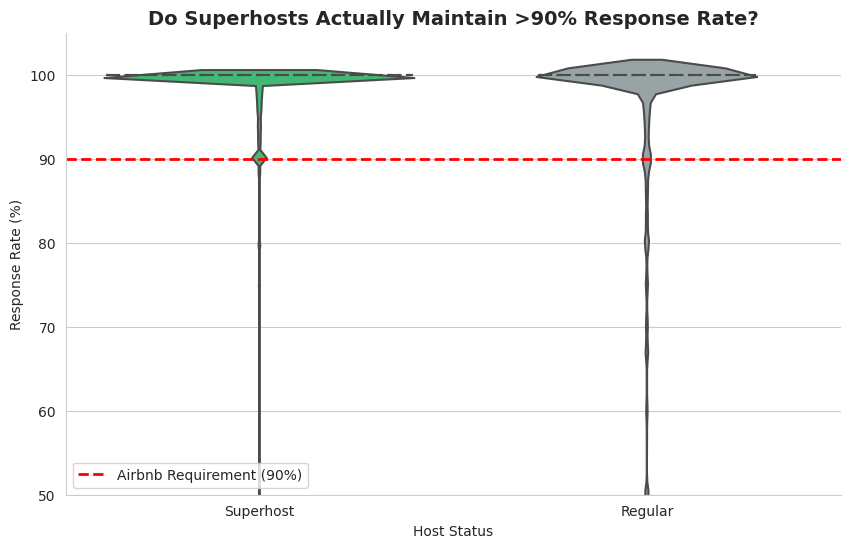

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql.functions import col, when

# --- 1. DATA PREPARATION ---
# We use global_train_df (your cleaned dataset)
df_check = global_train_df.select(
    col("is_supperhost"),
    col("host_response_rate") # Already IntegerType per your schema
).withColumn(
    "status", 
    when(col("is_supperhost") == 1, "Superhost")
    .when(col("is_supperhost") == 0, "Regular")
    .otherwise("Unknown")
)

# Filter out nulls/unknowns for cleaner plots
df_check_clean = df_check.filter(
    (col("status") != "Unknown") & 
    col("host_response_rate").isNotNull()
)

# Convert to Pandas for plotting
pdf = df_check_clean.toPandas()

# --- 2. PLOT 1: RESPONSE RATE (The 90% Rule) ---
plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")

# Violin plots show the density of data better than boxplots
# We expect a huge lump at 100% for Superhosts
sns.violinplot(
    data=pdf,
    x="status",
    y="host_response_rate",
    palette={"Superhost": "#2ecc71", "Regular": "#95a5a6"},
    inner="quartile" # Shows the median and quartiles inside
)

# Add a red line at 90% (The Airbnb Requirement)
plt.axhline(90, color='red', linestyle='--', linewidth=2, label="Airbnb Requirement (90%)")

plt.title("Do Superhosts Actually Maintain >90% Response Rate?", fontsize=14, fontweight='bold')
plt.xlabel("Host Status")
plt.ylabel("Response Rate (%)")
plt.legend(loc='lower left')
plt.ylim(50, 105) # Zoom in on the top half (since most are high)
sns.despine()
plt.show()

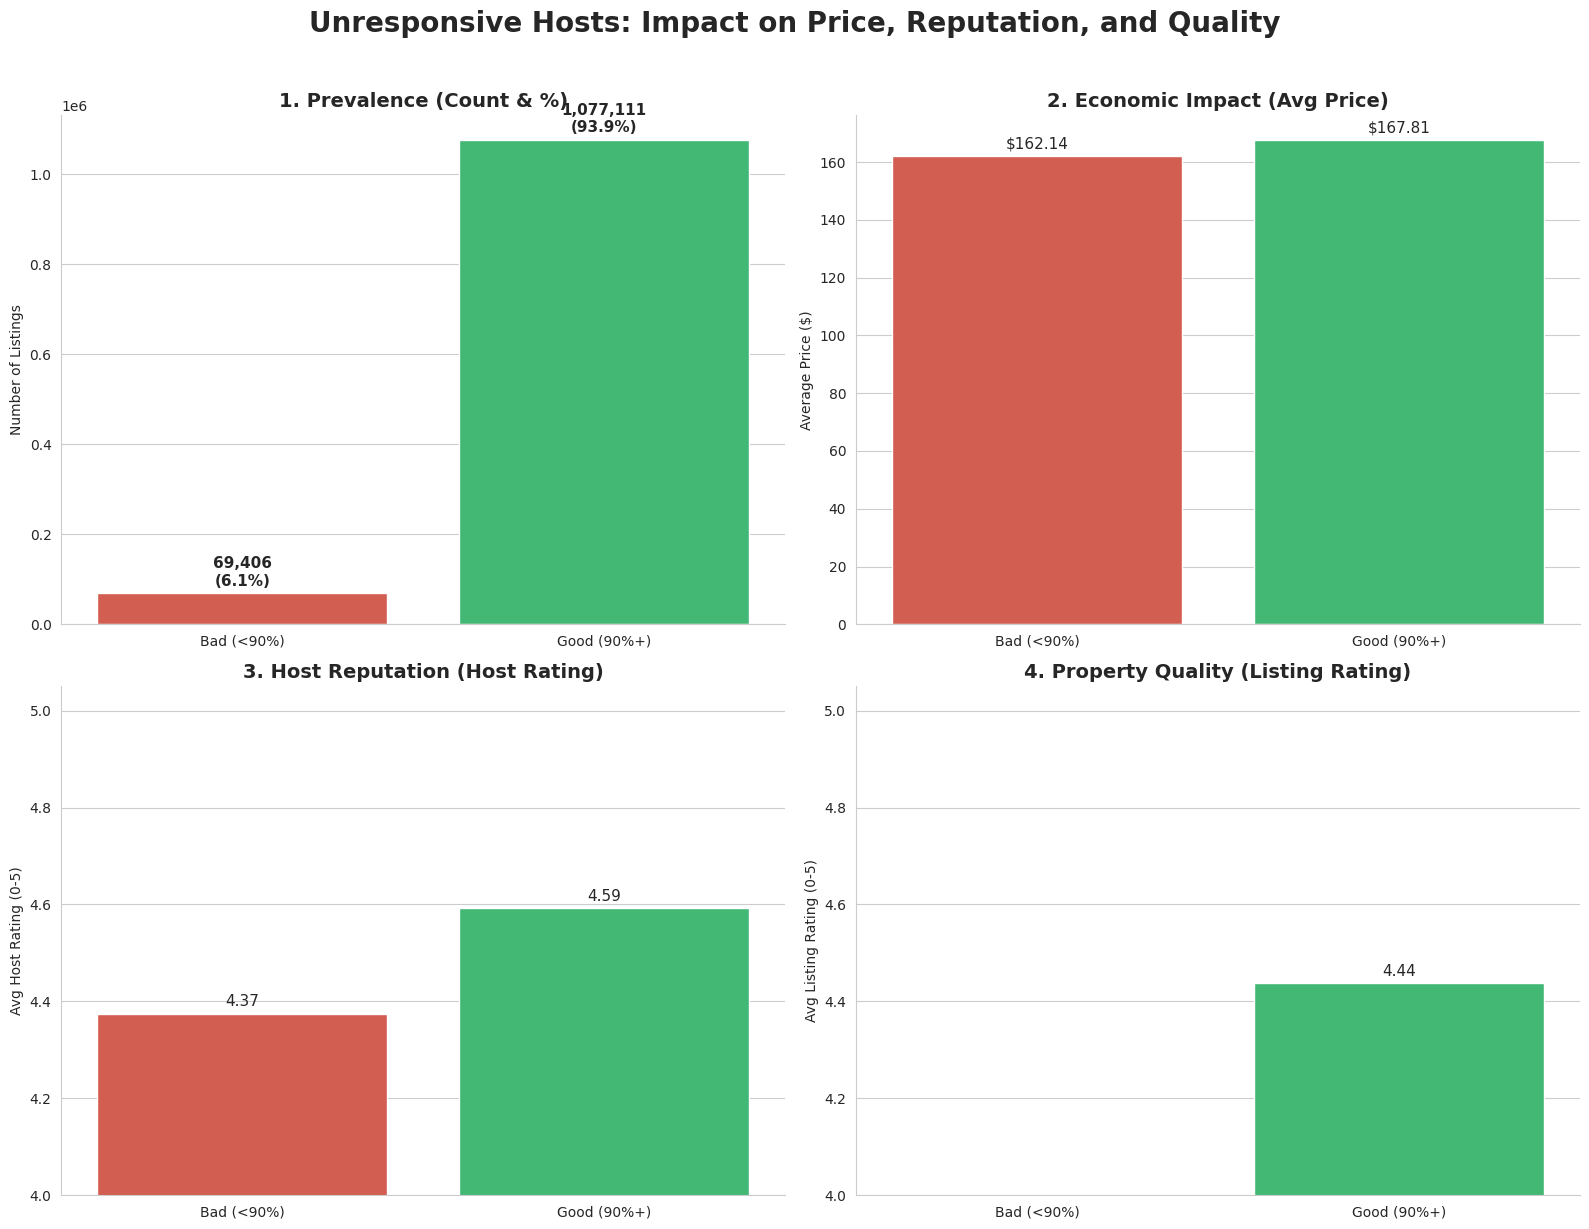

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql.functions import col, when, avg, count, exp

# --- 1. DATA PREPARATION (PySpark) ---
# Use global_train_df
# We convert log_price back to real dollars for readability
df_prep = global_train_df.withColumn(
    "price_estimated", 
    exp(col("log_price")) 
).withColumn(
    "is_unresponsive", 
    when(col("host_response_rate") < 90, "Bad (<90%)").otherwise("Good (90%+)")
)

# Aggregate Metrics
impact_check = df_prep.groupBy("is_unresponsive").agg(
    count("*").alias("count"),
    avg("price_estimated").alias("avg_price"), # <-- Now using Real Price
    avg("host_rating").alias("avg_host_rating"),
    avg("ratings").alias("avg_listing_rating")
).toPandas()

# --- 2. PLOTTING (2x2 Grid) ---
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
sns.set_style("whitegrid")
palette = {"Good (90%+)": "#2ecc71", "Bad (<90%)": "#e74c3c"} 

ax_flat = axes.flatten()

# --- A. PREVALENCE ---
sns.barplot(data=impact_check, x="is_unresponsive", y="count", ax=ax_flat[0], palette=palette)
ax_flat[0].set_title("1. Prevalence (Count & %)", fontsize=14, fontweight='bold')
ax_flat[0].set_ylabel("Number of Listings")
ax_flat[0].set_xlabel("")

total_listings = impact_check["count"].sum()
for container in ax_flat[0].containers:
    labels = [f'{val:,.0f}\n({val/total_listings*100:.1f}%)' for val in container.datavalues]
    ax_flat[0].bar_label(container, labels=labels, padding=3, fontsize=11, fontweight='bold')

# --- B. PRICE (Converted to Dollars) ---
sns.barplot(data=impact_check, x="is_unresponsive", y="avg_price", ax=ax_flat[1], palette=palette)
ax_flat[1].set_title("2. Economic Impact (Avg Price)", fontsize=14, fontweight='bold')
ax_flat[1].set_ylabel("Average Price ($)") 
ax_flat[1].set_xlabel("")
for container in ax_flat[1].containers:
    ax_flat[1].bar_label(container, fmt='$%.2f', padding=3, fontsize=11) # Added $ back

# --- C. HOST RATING ---
sns.barplot(data=impact_check, x="is_unresponsive", y="avg_host_rating", ax=ax_flat[2], palette=palette)
ax_flat[2].set_title("3. Host Reputation (Host Rating)", fontsize=14, fontweight='bold')
ax_flat[2].set_ylabel("Avg Host Rating (0-5)")
ax_flat[2].set_xlabel("")
ax_flat[2].set_ylim(4.0, 5.05) 
for container in ax_flat[2].containers:
    ax_flat[2].bar_label(container, fmt='%.2f', padding=3, fontsize=11)

# --- D. LISTING RATING ---
sns.barplot(data=impact_check, x="is_unresponsive", y="avg_listing_rating", ax=ax_flat[3], palette=palette)
ax_flat[3].set_title("4. Property Quality (Listing Rating)", fontsize=14, fontweight='bold')
ax_flat[3].set_ylabel("Avg Listing Rating (0-5)")
ax_flat[3].set_xlabel("")
ax_flat[3].set_ylim(4.0, 5.05) 
for container in ax_flat[3].containers:
    ax_flat[3].bar_label(container, fmt='%.2f', padding=3, fontsize=11)

plt.suptitle("Unresponsive Hosts: Impact on Price, Reputation, and Quality", fontsize=20, fontweight='bold', y=1.02)
sns.despine()
plt.tight_layout()
plt.show()

#### Years on Airbnb

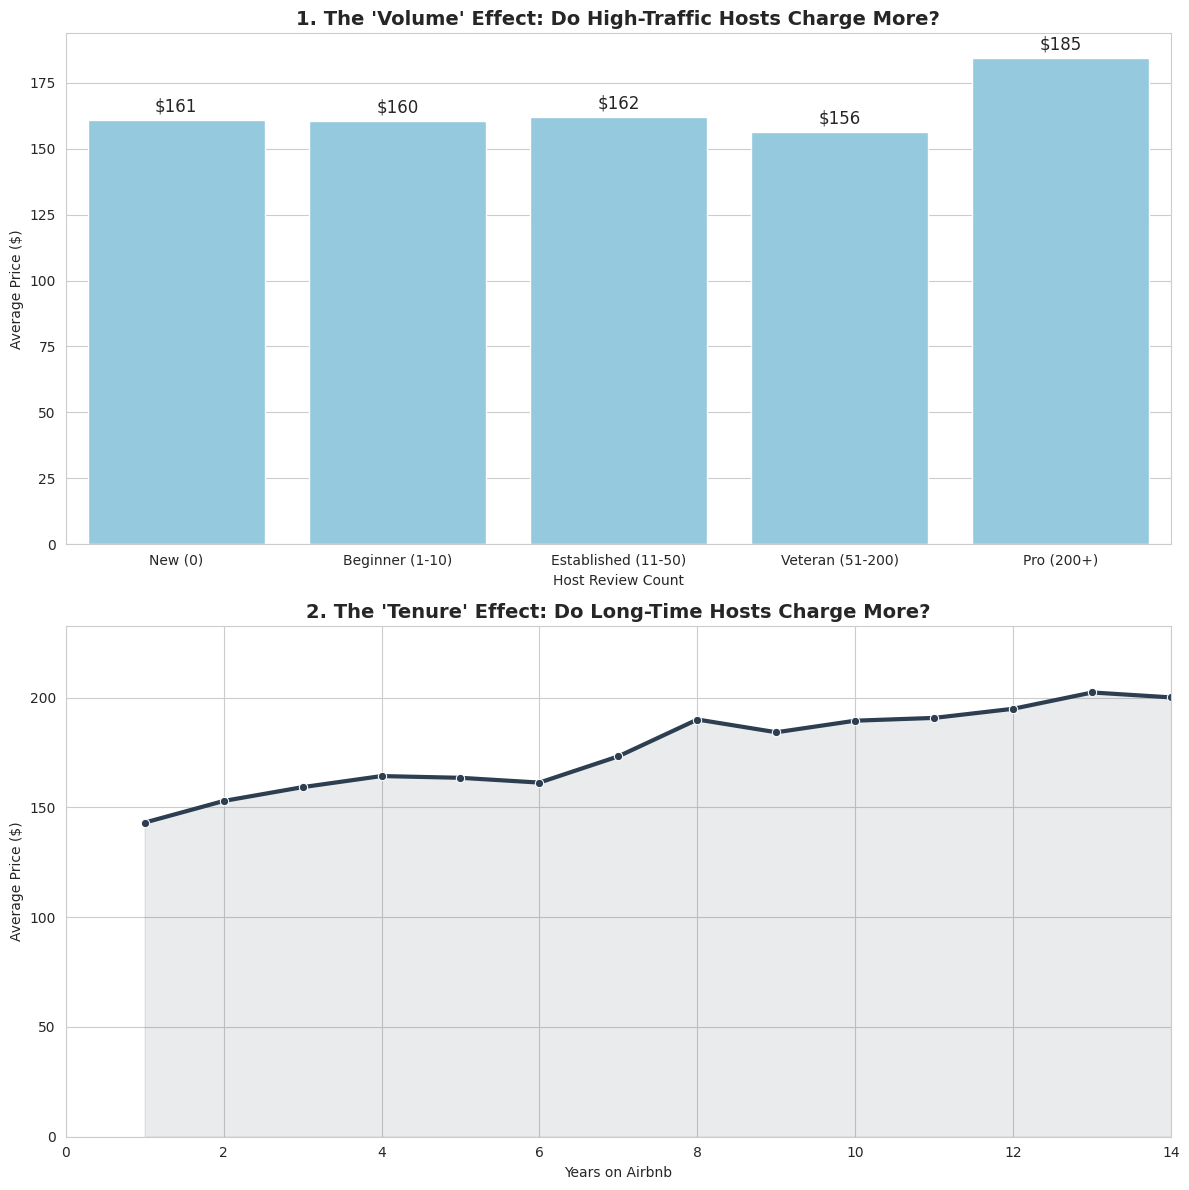

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql.functions import col, when, avg, count, exp

# --- 1. DATA PREPARATION ---
# Use global_train_df
df_host_exp = global_train_df.withColumn(
    "price_estimated", 
    exp(col("log_price")) # Convert Log Price back to $
).withColumn(
    "review_count", 
    col("host_number_of_reviews") # Already Integer
).withColumn(
    "years_hosting", 
    col("hosts_year") # Already Integer
)

# Create "Volume Buckets" (Review Count)
df_host_exp = df_host_exp.withColumn(
    "volume_level",
    when(col("review_count") == 0, "New (0)")
    .when(col("review_count") <= 10, "Beginner (1-10)")
    .when(col("review_count") <= 50, "Established (11-50)")
    .when(col("review_count") <= 200, "Veteran (51-200)")
    .otherwise("Pro (200+)")
)

# --- 2. AGGREGATE DATA ---
# A. Volume Impact
vol_impact = df_host_exp.groupBy("volume_level").agg(
    avg("price_estimated").alias("avg_price"),
    count("*").alias("count")
).toPandas()

# Sort Volume Buckets using a custom map to ensure logical order
order_map = {"New (0)": 0, "Beginner (1-10)": 1, "Established (11-50)": 2, "Veteran (51-200)": 3, "Pro (200+)": 4}
vol_impact["sort_order"] = vol_impact["volume_level"].map(order_map)
vol_impact = vol_impact.sort_values("sort_order")

# B. Tenure Impact (Years on Platform)
tenure_impact = df_host_exp.filter(col("years_hosting").isNotNull()) \
    .groupBy("years_hosting").agg(
        avg("price_estimated").alias("avg_price"),
        count("*").alias("count")
    ).orderBy("years_hosting").toPandas()

# --- 3. PLOTTING ---
fig, axes = plt.subplots(2, 1, figsize=(12, 12))
sns.set_style("whitegrid")

# PLOT A: VOLUME (Number of Reviews)
sns.barplot(data=vol_impact, x="volume_level", y="avg_price", ax=axes[0], color="skyblue")
axes[0].set_title("1. The 'Volume' Effect: Do High-Traffic Hosts Charge More?", fontsize=14, fontweight='bold')
axes[0].set_xlabel("Host Review Count")
axes[0].set_ylabel("Average Price ($)")

for container in axes[0].containers:
    axes[0].bar_label(container, fmt='$%.0f', padding=3, fontsize=12)

# PLOT B: TENURE (Years on Platform)
# We use a line plot to see the trajectory of price over years of experience
sns.lineplot(data=tenure_impact, x="years_hosting", y="avg_price", ax=axes[1], marker="o", linewidth=3, color="#2c3e50")
axes[1].fill_between(tenure_impact["years_hosting"], 0, tenure_impact["avg_price"], alpha=0.1, color="#2c3e50")

axes[1].set_title("2. The 'Tenure' Effect: Do Long-Time Hosts Charge More?", fontsize=14, fontweight='bold')
axes[1].set_xlabel("Years on Airbnb")
axes[1].set_ylabel("Average Price ($)")

# Safety limits for the plot
if not tenure_impact.empty:
    axes[1].set_xlim(0, tenure_impact["years_hosting"].max())
    axes[1].set_ylim(0, tenure_impact["avg_price"].max() * 1.15)

plt.tight_layout()
plt.show()

#### Host Reviews

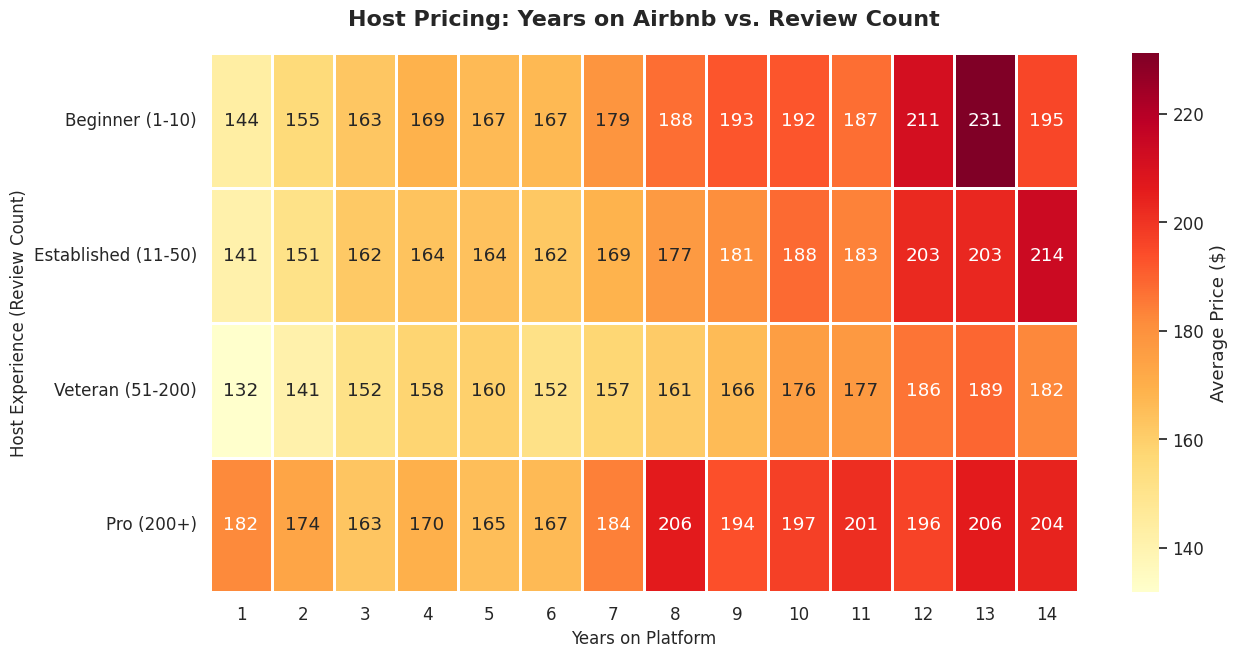

In [0]:
import seaborn as sns
import matplotlib.pyplot as plt
from pyspark.sql.functions import col, when, avg, exp

# --- 1. PREPARE DATA ---
# Use global_train_df
df_heatmap = global_train_df.withColumn(
    "price_estimated", 
    exp(col("log_price")) # Convert Log Price back to $
).withColumn(
    "review_count", 
    col("host_number_of_reviews") # Already Integer
).withColumn(
    "years_hosting", 
    col("hosts_year") # Already Integer
)

# Create Buckets
df_heatmap = df_heatmap.withColumn(
    "review_bucket",
    when(col("review_count") <= 10, "Beginner (1-10)")
    .when(col("review_count") <= 50, "Established (11-50)")
    .when(col("review_count") <= 200, "Veteran (51-200)")
    .otherwise("Pro (200+)")
)

# Filter:
# 1. Years 1-14
df_heatmap_agg = df_heatmap.filter(
    (col("years_hosting") >= 1) & 
    (col("years_hosting") <= 14)
).groupBy("review_bucket", "years_hosting").agg(
    avg("price_estimated").alias("avg_price")
).toPandas()

# Pivot
heatmap_data = df_heatmap_agg.pivot(index="review_bucket", columns="years_hosting", values="avg_price")

# Reorder rows (4 classes) to ensure logical progression from Beginner to Pro
heatmap_data = heatmap_data.reindex([
    "Beginner (1-10)", 
    "Established (11-50)", 
    "Veteran (51-200)", 
    "Pro (200+)"
])

# --- 2. PLOT ---
plt.figure(figsize=(14, 7))
sns.set(font_scale=1.1)

ax = sns.heatmap(
    heatmap_data, 
    annot=True, 
    fmt=".0f", 
    cmap="YlOrRd", 
    linewidths=1, 
    linecolor='white',
    cbar_kws={'label': 'Average Price ($)'}
)

plt.title("Host Pricing: Years on Airbnb vs. Review Count", fontsize=16, fontweight='bold', pad=20)
plt.xlabel("Years on Platform", fontsize=12)
plt.ylabel("Host Experience (Review Count)", fontsize=12)
plt.yticks(rotation=0)
plt.show()

### Listing Related

#### Location

In [0]:
import plotly.express as px
import numpy as np
from pyspark.sql.functions import col, count, avg, exp

# 1. EXTRACT & AGGREGATE
price_stats_df = (
    global_train_df
    .filter(col("country").isNotNull()) 
    .groupBy("country")
    .agg(
        # Convert Log Price -> Real Price ($), then Average it
        avg(exp(col("log_price"))).alias("avg_price"),
        count("*").alias("listing_count")
    )
    # STATISTICAL STABILITY: Filter out countries with < 50 listings
    # (Avoids 1 luxury mansion skewing an entire country)
    .filter(col("listing_count") > 50)
    .withColumnRenamed("country", "Country")
)

# 2. COLLECT TO PANDAS
pdf_price = price_stats_df.toPandas()

# 3. VISUALIZATION (Log Scale & Colorbar)
# We calculate log10 of the PRICE for the color scale
pdf_price["log_price_color"] = np.log10(pdf_price["avg_price"])

# Plot map
fig = px.choropleth(
    pdf_price,
    locations="Country",
    locationmode='country names',
    color="log_price_color",        # Color based on Log Price (for contrast)
    hover_name="Country",
    hover_data={
        "avg_price": ":$.2f",       # Show Real Price ($120.00)
        "listing_count": ":,",      # Show Count
        "log_price_color": False    # Hide math
    },
    # 'Reds' is intuitive for cost (Darker = More Expensive)
    color_continuous_scale='Reds', 
    title="Global Price Heatmap (Avg Nightly Rate)"
)

# 4. Add the Readable Color Bar
fig.update_layout(
    geo=dict(
        showframe=False,
        showcoastlines=True,
        projection_type='natural earth'
    ),
    width=1000,
    height=800,
    # Transform log numbers (1.5, 2, 2.5) back to readable Prices ($30, $100, $300)
    coloraxis_colorbar=dict(
        title="Avg Price ($)",
        # 1.5=$31, 2=$100, 2.5=$316, 3=$1000
        tickvals=[1.5, 2, 2.5, 3],
        ticktext=["$30", "$100", "$300", "$1k"]
    )
)

fig.show()

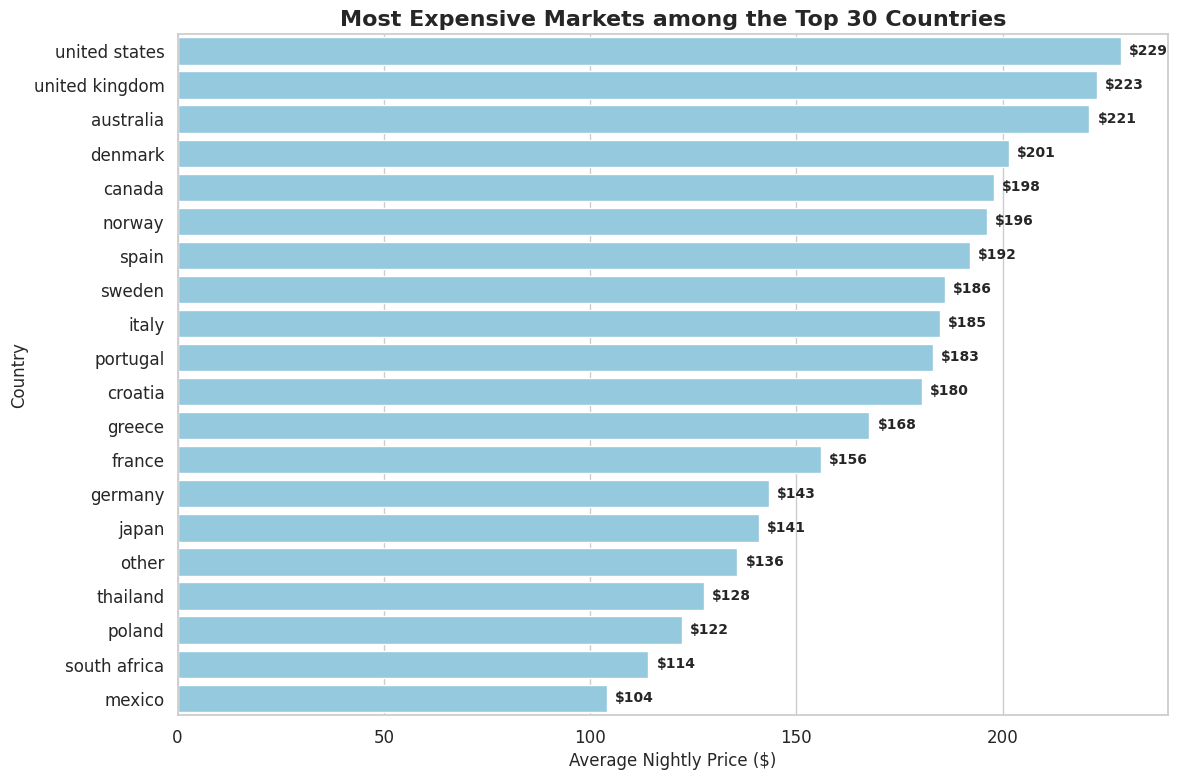

In [0]:
import seaborn as sns
import matplotlib.pyplot as plt
from pyspark.sql.functions import col, avg, count, desc, exp

# --- 1. AGGREGATE STATS ---
df_stats = (
    global_train_df
    .filter(col("country").isNotNull())
    .withColumn("real_price", exp(col("log_price")))
    .filter(col("real_price") <= 2000) 
    .groupBy("country")
    .agg(
        count("*").alias("listing_count"),
        avg("real_price").alias("avg_price")
    )
)

# --- 2. APPLY ZIPF FILTER (Top 30 by Volume) ---
# We take only the 30 countries with the MOST listings
df_top_30_volume = (
    df_stats
    .orderBy(desc("listing_count"))
    .limit(30)  # <--- CHANGED TO 30
)

# --- 3. COLLECT & SORT BY PRICE ---
pdf_top_30 = df_top_30_volume.toPandas()

# Sort these 30 popular countries by PRICE to see which are the most expensive
# We take all 30 or the top 20 for the plot
pdf_expensive_rank = pdf_top_30.sort_values("avg_price", ascending=False).head(20)

# --- 4. PLOT ---
plt.figure(figsize=(12, 8))
sns.set_style("whitegrid")

barplot = sns.barplot(
    data=pdf_expensive_rank,
    x="avg_price",
    y="country",
    color="skyblue"
)

plt.title("Most Expensive Markets among the Top 30 Countries", fontsize=16, fontweight='bold')
plt.xlabel("Average Nightly Price ($)", fontsize=12)
plt.ylabel("Country", fontsize=12)

# Add Labels
for i, p in enumerate(barplot.patches):
    width = p.get_width()
    plt.text(
        width + 2, 
        p.get_y() + p.get_height()/2 + 0.1, 
        f"${width:,.0f}", 
        ha="left", 
        fontsize=10, 
        fontweight='bold', 
    )

plt.tight_layout()
plt.show()

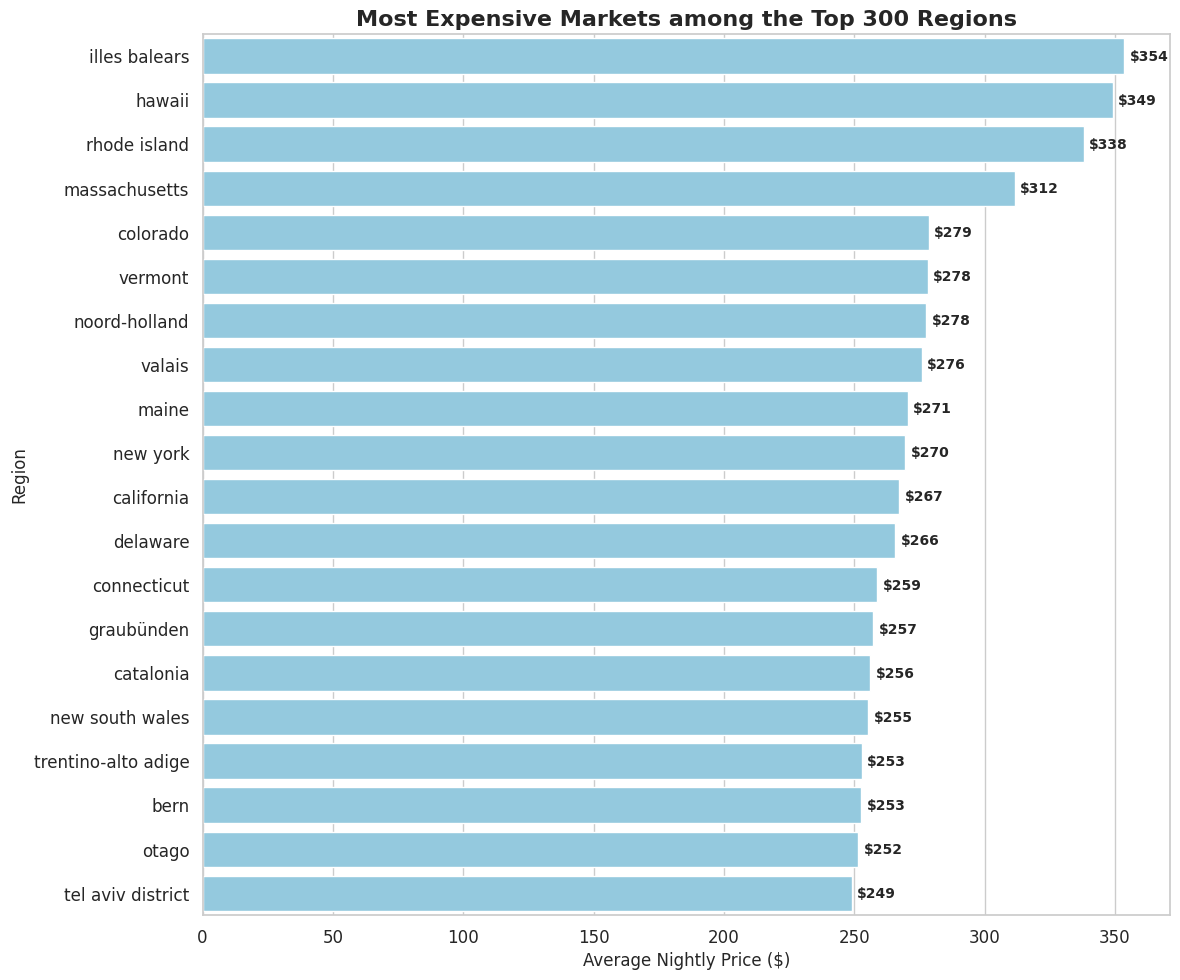

In [0]:
import seaborn as sns
import matplotlib.pyplot as plt
from pyspark.sql.functions import col, avg, count, desc, exp

# --- 1. AGGREGATE STATS BY REGION ---
df_region_stats = (
    global_train_df
    .filter(col("region").isNotNull())
    .withColumn("real_price", exp(col("log_price")))
    .filter(col("real_price") <= 2000) 
    .groupBy("region")
    .agg(
        count("*").alias("listing_count"),
        avg("real_price").alias("avg_price")
    )
)

# --- 2. APPLY ZIPF FILTER (Top 300 Regions by Volume) ---
# We take the 300 regions with the MOST listings to ensure statistical significance
df_top_300_regions = (
    df_region_stats
    .orderBy(desc("listing_count"))
    .limit(300)
)

# --- 3. COLLECT & SORT BY PRICE ---
pdf_top_300_regions = df_top_300_regions.toPandas()

# Sort these 300 popular regions by PRICE to find the most expensive ones
# We visualize the Top 20 most expensive from this group
pdf_expensive_regions = pdf_top_300_regions.sort_values("avg_price", ascending=False).head(20)

# --- 4. PLOT ---
plt.figure(figsize=(12, 10)) # Slightly taller for region names
sns.set_style("whitegrid")

barplot = sns.barplot(
    data=pdf_expensive_regions,
    x="avg_price",
    y="region",
    color="skyblue"
)

plt.title("Most Expensive Markets among the Top 300 Regions", fontsize=16, fontweight='bold')
plt.xlabel("Average Nightly Price ($)", fontsize=12)
plt.ylabel("Region", fontsize=12)

# Add Labels
for i, p in enumerate(barplot.patches):
    width = p.get_width()
    plt.text(
        width + 2, 
        p.get_y() + p.get_height()/2 + 0.1, 
        f"${width:,.0f}", 
        ha="left", 
        fontsize=10, 
        fontweight='bold', 
    )

plt.tight_layout()
plt.show()

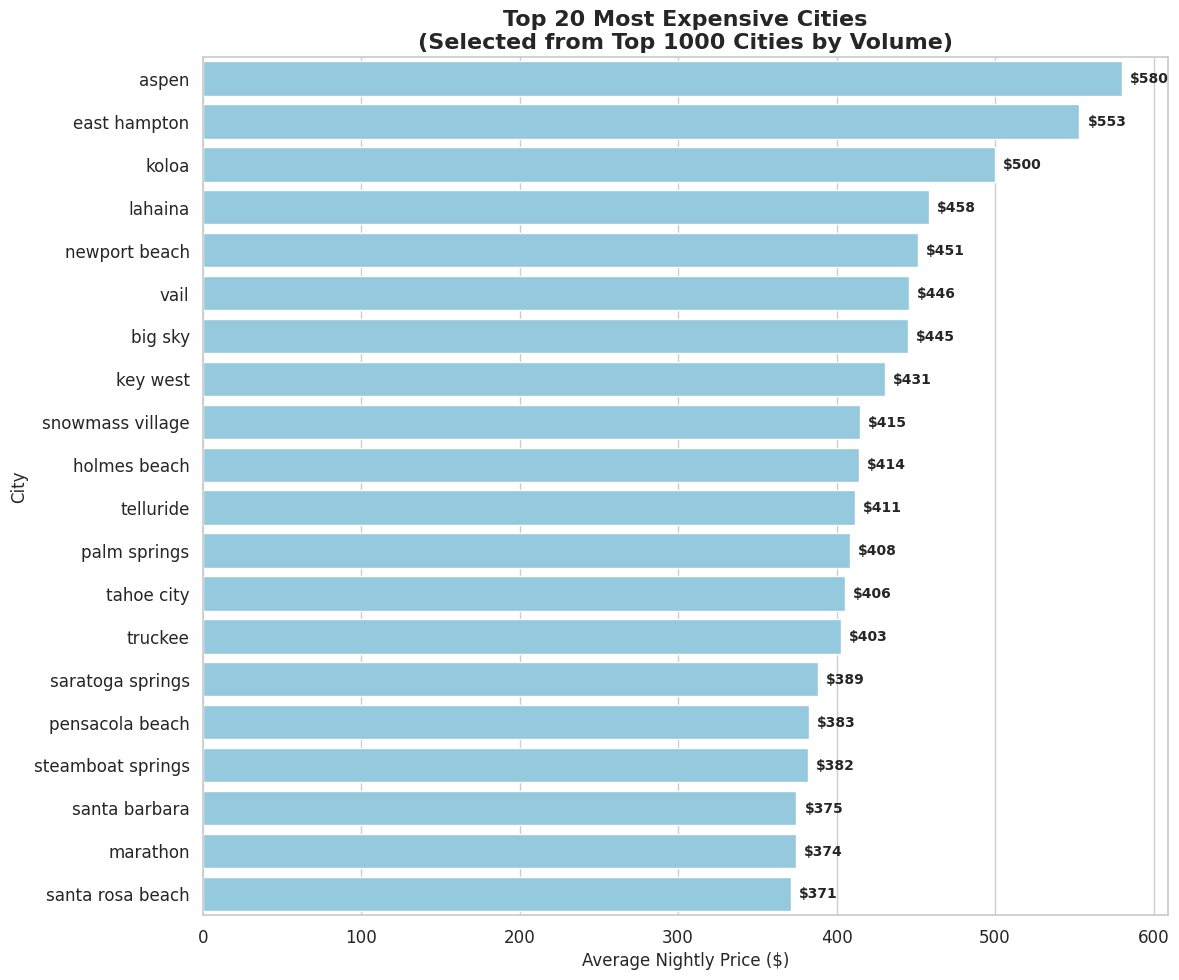

In [0]:
import seaborn as sns
import matplotlib.pyplot as plt
from pyspark.sql.functions import col, avg, count, desc, exp

# --- 1. AGGREGATE STATS BY CITY ---
df_city_stats = (
    global_train_df
    .filter(col("city").isNotNull())
    .withColumn("real_price", exp(col("log_price")))
    # Filter extreme outliers to keep the average representative
    .filter(col("real_price") <= 2000) 
    .groupBy("city")
    .agg(
        count("*").alias("listing_count"),
        avg("real_price").alias("avg_price")
    )
)

# --- 2. APPLY ZIPF FILTER (Top 1000 Cities by Volume) ---
# We take the 1000 cities with the MOST listings
df_top_1000_cities = (
    df_city_stats
    .orderBy(desc("listing_count"))
    .limit(1000)
)

# --- 3. COLLECT & SORT BY PRICE ---
pdf_top_1000 = df_top_1000_cities.toPandas()

# From these 1000 popular cities, we find the 20 with the highest average price
pdf_expensive_cities = pdf_top_1000.sort_values("avg_price", ascending=False).head(20)

# --- 4. PLOT ---
plt.figure(figsize=(12, 10))
sns.set_style("whitegrid")

barplot = sns.barplot(
    data=pdf_expensive_cities,
    x="avg_price",
    y="city",
    color="skyblue"
)

plt.title("Top 20 Most Expensive Cities\n(Selected from Top 1000 Cities by Volume)", fontsize=16, fontweight='bold')
plt.xlabel("Average Nightly Price ($)", fontsize=12)
plt.ylabel("City", fontsize=12)

# Add Labels for each bar
for i, p in enumerate(barplot.patches):
    width = p.get_width()
    plt.text(
        width + 5, 
        p.get_y() + p.get_height()/2 + 0.1, 
        f"${width:,.0f}", 
        ha="left", 
        fontsize=10, 
        fontweight='bold'
    )

plt.tight_layout()
plt.show()

In [0]:
import plotly.express as px
import numpy as np
from pyspark.sql.functions import col, exp

# --- 1. DATA PREPARATION ---
# We MUST sample. Plotting millions of points will crash the browser.
# 1% sample (0.01) is usually enough to see the patterns.
df_geo_sample = (
    global_train_df
    .select("lat", "long", "log_price", "city", "country")
    .filter(col("lat").isNotNull() & col("long").isNotNull())
    .sample(withReplacement=False, fraction=0.01, seed=42)
)

# Convert to Pandas
pdf_geo = df_geo_sample.toPandas()

# Calculate Real Price for the tooltip and color scaling
pdf_geo["price"] = np.exp(pdf_geo["log_price"])
pdf_geo["log_price_color"] = pdf_geo["log_price"] # Use log for color scaling to see contrast

# --- 2. PLOT ---
fig = px.scatter_mapbox(
    pdf_geo,
    lat="lat",
    lon="long",
    color="log_price_color",     # Color by Price
    size="price",                # Larger bubbles = Higher Price (optional, can remove if too cluttered)
    size_max=15,
    hover_name="city",
    hover_data={
        "price": ":$.0f",
        "country": True,
        "log_price_color": False,
        "lat": False,
        "long": False
    },
    color_continuous_scale="Jet", # Jet/Rainbow highlights hotspots well
    zoom=1,
    mapbox_style="open-street-map", # Free map style (no token needed)
    title="Global Price Clusters: Do Lat/Long Matter?"
)

fig.update_layout(
    width=1000, 
    height=800,
    coloraxis_colorbar=dict(
        title="Log Price",
        tickvals=[np.log(30), np.log(100), np.log(300), np.log(1000)],
        ticktext=["$30", "$100", "$300", "$1k"]
    )
)

fig.show()

#### Maximal guests

Pearson Correlation (Guests vs Log Price): 0.4827


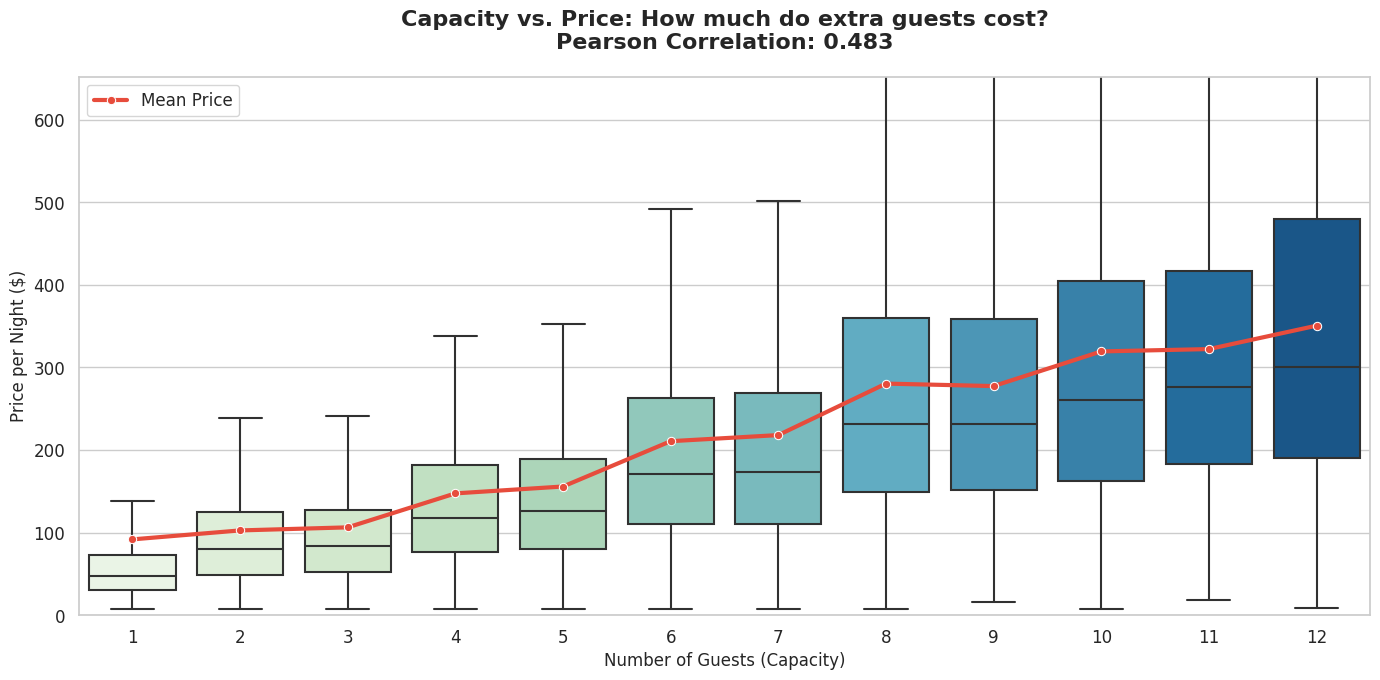

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql.functions import col, exp, avg

# --- 1. DATA PREPARATION ---
# Select columns, cast guests to int, and calculate real price
df_guests = global_train_df.select(
    col("guests").cast("int"), 
    col("log_price")
).filter(
    col("guests").isNotNull() & 
    col("log_price").isNotNull()
).withColumn("real_price", exp(col("log_price")))

# --- 2. STATISTICAL CORRELATION ---
# Correlation with log_price is more accurate for linear trends
corr_val = df_guests.stat.corr("guests", "log_price")
print(f"Pearson Correlation (Guests vs Log Price): {corr_val:.4f}")

# --- 3. SAMPLING & AGGREGATION ---
# Sample 10% for the boxplot to keep visualization clean
pdf_sample = df_guests.sample(False, 0.1, seed=42).toPandas()

# Aggregate averages to overlay a trend line
avg_prices = df_guests.groupBy("guests").agg(avg("real_price").alias("avg_price")).orderBy("guests").toPandas()

# --- 4. VISUALIZATION ---
plt.figure(figsize=(14, 7))
sns.set_style("whitegrid")

# Plot A: Boxplot to show distribution and variance per guest count
# We hide extreme outliers (showfliers=False) to keep the boxes readable
sns.boxplot(
    data=pdf_sample, 
    x="guests", 
    y="real_price", 
    palette="GnBu",
    showfliers=False
)

# Plot B: Line Plot overlay to show the average price trend
# We use the 'avg_prices' dataframe calculated on the full Spark dataset
sns.lineplot(
    data=avg_prices, 
    x=avg_prices["guests"] - 1, # Offset by 1 to align with 0-indexed x-axis of boxplot
    y="avg_price", 
    color="#e74c3c", 
    marker="o", 
    label="Mean Price",
    linewidth=3
)

# Formatting
plt.title(f"Capacity vs. Price: How much do extra guests cost?\nPearson Correlation: {corr_val:.3f}", fontsize=16, fontweight='bold', pad=20)
plt.xlabel("Number of Guests (Capacity)", fontsize=12)
plt.ylabel("Price per Night ($)", fontsize=12)
plt.legend(loc='upper left')

# Limit Y-axis to the 95th percentile to focus on the main data
plt.ylim(0, pdf_sample['real_price'].quantile(0.98)) 

plt.tight_layout()
plt.show()

#### Rating

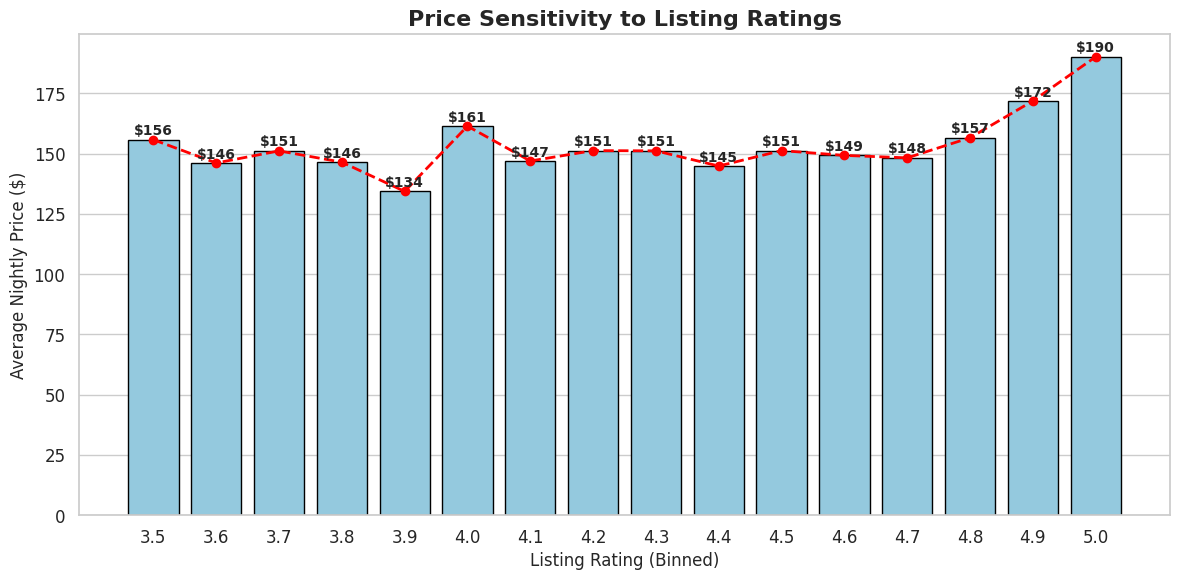

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql.functions import col, exp, floor, avg

# --- 1. DATA PREPARATION ---
# We create "Rating Bins" (e.g., 4.1, 4.2, 4.3...) to see the trend clearly
df_binned = global_train_df.select(
    col("ratings"), 
    col("log_price")
).filter(
    (col("ratings") >= 3.5) & (col("ratings") <= 5.0) # Focus on where the data is
).withColumn(
    "rating_bin", (floor(col("ratings") * 10) / 10).cast("float") # Groups into 4.1, 4.2, etc.
).withColumn(
    "real_price", exp(col("log_price"))
)

# --- 2. AGGREGATE ---
# Calculate average price and count of listings per bin
pdf_bins = df_binned.groupBy("rating_bin").agg(
    avg("real_price").alias("avg_price"),
    avg("log_price").alias("avg_log_price")
).orderBy("rating_bin").toPandas()

# --- 3. PLOT ---
plt.figure(figsize=(12, 6))
sns.set_style("whitegrid")

# Create a bar plot
barplot = sns.barplot(
    data=pdf_bins, 
    x="rating_bin", 
    y="avg_price", 
    color="skyblue",
    edgecolor="black"
)

# Add the trend line (Log Price trend is usually smoother)
plt.plot(range(len(pdf_bins)), pdf_bins["avg_price"], marker='o', color='red', linestyle='--', linewidth=2)

# --- 4. FORMATTING ---
plt.title("Price Sensitivity to Listing Ratings", fontsize=16, fontweight='bold')
plt.xlabel("Listing Rating (Binned)", fontsize=12)
plt.ylabel("Average Nightly Price ($)", fontsize=12)

# Add price labels on top of bars
for i, p in enumerate(barplot.patches):
    plt.text(p.get_x() + p.get_width()/2., p.get_height() + 2,
             f'${p.get_height():.0f}', 
             ha="center", fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

## Local Data Feature Selection

### Amenities

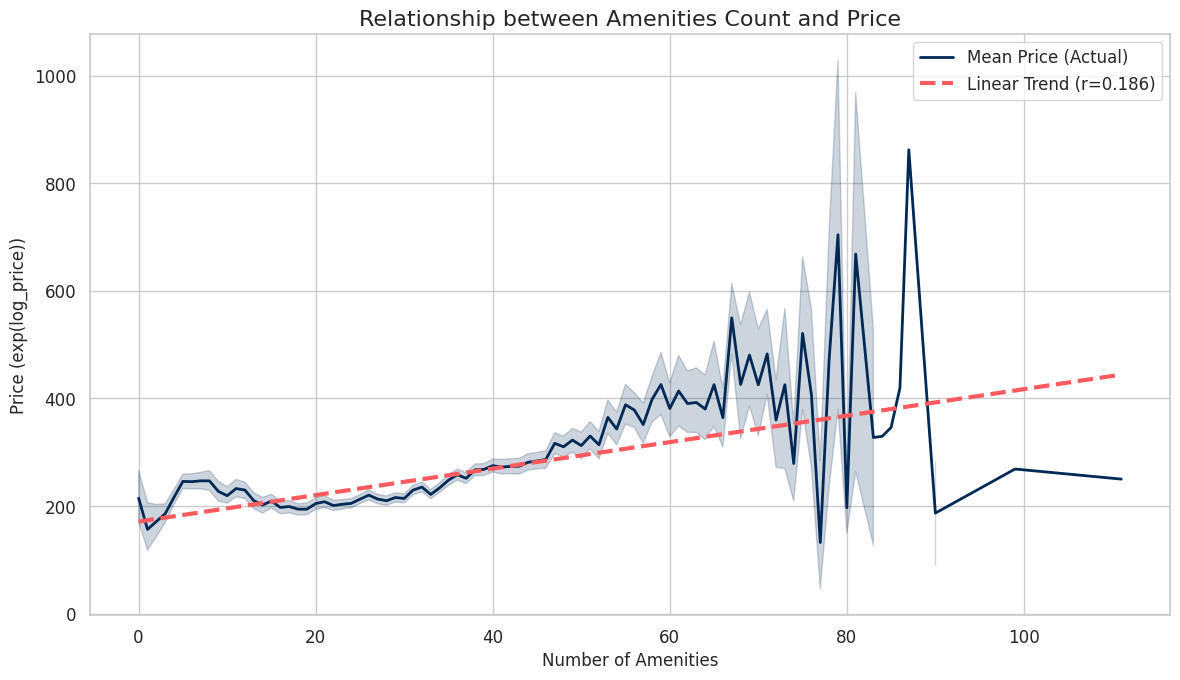

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats

# 1. Prepare data
plot_df = local_train_df.select("amenities_count", "log_price").toPandas()
plot_df['price'] = np.exp(plot_df['log_price'])

# 2. Calculate Correlation and Trend Line stats
slope, intercept, r_value, p_value, std_err = stats.linregress(plot_df['amenities_count'], plot_df['price'])

# 3. Create the Visualization
plt.figure(figsize=(12, 7))
sns.set_style("whitegrid")

# THE "BEFORE" LOOK: Line plot of means with confidence interval
sns.lineplot(data=plot_df, x='amenities_count', y='price', 
             color='#002855', label='Mean Price (Actual)', linewidth=2)

# THE ADDITION: Linear Trend Line in a different color (Red)
x_range = np.array([plot_df['amenities_count'].min(), plot_df['amenities_count'].max()])
plt.plot(x_range, intercept + slope * x_range, 
         color='#FF5A5F', linestyle='--', linewidth=3, label=f'Linear Trend (r={r_value:.3f})')

# 4. Formatting
plt.title('Relationship between Amenities Count and Price', fontsize=16)
plt.xlabel('Number of Amenities', fontsize=12)
plt.ylabel('Price (exp(log_price))', fontsize=12)
plt.legend(fontsize=12)


plt.tight_layout()
plt.show()

### Reviews

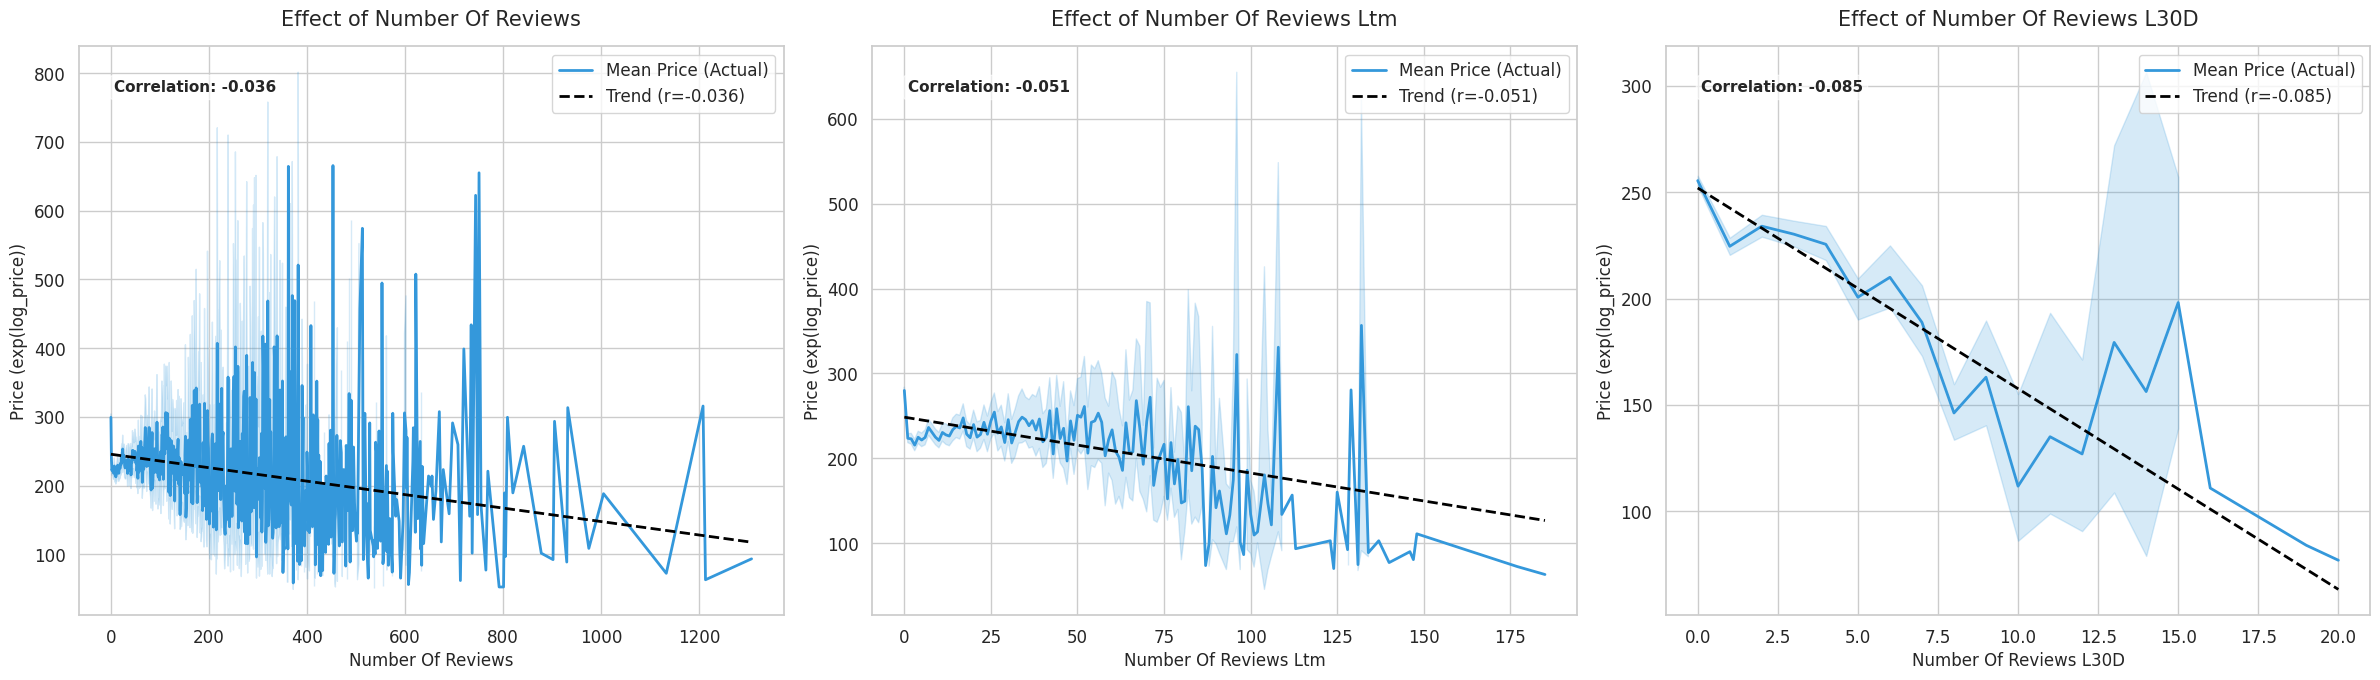

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats

# 1. Prepare data
# We select the three review columns and the price
review_cols = ["number_of_reviews", "number_of_reviews_ltm", "number_of_reviews_l30d"]
plot_df = local_train_df.select(*review_cols, "log_price").toPandas()
plot_df['price'] = np.exp(plot_df['log_price'])

# 2. Create the 1x3 Subplot Figure
fig, axes = plt.subplots(1, 3, figsize=(24, 7))
sns.set_style("whitegrid")

for i, col_name in enumerate(review_cols):
    ax = axes[i]
    
    # Calculate Correlation and Linear Trend
    # Dropping NaNs for the specific column calculation
    temp_df = plot_df[[col_name, 'price']].dropna()
    slope, intercept, r_val, _, _ = stats.linregress(temp_df[col_name], temp_df['price'])
    
    # Plot 1: Mean Price (Actual) with Confidence Interval
    sns.lineplot(data=temp_df, x=col_name, y='price', ax=ax, 
                 color='#3498db', label='Mean Price (Actual)', linewidth=2)
    
    # Plot 2: Linear Trend Line (Dashed)
    x_range = np.array([temp_df[col_name].min(), temp_df[col_name].max()])
    ax.plot(x_range, intercept + slope * x_range, 
             color='black', linestyle='--', linewidth=2, label=f'Trend (r={r_val:.3f})')
    
    # Formatting
    clean_title = col_name.replace("_", " ").title()
    ax.set_title(f'Effect of {clean_title}', fontsize=15, pad=15)
    ax.set_xlabel(clean_title, fontsize=12)
    ax.set_ylabel('Price (exp(log_price))', fontsize=12)
    ax.legend()
    
    # Add Correlation Text Box
    ax.text(0.05, 0.92, f'Correlation: {r_val:.3f}', 
            transform=ax.transAxes, fontsize=11, fontweight='bold',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.6))

plt.tight_layout()
plt.show()

### Response Time

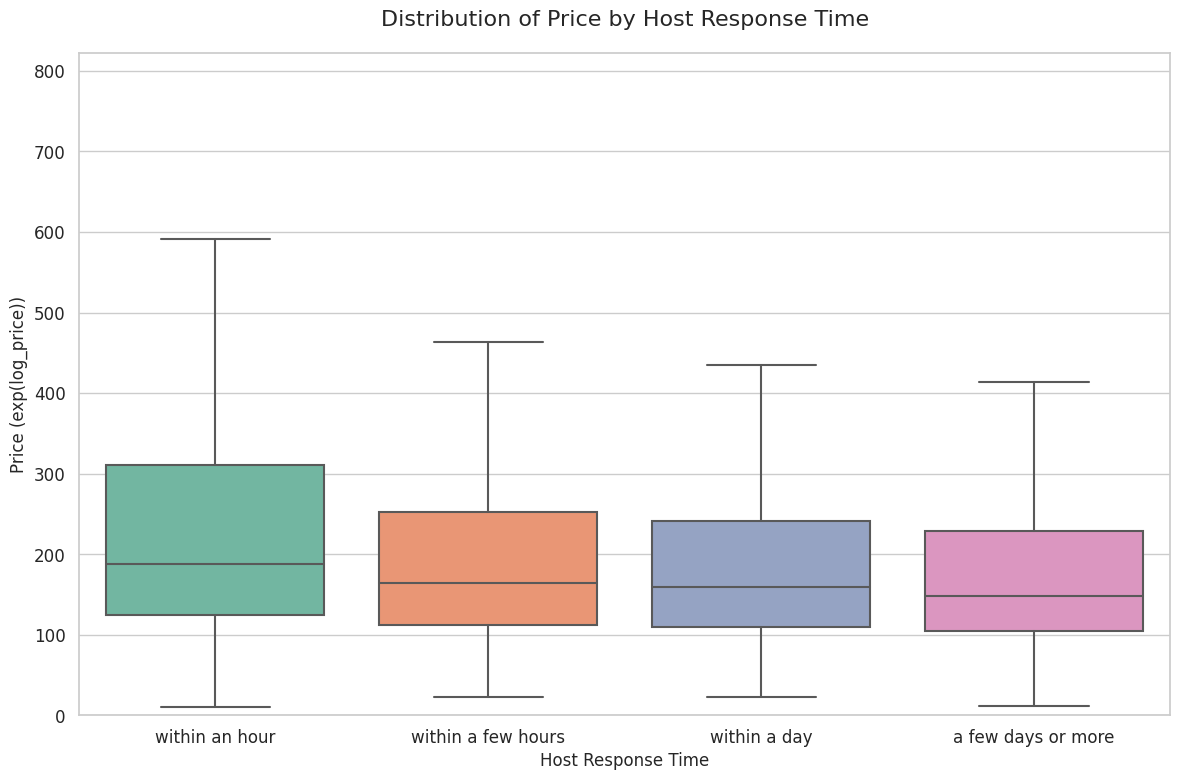

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 1. Prepare data
# We drop NaNs to ensure only valid categories are plotted
plot_df = local_train_df.select("host_response_time", "log_price").dropna().toPandas()
plot_df['price'] = np.exp(plot_df['log_price'])

# 2. Define the logical order for the x-axis
# This prevents them from appearing in random alphabetical order
response_order = ['within an hour', 'within a few hours', 'within a day', 'a few days or more']

# 3. Create the Visualization
plt.figure(figsize=(12, 8))
sns.set_style("whitegrid")

# Boxplot shows the Median (middle line), IQR (the box), and range (whiskers)
sns.boxplot(
    data=plot_df, 
    x='host_response_time', 
    y='price', 
    order=response_order, 
    palette='Set2',
    showfliers=False  # Hides extreme outliers to make boxes readable
)

# 4. Formatting
plt.title('Distribution of Price by Host Response Time', fontsize=16, pad=20)
plt.xlabel('Host Response Time', fontsize=12)
plt.ylabel('Price (exp(log_price))', fontsize=12)

# Zoom in on 98% of the data to keep the focus on the main distribution
plt.ylim(0, plot_df['price'].quantile(0.98))

plt.tight_layout()
plt.show()

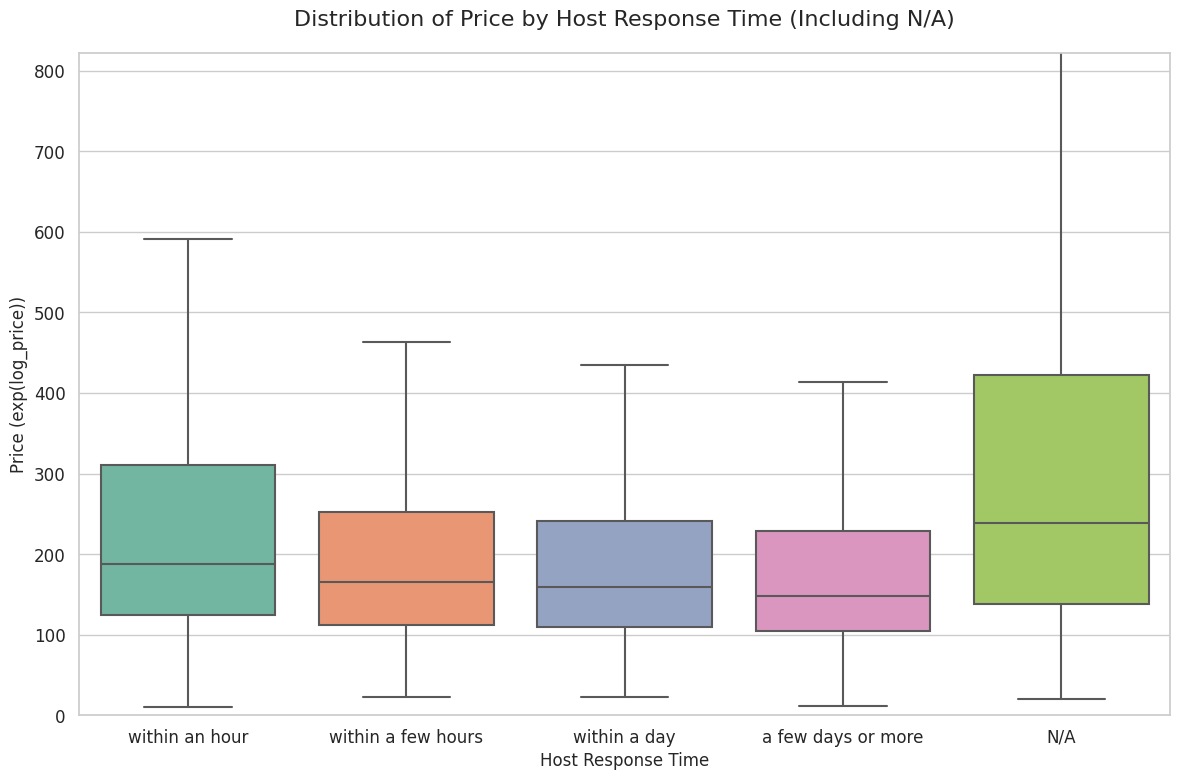

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from pyspark.sql.functions import col

# 1. Prepare data - fill nulls with "N/A"
plot_df = local_train_df.select("host_response_time", "log_price") \
    .fillna("N/A", subset=["host_response_time"]) \
    .toPandas()

plot_df['price'] = np.exp(plot_df['log_price'])

# 2. Update the order to include "N/A" at the end
response_order = ['within an hour', 'within a few hours', 'within a day', 'a few days or more', 'N/A']

# 3. Create the Visualization
plt.figure(figsize=(12, 8))
sns.set_style("whitegrid")

sns.boxplot(
    data=plot_df, 
    x='host_response_time', 
    y='price', 
    order=response_order, 
    palette='Set2',
    showfliers=False
)

# 4. Formatting
plt.title('Distribution of Price by Host Response Time (Including N/A)', fontsize=16, pad=20)
plt.xlabel('Host Response Time', fontsize=12)
plt.ylabel('Price (exp(log_price))', fontsize=12)

# Zoom in on the main distribution (98th percentile)
plt.ylim(0, plot_df['price'].quantile(0.98))

plt.tight_layout()
plt.show()

## Dataset comparison

In [0]:
from pyspark.sql.functions import col, explode, split, regexp_replace, lower, count, desc, array_intersect, array, lit, size, when

# --- 1. PRESERVE THE ORIGINAL COUNT ---
# Since we know 'amenities' is already an Array, we just use size()
# We add a check for nulls just to be safe
local_train_df = local_train_df.withColumn(
    "amenities_count_raw", 
    when(col("amenities").isNotNull(), size(col("amenities"))).otherwise(0)
)

# --- 2. GET LOCAL TOP 50 ---
# Directly explode the array
local_exploded = local_train_df.select(
    explode(col("amenities")).alias("amenity_raw")
).filter(col("amenity_raw") != "")

local_top_50_rows = local_exploded.groupBy("amenity_raw") \
    .agg(count("*").alias("cnt")) \
    .orderBy(desc("cnt")).limit(50).collect()

# Create mapping
local_norm_map = {
    row['amenity_raw'].lower().replace(" ", "").replace("_", ""): row['amenity_raw'] 
    for row in local_top_50_rows
}

# --- 3. GET GLOBAL TOP 50 (Assuming top_50_clean exists from previous global step) ---
global_norm_map = {
    x.lower().replace(" ", "").replace("_", ""): x 
    for x in top_50_clean
}

# --- 4. FIND INTERSECTION ---
shared_keys = set(local_norm_map.keys()).intersection(set(global_norm_map.keys()))
shared_original_local = sorted([local_norm_map[k] for k in shared_keys])

# --- 5. APPLY FILTER TO AMENITIES LIST ---
# Keep only the Top 50 items within the array
top_50_local_list = [row['amenity_raw'] for row in local_top_50_rows]
top_50_col = array([lit(x) for x in top_50_local_list])

local_train_df = local_train_df.withColumn(
    "amenities", 
    array_intersect(col("amenities"), top_50_col)
)

# --- 6. RESULTS & VERIFICATION ---
print(f"Total Shared Amenities found: {len(shared_keys)}")
print(f"✅ SHARED: {shared_original_local}")

print("\n📍 ONLY IN PARIS (Local):")
print(sorted([local_norm_map[k] for k in set(local_norm_map.keys()) - shared_keys]))

print("\n--- Final Data Check ---")
# amenities is now shorter (filtered), but amenities_count_raw is the original length
local_train_df.select("amenities", "amenities_count_raw").show(5, truncate=80)

Total Shared Amenities found: 19
✅ SHARED: ['Baking sheet', 'Bathtub', 'Coffee maker', 'Dining table', 'Dishwasher', 'First aid kit', 'Hair dryer', 'Hangers', 'Hot water', 'Iron', 'Microwave', 'Oven', 'Refrigerator', 'Shampoo', 'Stove', 'TV', 'Toaster', 'Washer', 'Wifi']

📍 ONLY IN PARIS (Local):
['Bed linens', 'Body soap', 'Books and reading material', 'Carbon monoxide alarm', 'Central heating', 'Cleaning products', 'Clothing storage', 'Coffee', 'Cooking basics', 'Dedicated workspace', 'Dishes and silverware', 'Drying rack for clothing', 'Elevator', 'Essentials', 'Extra pillows and blankets', 'Freezer', 'Heating', 'Host greets you', 'Hot water kettle', 'Kitchen', 'Laundromat nearby', 'Lockbox', 'Long term stays allowed', 'Luggage dropoff allowed', 'Portable fans', 'Private entrance', 'Room-darkening shades', 'Self check-in', 'Shower gel', 'Smoke alarm', 'Wine glasses']

--- Final Data Check ---
+--------------------------------------------------------------------------------+---------

In [0]:
%skip
from pyspark.sql.functions import col, lower, regexp_replace, split, array_contains, lit, transform

# --- 1. DEFINE LISTS (Keep your original lists) ---
shared_list = ['Baking sheet', 'Bathtub', 'Coffee maker', 'Dining table', 'Dishwasher', 'First aid kit', 'Hair dryer', 'Hangers', 'Hot water', 'Iron', 'Microwave', 'Oven', 'Refrigerator', 'Shampoo', 'Stove', 'TV', 'Toaster', 'Washer', 'Wifi']
local_only = ['Bed linens', 'Body soap', 'Books and reading material', 'Carbon monoxide alarm', 'Central heating', 'Cleaning products', 'Clothing storage', 'Coffee', 'Cooking basics', 'Dedicated workspace', 'Dishes and silverware', 'Drying rack for clothing', 'Elevator', 'Essentials', 'Extra pillows and blankets', 'Freezer', 'Heating', 'Host greets you', 'Hot water kettle', 'Kitchen', 'Laundromat nearby', 'Lockbox', 'Long term stays allowed', 'Luggage dropoff allowed', 'Portable fans', 'Private entrance', 'Room-darkening shades', 'Self check-in', 'Shower gel', 'Smoke alarm', 'Wine glasses']

# Pre-normalized targets for matching
shared_targets = [s.lower().replace(" ", "") for s in shared_list]
local_targets = [l.lower().replace(" ", "") for l in local_only]
shared_amen_cols = []
local_amen_cols = []
# --- 2. PRE-PROCESS COLUMNS INTO CLEAN ARRAYS ---
# This step ensures "Hot water" and "Hot_water" both become "hotwater" in an array
def get_clean_array(col_name, is_string_type=True):
    if is_string_type:
        # For Local: Clean the string '["Wifi", "TV"]' and split into array
        return split(regexp_replace(lower(col(col_name)), r'[\[\]"\' _]', ""), ",")
    else:
        # For Global: Transform the existing array items
        return transform(col(col_name), lambda x: regexp_replace(lower(x), r'[ _]', ""))

global_train_df = global_train_df.withColumn("clean_amenities", get_clean_array("amenities_list", False))
local_train_df = local_train_df.withColumn("clean_amenities", get_clean_array("amenities", True))

# --- 3. CREATE SEPARATE BINARY COLUMNS ---
# Create Shared Amenity Columns in both
for amenity in shared_targets:
    column_name = f"has_{amenity}"
    global_train_df = global_train_df.withColumn(column_name, array_contains(col("clean_amenities"), lit(amenity)).cast("int"))
    local_train_df = local_train_df.withColumn(column_name, array_contains(col("clean_amenities"), lit(amenity)).cast("int"))
    shared_amen_cols.append(amenity)

# Create Local Specific Columns
for amenity in local_targets:
    column_name = f"has_{amenity}"
    local_train_df = local_train_df.withColumn(column_name, array_contains(col("clean_amenities"), lit(amenity)).cast("int"))
    # Fill Global with 0 for these columns to keep schema consistent if you plan to union them
    local_amen_cols.append(amenity)
# Cleanup intermediate array
global_train_df = global_train_df.drop("clean_amenities")
local_train_df = local_train_df.drop("clean_amenities")

print("New Columns Created (Example: has_wifi, has_shampoo, etc.)")
print(f"Shared: {shared_amen_cols}")
print(f"Local: {local_amen_cols}")


In [0]:
from pyspark.sql.functions import col, lower, regexp_replace, split, array_contains, lit, transform

# --- 1. DEFINE LISTS (Keep your original lists) ---
shared_list = ['Baking sheet', 'Bathtub', 'Coffee maker', 'Dining table', 'Dishwasher', 'First aid kit', 'Hair dryer', 'Hangers', 'Hot water', 'Iron', 'Microwave', 'Oven', 'Refrigerator', 'Shampoo', 'Stove', 'TV', 'Toaster', 'Washer', 'Wifi']
local_only = ['Bed linens', 'Body soap', 'Books and reading material', 'Carbon monoxide alarm', 'Central heating', 'Cleaning products', 'Clothing storage', 'Coffee', 'Cooking basics', 'Dedicated workspace', 'Dishes and silverware', 'Drying rack for clothing', 'Elevator', 'Essentials', 'Extra pillows and blankets', 'Freezer', 'Heating', 'Host greets you', 'Hot water kettle', 'Kitchen', 'Laundromat nearby', 'Lockbox', 'Long term stays allowed', 'Luggage dropoff allowed', 'Portable fans', 'Private entrance', 'Room-darkening shades', 'Self check-in', 'Shower gel', 'Smoke alarm', 'Wine glasses']


# Pre-normalized targets for matching
shared_targets = [s.lower().replace(" ", "") for s in shared_list]
local_targets = [l.lower().replace(" ", "") for l in local_only]
shared_amen_cols = []
local_amen_cols = []
# --- 2. PRE-PROCESS COLUMNS INTO CLEAN ARRAYS ---
# This step ensures "Hot water" and "Hot_water" both become "hotwater" in an array
def get_clean_array(col_name, is_string_type=True):
    if is_string_type:
        # For Local: Clean the string '["Wifi", "TV"]' and split into array
        return split(regexp_replace(lower(col(col_name)), r'[\[\]"\' _]', ""), ",")
    else:
        # For Global: Transform the existing array items
        return transform(col(col_name), lambda x: regexp_replace(lower(x), r'[ _]', ""))

global_train_df = global_train_df.withColumn("clean_amenities", get_clean_array("amenities_list", False))
local_train_df = local_train_df.withColumn("clean_amenities", get_clean_array("amenities", False))


# --- 3. CREATE SEPARATE BINARY COLUMNS ---
# Create Shared Amenity Columns in both
for amenity in shared_targets:
    column_name = f"has_{amenity}"
    global_train_df = global_train_df.withColumn(column_name, array_contains(col("clean_amenities"), lit(amenity)).cast("int"))
    local_train_df = local_train_df.withColumn(column_name, array_contains(col("clean_amenities"), lit(amenity)).cast("int"))
    shared_amen_cols.append(column_name)

# Create Local Specific Columns
for amenity in local_targets:
    column_name = f"has_{amenity}"
    local_train_df = local_train_df.withColumn(column_name, array_contains(col("clean_amenities"), lit(amenity)).cast("int"))
    # Fill Global with 0 for these columns to keep schema consistent if you plan to union them
    local_amen_cols.append(column_name)
# Cleanup intermediate array
global_train_df = global_train_df.drop("clean_amenities")
local_train_df = local_train_df.drop("clean_amenities")

print("New Columns Created (Example: has_wifi, has_shampoo, etc.)")
print(f"Shared: {shared_amen_cols}")
print(f"Local: {local_amen_cols}")


New Columns Created (Example: has_wifi, has_shampoo, etc.)
Shared: ['has_bakingsheet', 'has_bathtub', 'has_coffeemaker', 'has_diningtable', 'has_dishwasher', 'has_firstaidkit', 'has_hairdryer', 'has_hangers', 'has_hotwater', 'has_iron', 'has_microwave', 'has_oven', 'has_refrigerator', 'has_shampoo', 'has_stove', 'has_tv', 'has_toaster', 'has_washer', 'has_wifi']
Local: ['has_bedlinens', 'has_bodysoap', 'has_booksandreadingmaterial', 'has_carbonmonoxidealarm', 'has_centralheating', 'has_cleaningproducts', 'has_clothingstorage', 'has_coffee', 'has_cookingbasics', 'has_dedicatedworkspace', 'has_dishesandsilverware', 'has_dryingrackforclothing', 'has_elevator', 'has_essentials', 'has_extrapillowsandblankets', 'has_freezer', 'has_heating', 'has_hostgreetsyou', 'has_hotwaterkettle', 'has_kitchen', 'has_laundromatnearby', 'has_lockbox', 'has_longtermstaysallowed', 'has_luggagedropoffallowed', 'has_portablefans', 'has_privateentrance', 'has_room-darkeningshades', 'has_selfcheck-in', 'has_showe

### Room type

In [0]:
from pyspark.sql.functions import col, lower, trim, regexp_replace

# --- 1. PREPARE LOCAL LISTING TYPES ---
# Getting unique types from local data
local_types_raw = local_train_df.select("listing_type").distinct().collect()

local_type_map = {
    row['listing_type'].lower().replace(" ", "").replace("_", ""): row['listing_type'] 
    for row in local_types_raw if row['listing_type'] is not None
}

# --- 2. PREPARE GLOBAL PROPERTY TYPES ---
# Getting unique types from global data
global_types_raw = global_train_df.select("listing_type").distinct().collect()

global_type_map = {
    row['listing_type'].lower().replace(" ", "").replace("_", ""): row['listing_type'] 
    for row in global_types_raw if row['listing_type'] is not None
}

# --- 3. FIND INTERSECTION (SHARED TYPES) ---
shared_type_keys = set(local_type_map.keys()).intersection(set(global_type_map.keys()))

print(f"--- Property/Listing Type Comparison ---")
print(f"Total Shared Types found: {len(shared_type_keys)}")

print(f"\n✅ SHARED TYPES:")
for k in sorted(shared_type_keys):
    print(f"Normalized: {k:<20} | Local: {local_type_map[k]:<20} | Global: {global_type_map[k]}")

print(f"\n📍 ONLY IN PARIS (Local):")
print([local_type_map[k] for k in set(local_type_map.keys()) - shared_type_keys])

--- Property/Listing Type Comparison ---
Total Shared Types found: 7

✅ SHARED TYPES:
Normalized: entirecondo          | Local: entirecondo          | Global: entirecondo
Normalized: entirehome           | Local: entirehome           | Global: entirehome
Normalized: entirerentalunit     | Local: entirerentalunit     | Global: entirerentalunit
Normalized: entiretownhouse      | Local: entiretownhouse      | Global: entiretownhouse
Normalized: other                | Local: other                | Global: other
Normalized: privateroominbedandbreakfast | Local: privateroominbedandbreakfast | Global: privateroominbedandbreakfast
Normalized: privateroominrentalunit | Local: privateroominrentalunit | Global: privateroominrentalunit

📍 ONLY IN PARIS (Local):
[]


In [0]:
from pyspark.sql.functions import when, col, lower, regexp_replace

# 1. Define the 6 specific allowed keys (normalized)
gold_keys = [
    'entirecondo', 
    'entirehome', 
    'entirerentalunit', 
    'entiretownhouse', 
    'privateroominbedandbreakfast', 
    'privateroominrentalunit'
]

# 2. Process LOCAL Data (Standardizing 'property_type')
local_train_df = local_train_df.withColumn(
    "listing_type_final", # Temporary name to avoid conflict
    when(
        lower(regexp_replace(col("listing_type"), "[ _]", "")).isin(gold_keys),
        lower(regexp_replace(col("listing_type"), "[ _]", ""))
    ).otherwise("other")
)

# 3. Process GLOBAL Data (Standardizing 'listing_type')
global_train_df = global_train_df.withColumn(
    "listing_type_final",
    when(
        lower(regexp_replace(col("listing_type"), "[ _]", "")).isin(gold_keys),
        lower(regexp_replace(col("listing_type"), "[ _]", ""))
    ).otherwise("other")
)

# 4. Cleanup: Rename/Drop columns so both DFs have only 'listing_type'
# Local: Drop old property_type, rename new one
local_train_df = local_train_df.drop("listing_type").withColumnRenamed("listing_type_final", "listing_type")

# Global: Overwrite old listing_type with standardized version
global_train_df = global_train_df.withColumn("listing_type", col("listing_type_final")).drop("listing_type_final")

# --- 5. VERIFY ---
print("Paris (Local) Distribution:")
local_train_df.groupBy("listing_type").count().orderBy("count", ascending=False).show()

print("\nGlobal Distribution:")
global_train_df.groupBy("listing_type").count().orderBy("count", ascending=False).show()

Paris (Local) Distribution:
+--------------------+-----+
|        listing_type|count|
+--------------------+-----+
|    entirerentalunit|34163|
|               other| 2142|
|privateroominrent...| 2118|
|         entirecondo| 1174|
|privateroominbeda...|  350|
|          entirehome|  243|
|     entiretownhouse|  143|
+--------------------+-----+


Global Distribution:
+--------------------+------+
|        listing_type| count|
+--------------------+------+
|    entirerentalunit|367980|
|               other|347737|
|          entirehome|261268|
|         entirecondo|102191|
|privateroominrent...| 27049|
|     entiretownhouse| 21324|
|privateroominbeda...| 18968|
+--------------------+------+



## Save Cleaned Datasets

In [0]:
display(global_train_df.limit(5))

In [0]:
global_train_df_save_version = global_train_df.select("id", "ratings", "lat", "long", "guests", "is_supperhost", "host_rating", "hosts_year", "property_number_of_reviews", "country", "log_price", "rating_Accuracy", "rating_Check-in", "rating_Cleanliness", "rating_Communication", "rating_Location", "rating_Value", "region", "city", "amenities_count_raw", "listing_type", "num_baths", "num_beds", "availability_365", *shared_amen_cols)

In [0]:
display(local_train_df.limit(5))

In [0]:
local_train_df_save_version = local_train_df.select("id", "host_since", "host_response_time", "host_is_superhost", "neighbourhood_cleansed", "latitude", "longitude", "accommodates", "bathrooms", "bedrooms", "beds", "availability_365", "number_of_reviews", "review_scores_accuracy", "review_scores_cleanliness", "review_scores_rating", "review_scores_checkin", "review_scores_communication", "review_scores_location", "review_scores_value", "reviews_per_month", "log_price", "amenities_count", "listing_type", *shared_amen_cols, *local_amen_cols)

In [0]:
display(test_df.limit(5))

In [0]:
test_df_save_version = test_df.select("id", "host_since", "host_response_time", "host_is_superhost", "neighbourhood_cleansed", "latitude", "longitude", "accommodates", "bathrooms", "bedrooms", "beds", "availability_365", "number_of_reviews", "review_scores_accuracy", "review_scores_cleanliness", "review_scores_rating", "review_scores_checkin", "review_scores_communication", "review_scores_location", "review_scores_value", "reviews_per_month", "log_price", "amenities_count","listing_type", *shared_amen_cols, *local_amen_cols)

In [0]:
display(test_df_save_version.limit(10))

In [0]:
BASE_PATH = "/FileStore/tables/paris_project/gold"

print(f"Saving Global Train to {BASE_PATH}/global_train_features_v4.parquet ...")
global_train_df_save_version.write.mode("overwrite").parquet(f"{BASE_PATH}/global_train_features_v4.parquet")

print(f"Saving Local Train to {BASE_PATH}/local_train_pool_v4.parquet ...")
local_train_df_save_version.coalesce(1).write.mode("overwrite").parquet(f"{BASE_PATH}/local_train_pool_v4.parquet")

print(f"Saving Local Train to {BASE_PATH}/test_set_v4.parquet ...")
test_df_save_version.coalesce(1).write.mode("overwrite").parquet(f"{BASE_PATH}/test_set_v4.parquet")

print("✅ All Data Artifacts successfully saved.")

Saving Global Train to /FileStore/tables/paris_project/gold/global_train_features_v4.parquet ...
Saving Local Train to /FileStore/tables/paris_project/gold/local_train_pool_v4.parquet ...
Saving Local Train to /FileStore/tables/paris_project/gold/test_set_v4.parquet ...
✅ All Data Artifacts successfully saved.
